# CENSD

In [ ]:
import numpy as np
import wfdb
import _pickle as pickle

import pickle

In [ ]:
with open('data/QTDatabase.pkl', 'rb') as input:
    qtdb = pickle.load(input)
print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")
# # Load combined noise
#####################################
# Data split
skip_beats = 0
# samples = 512
qtdb_keys = list(qtdb.keys())
print(f"[INFO] Processing QTDatabase, {len(qtdb_keys)} signals to process.")
# bnp.shape는 (512,)로, 패딩을 포함한 전체 샘플 크기가 512임을 알 수 있습니다.
clean_ecg=[]
for signal_name in qtdb_keys:
    for b_idx, b in enumerate(qtdb[signal_name]):
        b_np = np.zeros(512)
        b_sq = np.array(b)
        init_padding = 16
        if b_sq.shape[0] > (512 - init_padding):
            skip_beats += 1
            continue
        b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2
        clean_ecg.append(b_np)
clean_ecg = np.array(clean_ecg)
clean_ecg = np.expand_dims(clean_ecg, axis=-1)
print(f"[INFO] Clean ECG shape: {clean_ecg.shape}")

import numpy as np

def compute_ecg_power(ecg_clean):
    """
    Clean ECG 신호의 평균 파워 \( P_x \)를 계산.

    Parameters:
    ecg_clean (np.ndarray): Clean ECG 신호, shape (85318, 512, 1).

    Returns:
    float: 평균 파워 \( P_x \).
    """
    # Step 1: 각 beat (512 samples) 별 파워 계산
    power_list = [np.mean(beat ** 2) for beat in ecg_clean]  # 각 beat의 평균 전력 P_i 계산
    ecg_power = np.mean(power_list)  # 전체 평균 전력 P_x 계산
    return ecg_power


px_value = compute_ecg_power(clean_ecg)

print(px_value)


<>:30: SyntaxWarning: invalid escape sequence '\('
<>:30: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_662082/2501951701.py:30: SyntaxWarning: invalid escape sequence '\('
  """


[INFO] Loaded QTDatabase with 105 signals
[INFO] Processing QTDatabase, 105 signals to process.
[INFO] Clean ECG shape: (85318, 512, 1)
0.068867046241516


In [ ]:
def compute_target_noise_power(Px, snr_db):
    """SNR을 고려하여 목표 노이즈 파워 Pn 계산"""
    return Px / (10 ** (snr_db / 10))

def compute_actual_noise_power(noise):
    """전체 노이즈 신호의 실제 파워 P_n 계산"""
    return np.mean(noise ** 2)  # 전체 샘플에 대한 파워 계산

def compute_scale_factor(Pn, Pn_actual):
    """SNR을 적용하기 위한 스케일 팩터 계산"""
    return np.sqrt(Pn / Pn_actual)

def apply_snr_to_noise(px_value, Pn_actual, noise, snr_db):
    """
    클린 ECG의 신호 파워(Px)를 기반으로
    주어진 SNR(dB)에 맞춰 노이즈의 파워를 조정
    """
    # P_x = np.mean(clean_ecg ** 2, axis=1, keepdims=True)  # (num_samples, 1, 1)
    Pn = compute_target_noise_power(px_value, snr_db)
    # Pn_actual = compute_actual_noise_power(noise)
    scale_factor = compute_scale_factor(Pn, Pn_actual)
    return noise * scale_factor

In [ ]:
NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'
"""
BW, EM, MA 노이즈에 대해 여러 SNR 값(-6, 0, 6, 12, 18 dB)로 변환 후 저장.
원본 노이즈 shape: (2, 650000, 1) 유지
"""
# NSTDB에서 노이즈 로드 (Baseline Wander, Electrode Motion, Muscle Artifact)
bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
bw_signals.shape, em_signals.shape, ma_signals.shape  
print(f"Baseline Wander Noise: {bw_signals.shape}")
print(f"Electrode Motion Noise: {em_signals.shape}")
print(f"Muscle Artifact Noise: {ma_signals.shape}")
Pn_bw, Pn_em, Pn_ma = 0, 0, 0  
for channel in range(2):
    bw_noise = bw_signals[:, channel]
    em_noise = em_signals[:, channel]
    ma_noise = ma_signals[:, channel]            
    Pn_bw += compute_actual_noise_power(bw_noise)  
    Pn_em += compute_actual_noise_power(em_noise)  
    Pn_ma += compute_actual_noise_power(ma_noise)  
pn_bw= Pn_bw / 2
pn_em= Pn_em / 2
pn_ma= Pn_ma / 2
print(f"Baseline Wander Noise Power: {pn_bw:.4f}")
print(f"Electrode Motion Noise Power: {pn_em:.4f}") 


Baseline Wander Noise: (650000, 2)
Electrode Motion Noise: (650000, 2)
Muscle Artifact Noise: (650000, 2)
Baseline Wander Noise Power: 0.1244
Electrode Motion Noise Power: 0.2875


In [ ]:
import numpy as np
import wfdb
import pickle

def prepare_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    BW, EM, MA 노이즈에 대해 여러 SNR 값(-6, 0, 6, 12, 18 dB)로 변환 후 저장.
    원본 노이즈 shape: (2, 650000, 1) 유지
    """
    # NSTDB에서 노이즈 로드 (Baseline Wander, Electrode Motion, Muscle Artifact)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    # SNR 레벨 정의
    snr_levels = [-6, -3, 0, 3, 6, 12, 18]
    seed = 1234
    np.random.seed(seed)  
    for snr_db in snr_levels:
        bw_adjusted = np.zeros((2, 650000))
        em_adjusted = np.zeros((2, 650000))
        ma_adjusted = np.zeros((2, 650000))
        for channel in range(2):     
            bw_adjusted[channel, :] = apply_snr_to_noise(px_value, pn_bw, bw_signals[:, channel], snr_db)
            em_adjusted[channel, :] = apply_snr_to_noise(px_value, pn_em, em_signals[:, channel], snr_db)
            ma_adjusted[channel, :] = apply_snr_to_noise(px_value, pn_ma, ma_signals[:, channel], snr_db)   
            # 저장 (pickle 파일)
        bw_adjusted = np.expand_dims(bw_adjusted, axis=-1)
        em_adjusted = np.expand_dims(em_adjusted, axis=-1)
        ma_adjusted = np.expand_dims(ma_adjusted, axis=-1)
        print(bw_adjusted.shape)
        with open(f'data2/BW_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(bw_adjusted, f)
        with open(f'data2/EM_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(em_adjusted, f)
        with open(f'data2/MA_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(ma_adjusted, f)    
        print(f"[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = {snr_db} dB)")    
    print("[INFO] 모든 SNR 변환 및 저장 완료!")
# 실행
prepare_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')


(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = -6 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = -3 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 0 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 3 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 6 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 12 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 18 dB)
[INFO] 모든 SNR 변환 및 저장 완료!


In [ ]:
import numpy as np
import pickle

def load_noise(noise_type, snr_db, base_path='data2/'):
    """
    SNR별 BW, EM, MA 노이즈를 불러오는 함수
    """
    with open(f'{base_path}{noise_type}_Noise_SNR_{snr_db}.pkl', 'rb') as f:
        noise = pickle.load(f)  # Shape: (2, 650000, 1)
    return noise.squeeze(-1)  # Shape: (2, 650000)

def generate_mixed_noise():
    """
    SNR별 BW, EM, MA 노이즈를 합쳐서 "완전 혼합 노이즈" 생성 및 저장
    """
    snr_levels = [-6, -3, 0, 3, 6, 12, 18]
    total_samples = 650000
    
    for snr_db in snr_levels:
        # 개별 SNR 노이즈 로드 (Shape: (2, 650000))
        bw_noise = load_noise('BW', snr_db)
        em_noise = load_noise('EM', snr_db)
        ma_noise = load_noise('MA', snr_db)

        # **모든 노이즈를 합쳐서 "완전 혼합 노이즈" 생성**
        mixed_noise = bw_noise + em_noise + ma_noise  # (2, 650000)

        # 차원 확장하여 (2, 650000, 1) 형태로 저장
        mixed_noise = np.expand_dims(mixed_noise, axis=-1)

        # 저장 (pickle 파일)
        with open(f'data2/Mixed_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(mixed_noise, f)

        print(f"[INFO] 완전 혼합 노이즈 저장 완료 (SNR = {snr_db} dB)")

    print("[INFO] 모든 SNR에 대해 완전 혼합 노이즈 저장 완료!")

# 실행
generate_mixed_noise()


[INFO] 완전 혼합 노이즈 저장 완료 (SNR = -6 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = -3 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 0 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 3 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 6 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 12 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 18 dB)
[INFO] 모든 SNR에 대해 완전 혼합 노이즈 저장 완료!


In [ ]:

import numpy as np
import pandas as pd
import pickle

with open('data/Mixed_Noise_SNR_-6.pkl', 'rb') as input:
    static_noise = pickle.load(input)

# NumPy 배열인 경우
if isinstance(static_noise, np.ndarray):
    final_arr = np.squeeze(static_noise)[0]
    print("Shape of static_noise (NumPy array):", final_arr.shape)

# Pandas DataFrame인 경우
elif isinstance(static_noise, pd.DataFrame):
    print("Shape of static_noise (Pandas DataFrame):", static_noise.shape)

# 다른 데이터 구조인 경우
else:
    print("static_noise is of type:", type(static_noise))

Shape of static_noise (NumPy array): (650000,)


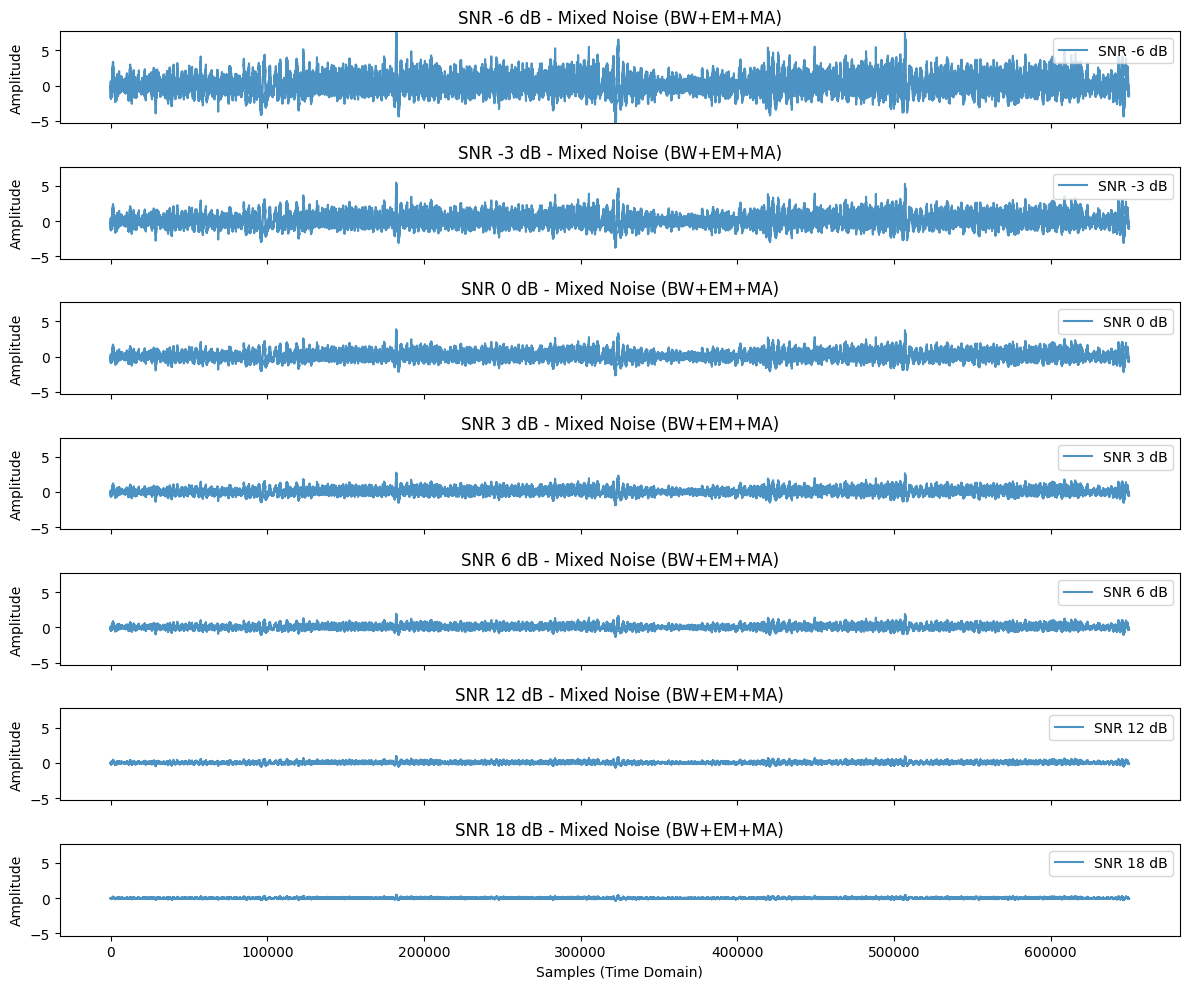

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# SNR 레벨
snr_levels = [-6, -3, 0, 3, 6, 12, 18]
base_path = 'data2/'

def load_mixed_noise(snr_db):
    """ SNR별 혼합 노이즈 파일 불러오기 """
    with open(f'{base_path}Mixed_Noise_SNR_{snr_db}.pkl', 'rb') as f:
        noise = pickle.load(f)  # (2, 650000, 1)
    return noise.squeeze(-1)  # (2, 650000)

# 모든 데이터 로드하여 Y축 범위 확인
all_noises = [load_mixed_noise(snr) for snr in snr_levels]

# Y축 범위 계산 (모든 SNR에서 최대/최소값 찾기)
y_min = min(noise.min() for noise in all_noises)
y_max = max(noise.max() for noise in all_noises)

# 시각화
fig, axes = plt.subplots(len(snr_levels), 1, figsize=(12, 10), sharex=True, sharey=True)

for i, snr in enumerate(snr_levels):
    mixed_noise = all_noises[i]
    
    axes[i].plot(mixed_noise[0, :], label=f"SNR {snr} dB", alpha=0.8)
    axes[i].set_title(f"SNR {snr} dB - Mixed Noise (BW+EM+MA)")
    axes[i].set_ylabel("Amplitude")
    axes[i].set_ylim(y_min, y_max)  # Y축 동일하게 설정
    axes[i].legend(loc="upper right")

plt.xlabel("Samples (Time Domain)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pickle
import wfdb

def load_noise(noise_type, snr_db, base_path='data2/'):
    """
    SNR별 BW, EM, MA 노이즈를 불러오는 함수
    """
    with open(f'{base_path}{noise_type}_Noise_SNR_{snr_db}.pkl', 'rb') as f:
        noise = pickle.load(f)  # Shape: (2, 650000, 1)
    return noise.squeeze(-1)  # Shape: (2, 650000)

def generate_combined_noise():
    """
    Chunk 단위로 BW, EM, MA 노이즈를 합쳐서 Train/Test 데이터 생성
    """
    snr_values = [-6, -3, 0, 3, 6, 12, 18]
    chunk_size = 10000
    total_samples = 650000
    num_chunks = total_samples // chunk_size
    
    combined_train = np.zeros((2, total_samples))
    combined_test = np.zeros((2, total_samples))
    
    np.random.seed(1234)  # Seed 설정
    
    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = start_idx + chunk_size
        
        # Random SNR 선택
        bw_snr = np.random.choice(snr_values)
        em_snr = np.random.choice(snr_values)
        ma_snr = np.random.choice(snr_values)
        
        # 해당 SNR의 노이즈 불러오기
        bw_noise = load_noise('BW', bw_snr)[:, start_idx:end_idx]
        em_noise = load_noise('EM', em_snr)[:, start_idx:end_idx]
        ma_noise = load_noise('MA', ma_snr)[:, start_idx:end_idx]
        
        # 채널별 합산하여 혼합 노이즈 생성
        mixed_noise = bw_noise + em_noise + ma_noise
        
        # Train / Test Split (Half and Half)
        if chunk_idx < num_chunks // 2:
            combined_train[:, start_idx:end_idx] = mixed_noise
        else:
            combined_test[:, start_idx:end_idx] = mixed_noise
    
    # 차원 확장하여 (2, 650000, 1) 형태로 저장
    combined_train = np.expand_dims(combined_train, axis=-1)
    combined_test = np.expand_dims(combined_test, axis=-1)
    
    with open('data2/CombinedNoise_Train.pkl', 'wb') as f:
        pickle.dump(combined_train, f)
    with open('data2/CombinedNoise_Test.pkl', 'wb') as f:
        pickle.dump(combined_test, f)
    
    print("[INFO] Combined Noise Train/Test 저장 완료!")

# 실행
generate_combined_noise()

import pickle
import numpy as np

# Load the data
with open('data2/CombinedNoise_Train.pkl', 'rb') as f:
    train_noise = pickle.load(f)  # Shape: (2, 650000, 1)

with open('data2/CombinedNoise_Test.pkl', 'rb') as f:
    test_noise = pickle.load(f)  # Shape: (2, 650000, 1)

# Calculate the half-length
total_length = train_noise.shape[1]  # 650000 samples
half_length = total_length // 2

# Combine the first half of train_noise with the second half of test_noise for each channel
combined_channel_0 = np.concatenate((train_noise[0, :half_length], test_noise[0, half_length:]), axis=0)
combined_channel_1 = np.concatenate((train_noise[1, :half_length], test_noise[1, half_length:]), axis=0)

# Reshape to (650000,)
combined_channel_0 = combined_channel_0.squeeze()  # Shape: (650000,)
combined_channel_1 = combined_channel_1.squeeze()  # Shape: (650000,)

# Save combined_channel_0 as CombinedNoise_Train.pkl
with open('data2/CombinedNoise_Train.pkl', 'wb') as f:
    pickle.dump(combined_channel_0, f)

# Save combined_channel_1 as CombinedNoise_Test.pkl
with open('data2/CombinedNoise_Test.pkl', 'wb') as f:
    pickle.dump(combined_channel_1, f)

print("Saved combined_channel_0 as CombinedNoise_Train.pkl with shape:", combined_channel_0.shape)
print("Saved combined_channel_1 as CombinedNoise_Test.pkl with shape:", combined_channel_1.shape)


[INFO] Combined Noise Train/Test 저장 완료!
Saved combined_channel_0 as CombinedNoise_Train.pkl with shape: (650000,)
Saved combined_channel_1 as CombinedNoise_Test.pkl with shape: (650000,)


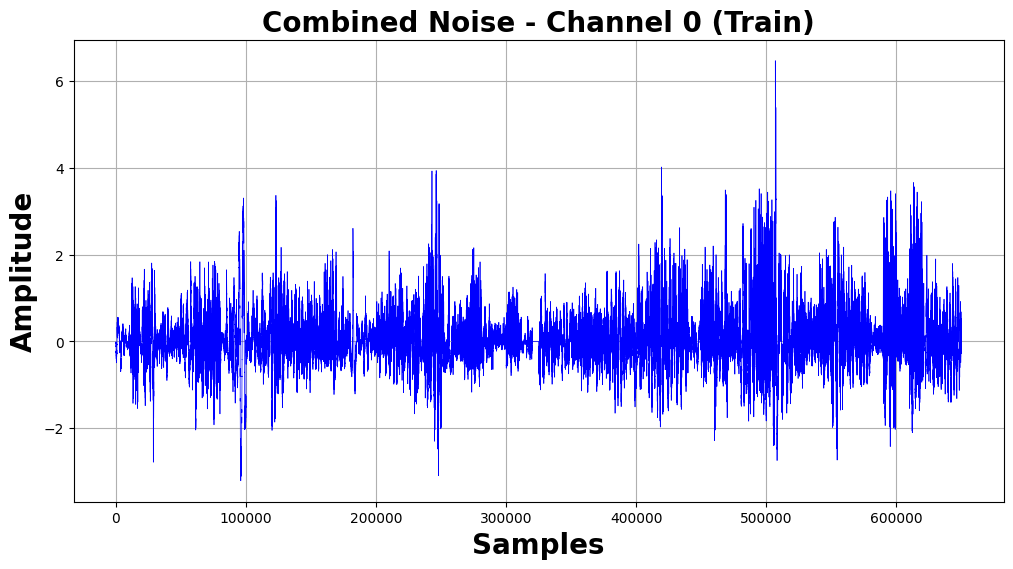

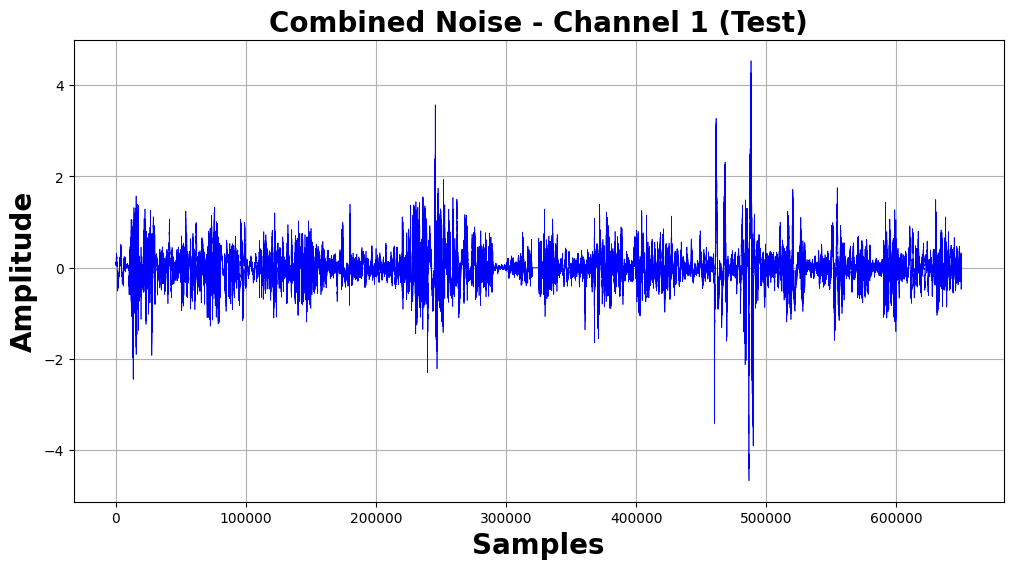

In [ ]:
import matplotlib.pyplot as plt

def plot_noise(data, title, xlabel="Samples", ylabel="Amplitude"):
    plt.figure(figsize=(12, 6))
    plt.plot(data, color='blue', linewidth=0.5)
    
    # 제목과 레이블의 글꼴을 80포인트로 하고 굵게 설정
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel(xlabel, fontsize=20, fontweight='bold')
    plt.ylabel(ylabel, fontsize=20, fontweight='bold')
    
    plt.grid(True)
    plt.show()

# combined_channel_0 시각화 (CombinedNoise_Train.pkl)
plot_noise(combined_channel_0, "Combined Noise - Channel 0 (Train)")

# combined_channel_1 시각화 (CombinedNoise_Test.pkl)
plot_noise(combined_channel_1, "Combined Noise - Channel 1 (Test)")

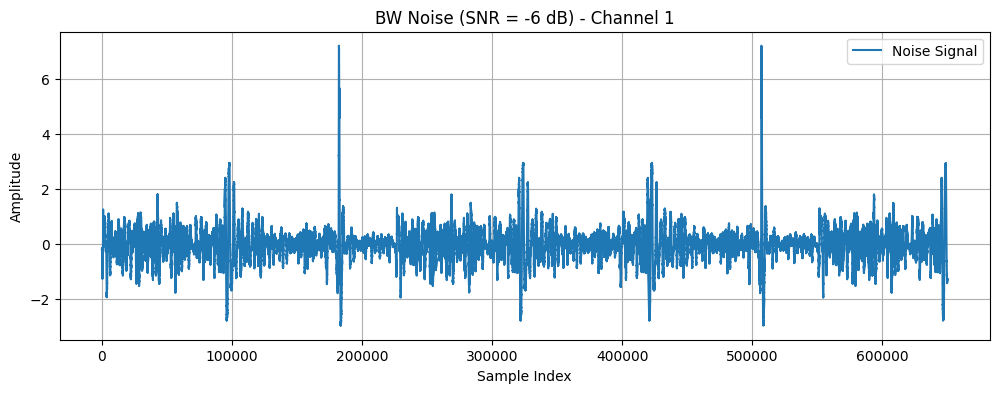

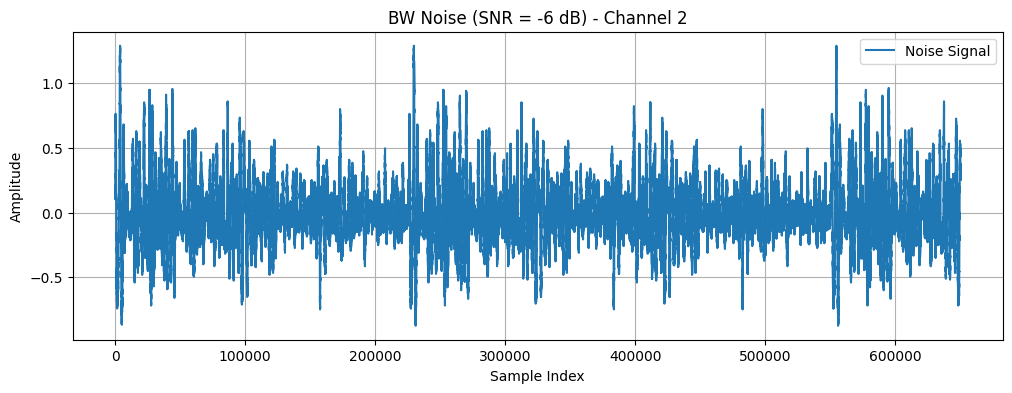

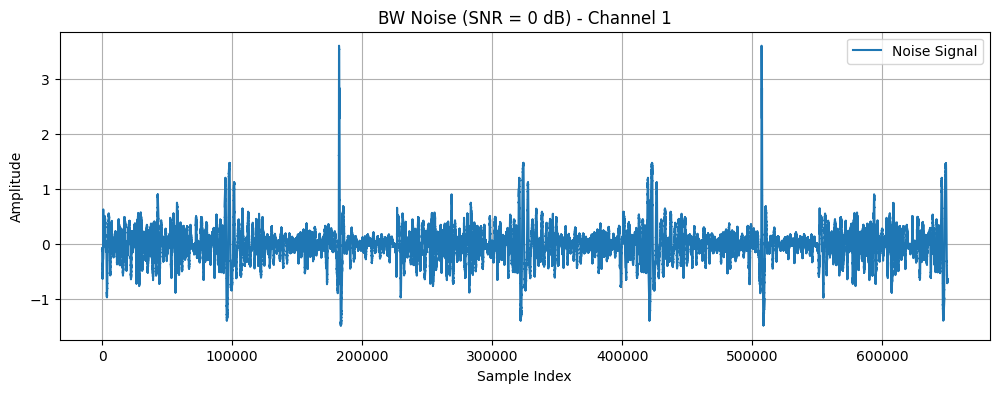

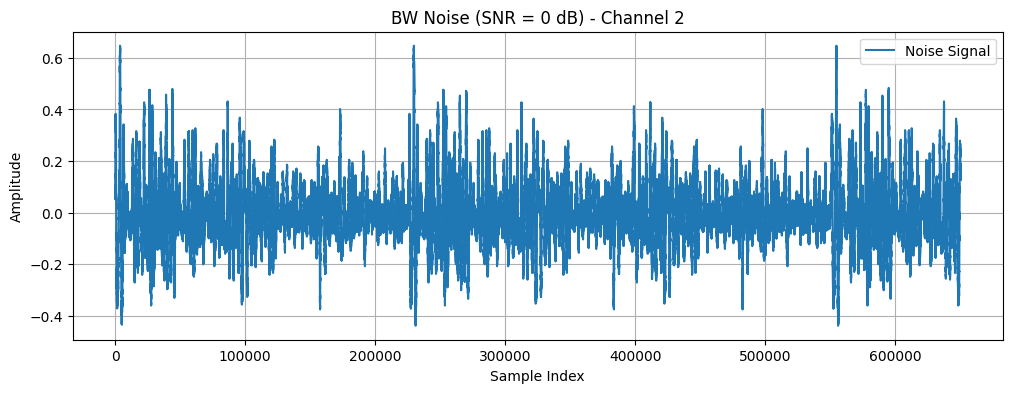

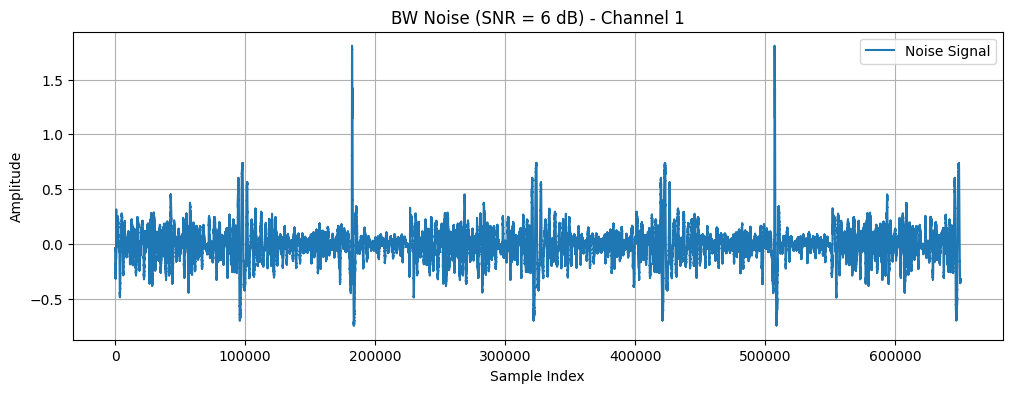

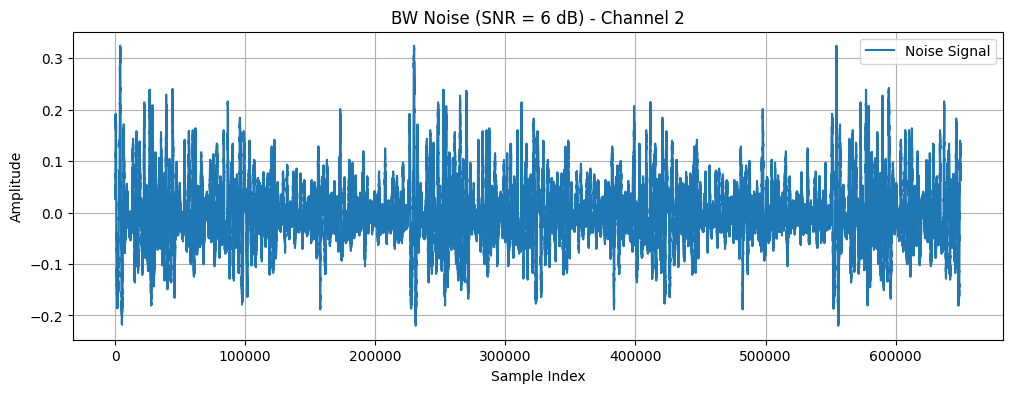

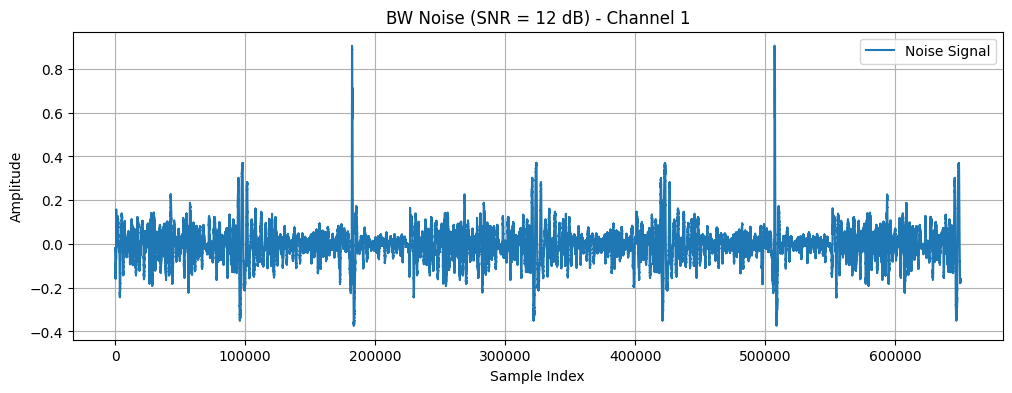

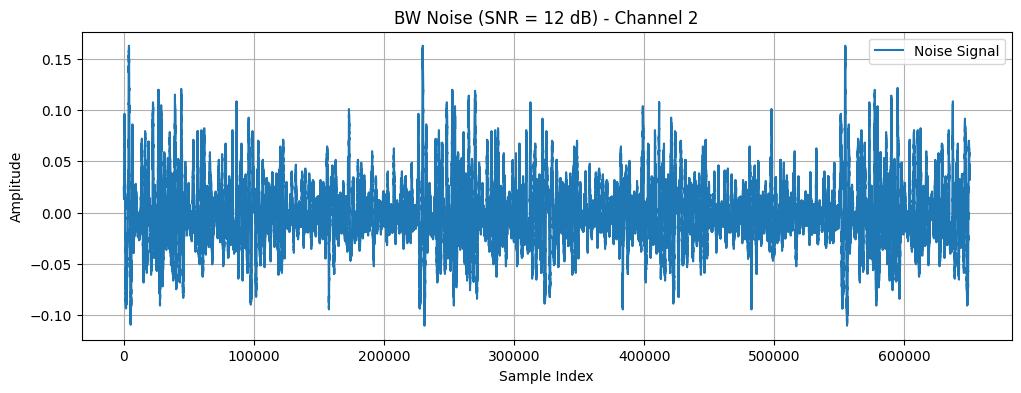

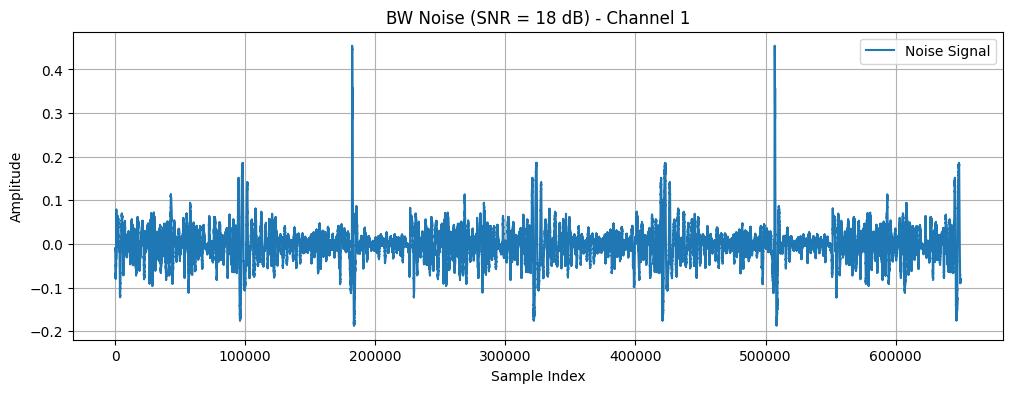

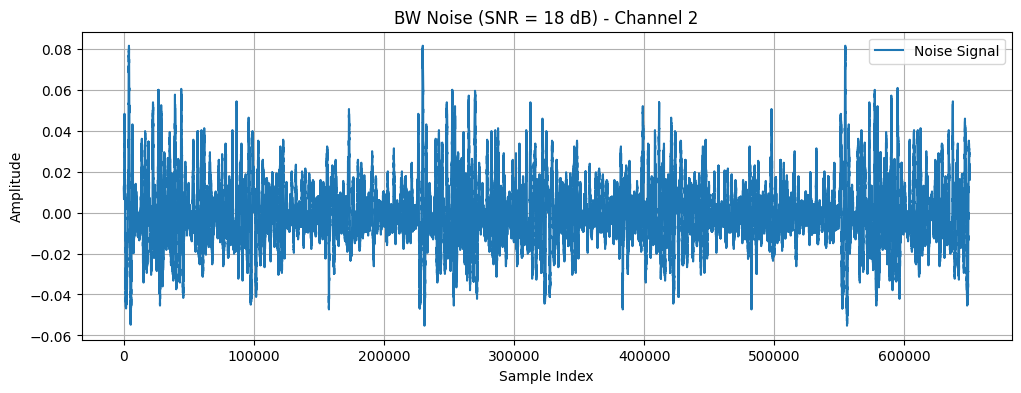

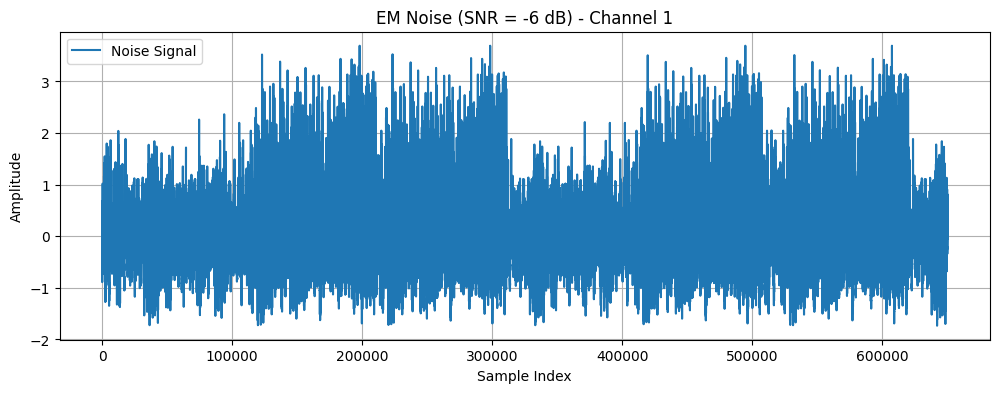

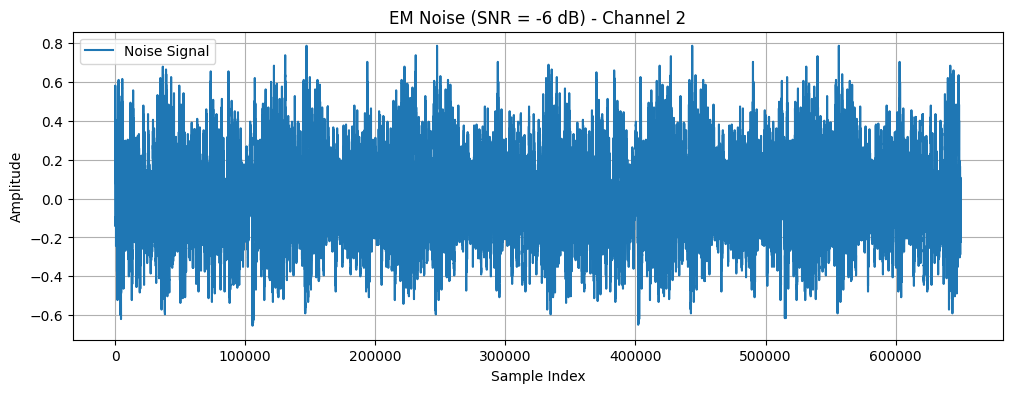

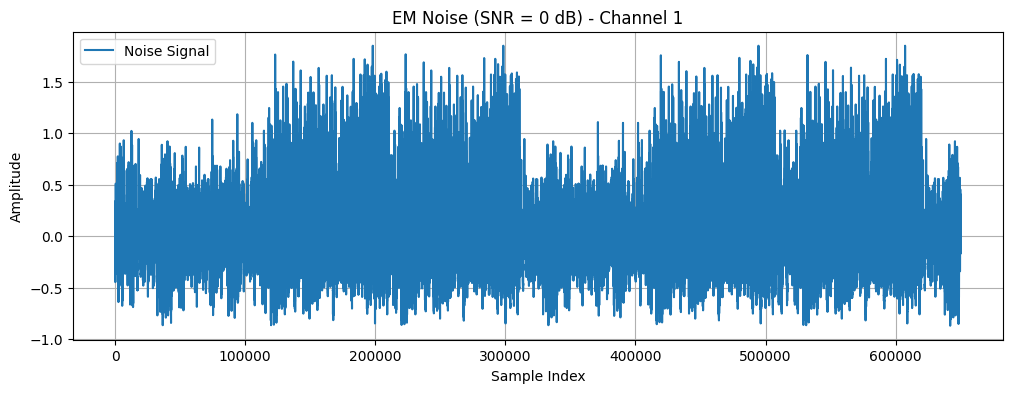

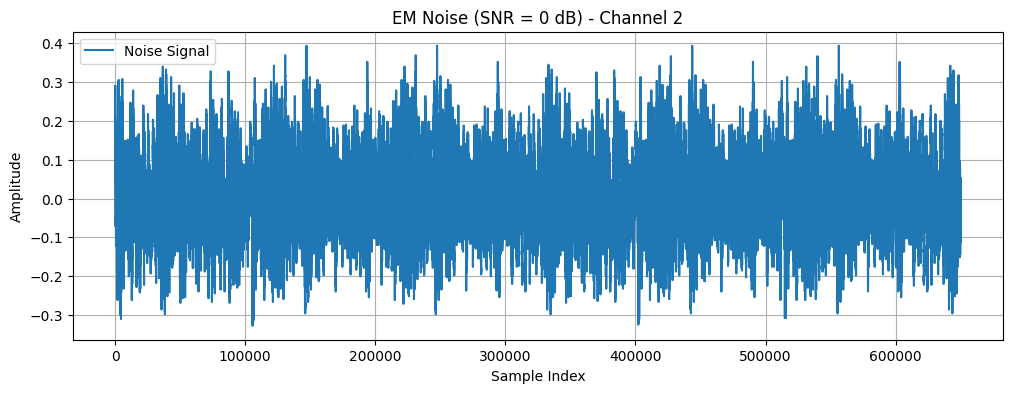

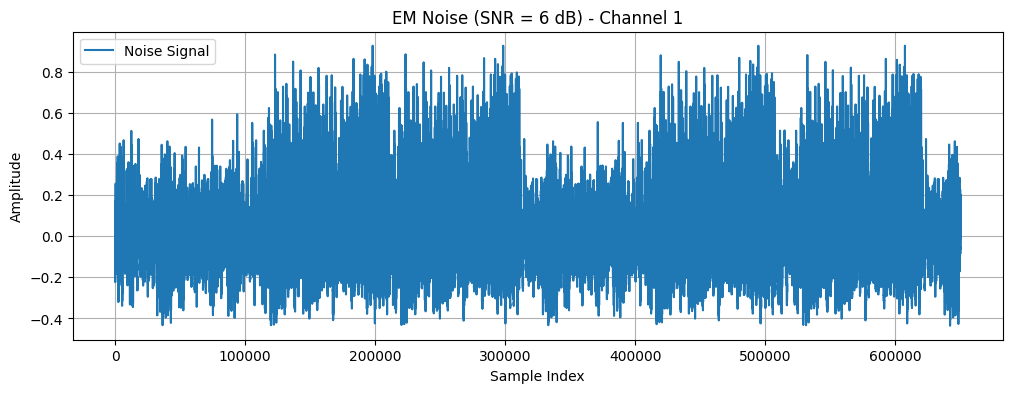

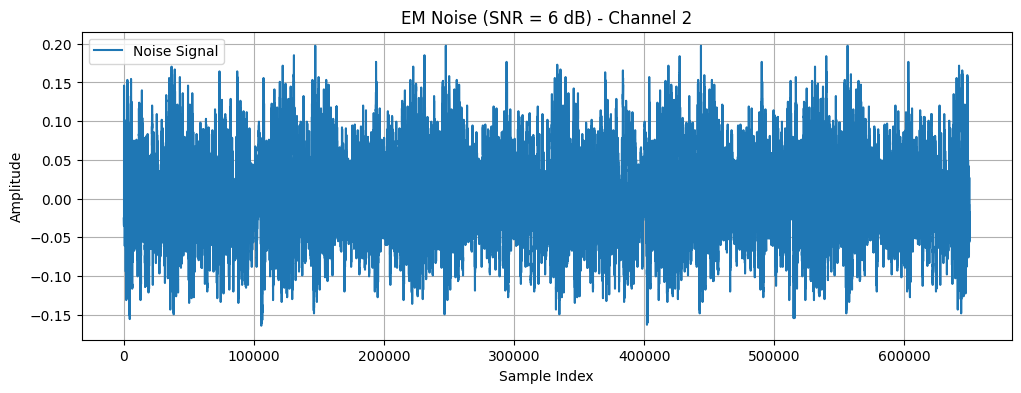

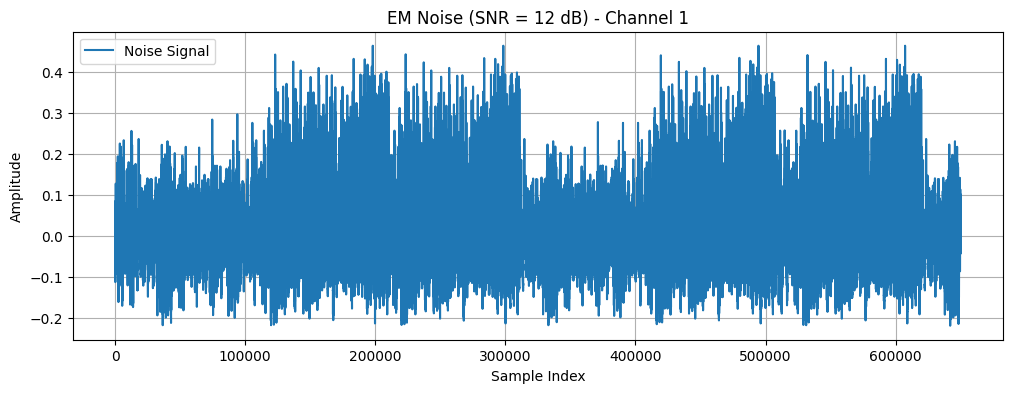

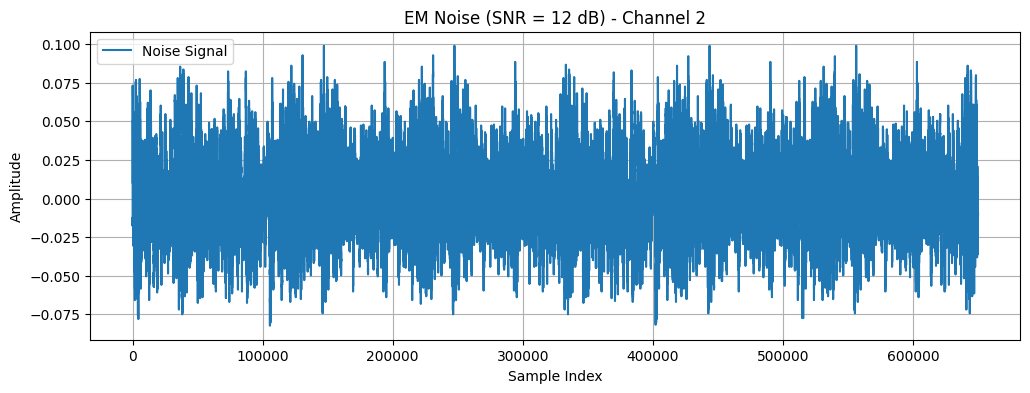

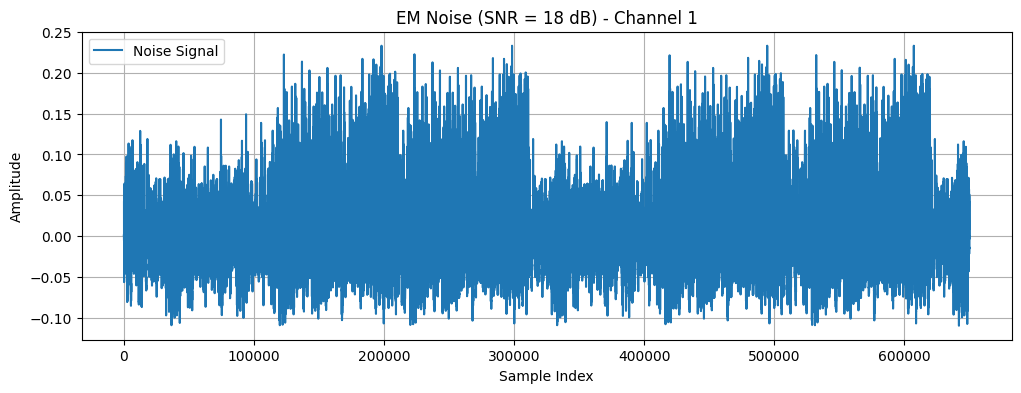

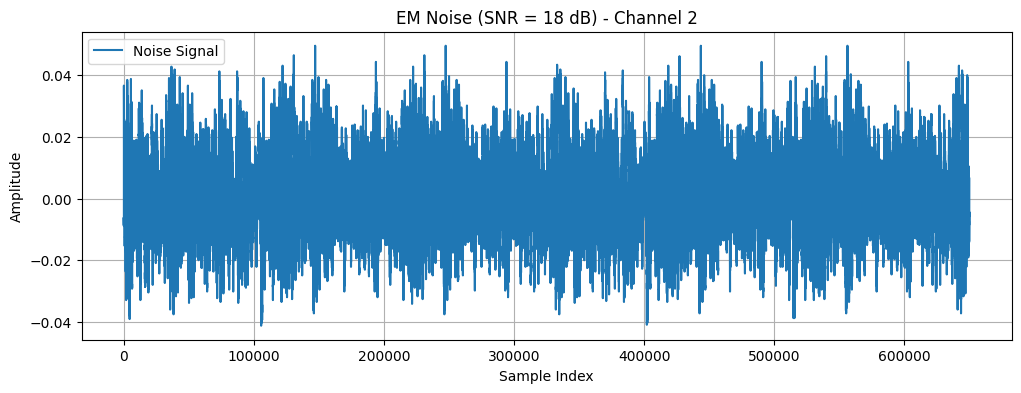

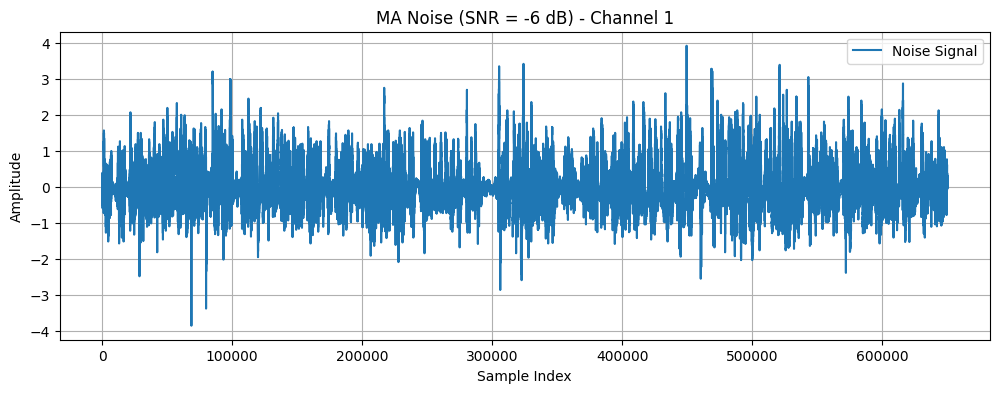

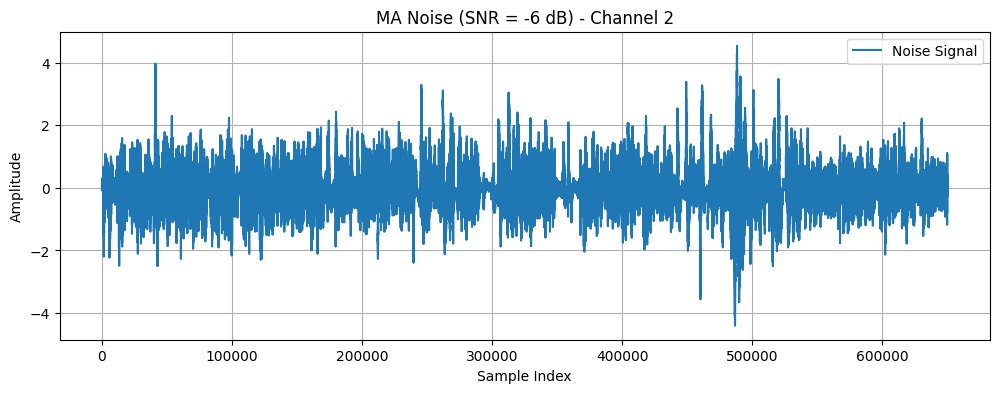

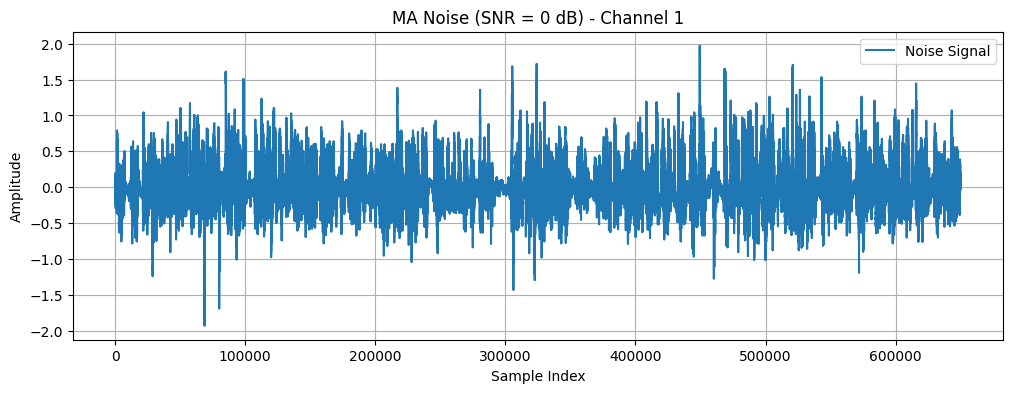

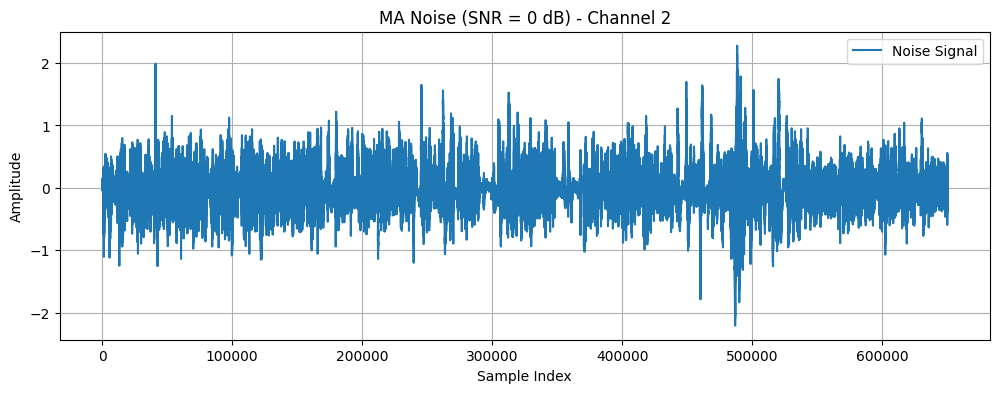

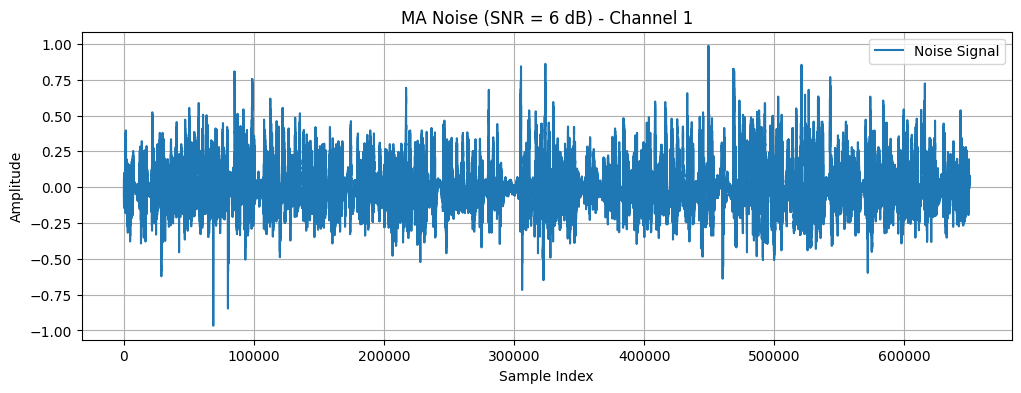

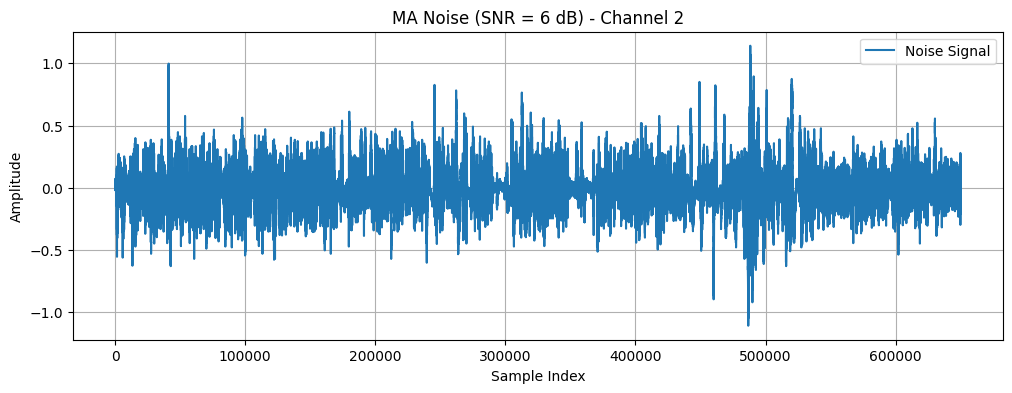

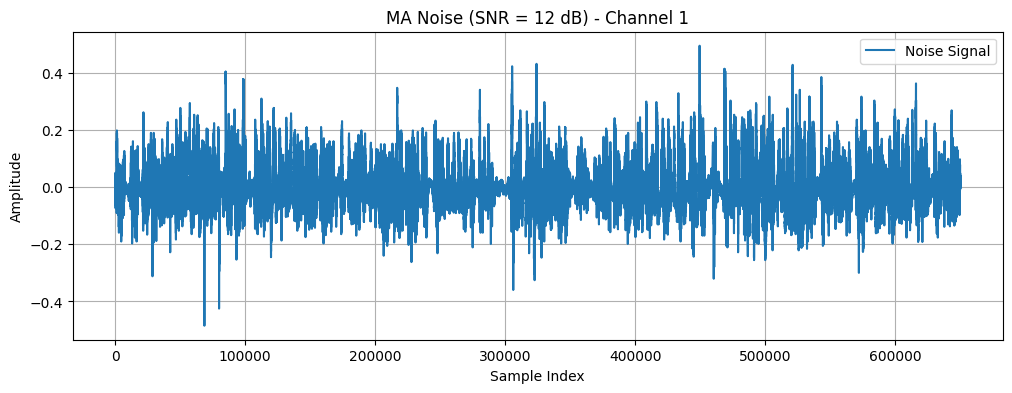

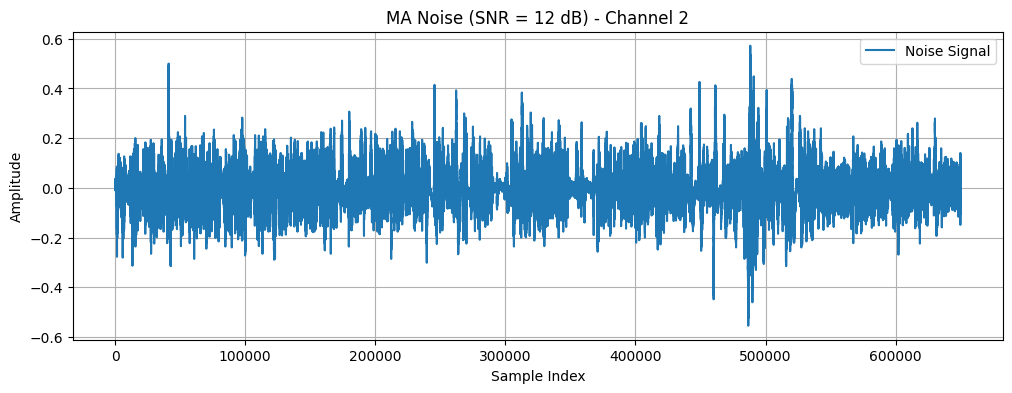

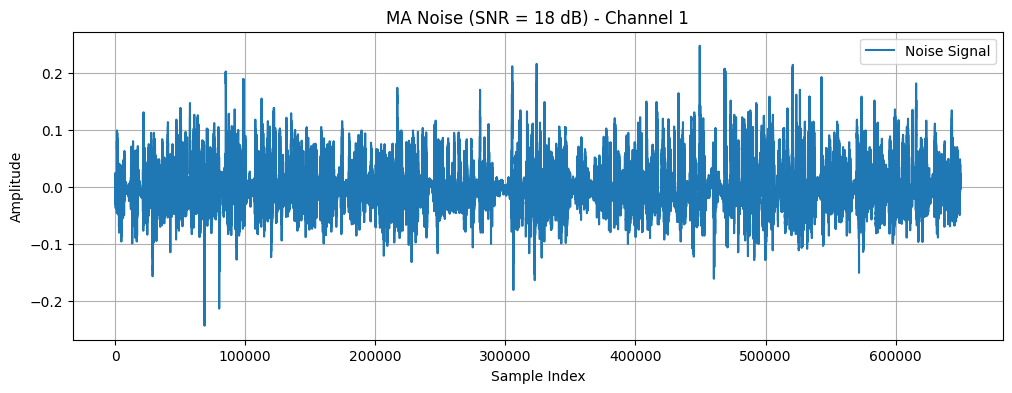

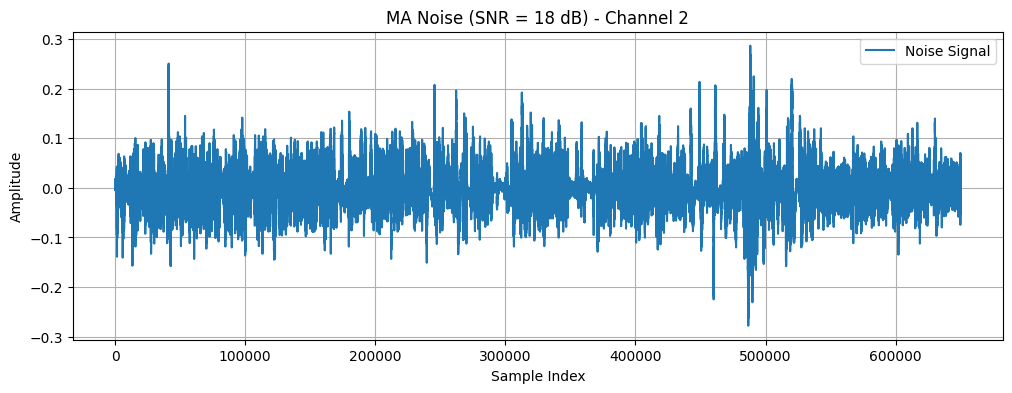

[INFO] 모든 노이즈 시각화 완료!


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 시각화 함수
def plot_noise_sample(noise, title, sample_range=(0, 650000)):
    """
    특정 범위의 노이즈 신호를 시각화하는 함수
    """
    plt.figure(figsize=(12, 4))
    plt.plot(noise[sample_range[0]:sample_range[1]], label="Noise Signal")
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# ==============================
# ✅ 15개 개별 노이즈 시각화 (BW, EM, MA 각 5개 SNR)
# ==============================
snr_levels = [-6, 0, 6, 12, 18]
noise_types = ['BW', 'EM', 'MA']

for noise_type in noise_types:
    for snr in snr_levels:
        with open(f'data/{noise_type}_Noise_SNR_{snr}.pkl', 'rb') as f:
            noise_data = pickle.load(f)  # Shape: (2, 650000, 1)

        # 첫 번째 채널 시각화
        plot_noise_sample(noise_data[0, :, 0], f"{noise_type} Noise (SNR = {snr} dB) - Channel 1")

        # 두 번째 채널 시각화
        plot_noise_sample(noise_data[1, :, 0], f"{noise_type} Noise (SNR = {snr} dB) - Channel 2")

print("[INFO] 모든 노이즈 시각화 완료!")


# 기본

In [ ]:
import numpy as np
import wfdb
import _pickle as pickle

import pickle

In [ ]:
# def SSD(y, y_pred):
#     return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension
from sklearn.metrics.pairwise import cosine_similarity

# def MAD(y, y_pred):
#     return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension
def RMSE(y, y_pred):
    """
    RMSE (Root Mean Square Error) 계산 (mV 단위)
    - y: 원본 신호
    - y_pred: 예측된 신호
    """
    mse = np.mean(np.square(y - y_pred), axis=1)  # MSE 계산
    rmse = np.sqrt(mse)  # RMSE 변환
    return rmse  # 단위: mV

def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD

def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

def SNR(y, y_pred):
    signal_power = np.sum(np.square(y), axis=1)
    noise_power = np.sum(np.square(y - y_pred), axis=1)
    
    # 분모가 0이 되는 것을 방지하기 위해 작은 값을 더해줌
    noise_power = np.where(noise_power == 0, 1e-10, noise_power)
    
    snr_value = 10 * np.log10(signal_power / noise_power)
    return snr_value


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    # Print tabular results in the console, in a pretty way

    # The FIR and IIR are the last on all_values
    # We need circular shift them to the right
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')

In [ ]:

qt='/home/dhc99/ecg_denoise/data/QTDatabase.pkl'
with open(qt, 'rb') as f:
    data = pickle.load(f)
# Assuming data['sele0122'] is a list containing a single NumPy array
print(len(data['sele0122']))

# Check the lengths of each array in the list
lengths = [len(arr) for arr in data['sele0122']]
print("Lengths of arrays:", lengths)


1412
Lengths of arrays: [228, 227, 227, 224, 224, 228, 227, 227, 225, 228, 228, 229, 229, 229, 225, 225, 224, 225, 224, 224, 224, 224, 224, 224, 224, 225, 222, 221, 219, 222, 221, 221, 224, 224, 222, 225, 225, 227, 227, 224, 227, 228, 229, 229, 232, 229, 229, 231, 229, 229, 229, 228, 228, 228, 227, 227, 227, 225, 225, 224, 222, 221, 221, 219, 219, 219, 219, 219, 218, 221, 219, 219, 219, 221, 222, 224, 222, 224, 224, 227, 227, 225, 228, 229, 227, 228, 228, 227, 229, 227, 228, 228, 229, 225, 228, 227, 228, 228, 225, 227, 228, 225, 221, 222, 224, 219, 221, 221, 219, 221, 221, 221, 222, 219, 219, 221, 219, 222, 219, 222, 222, 224, 222, 224, 222, 225, 225, 224, 227, 227, 227, 225, 227, 225, 224, 222, 225, 219, 222, 224, 224, 221, 219, 221, 222, 219, 221, 222, 222, 221, 228, 229, 228, 231, 231, 231, 232, 229, 228, 231, 229, 229, 229, 229, 229, 227, 229, 229, 227, 227, 225, 225, 222, 222, 222, 222, 221, 218, 219, 218, 218, 219, 218, 221, 221, 222, 221, 222, 225, 228, 228, 229, 229, 232, 234, 

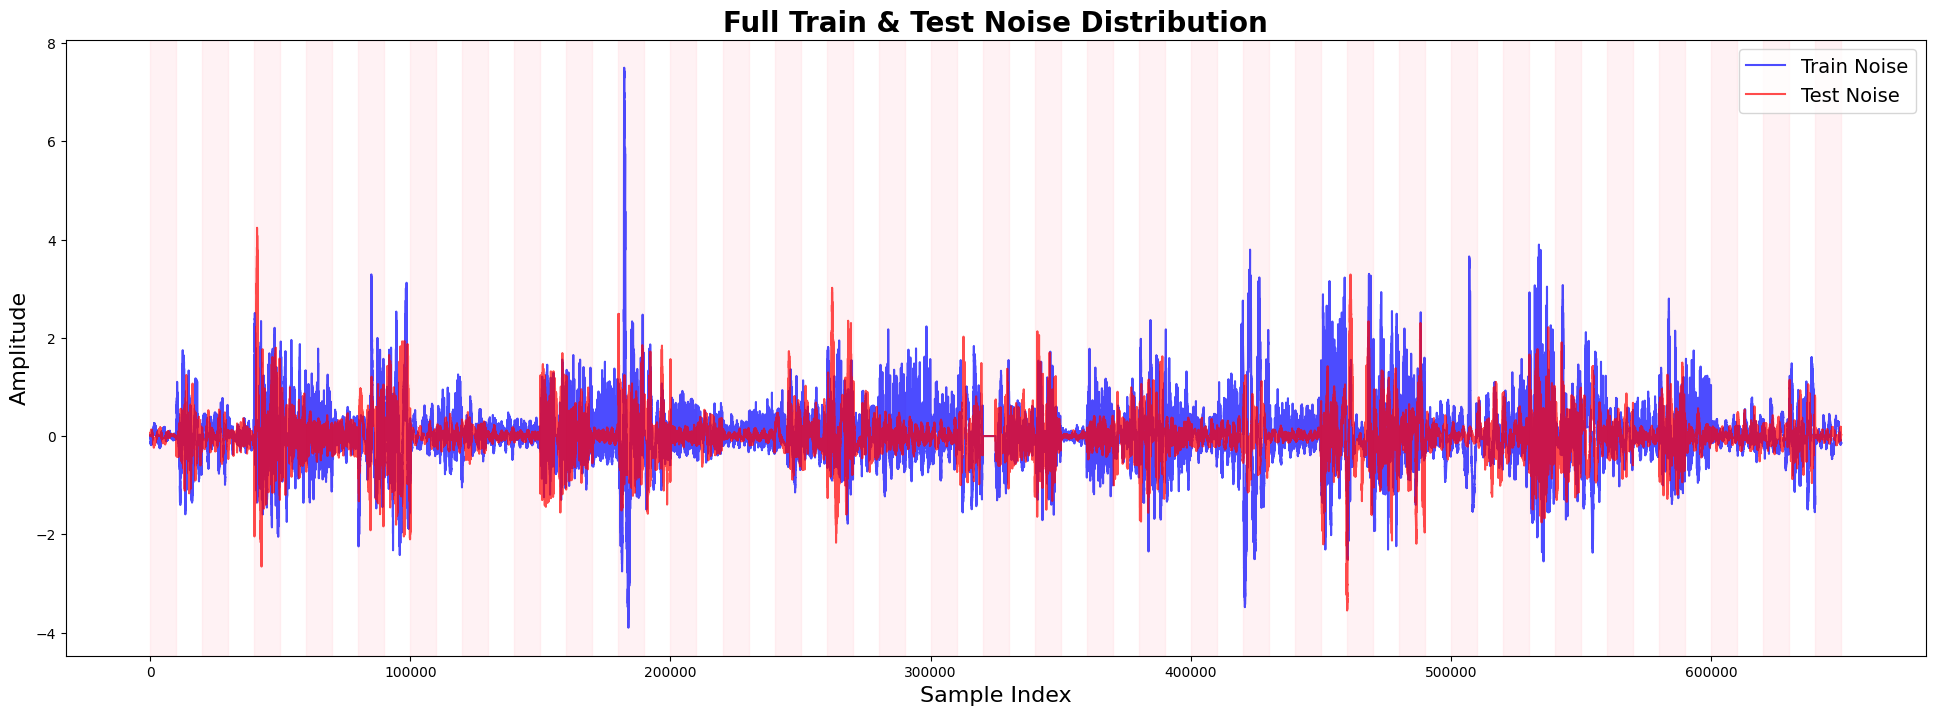

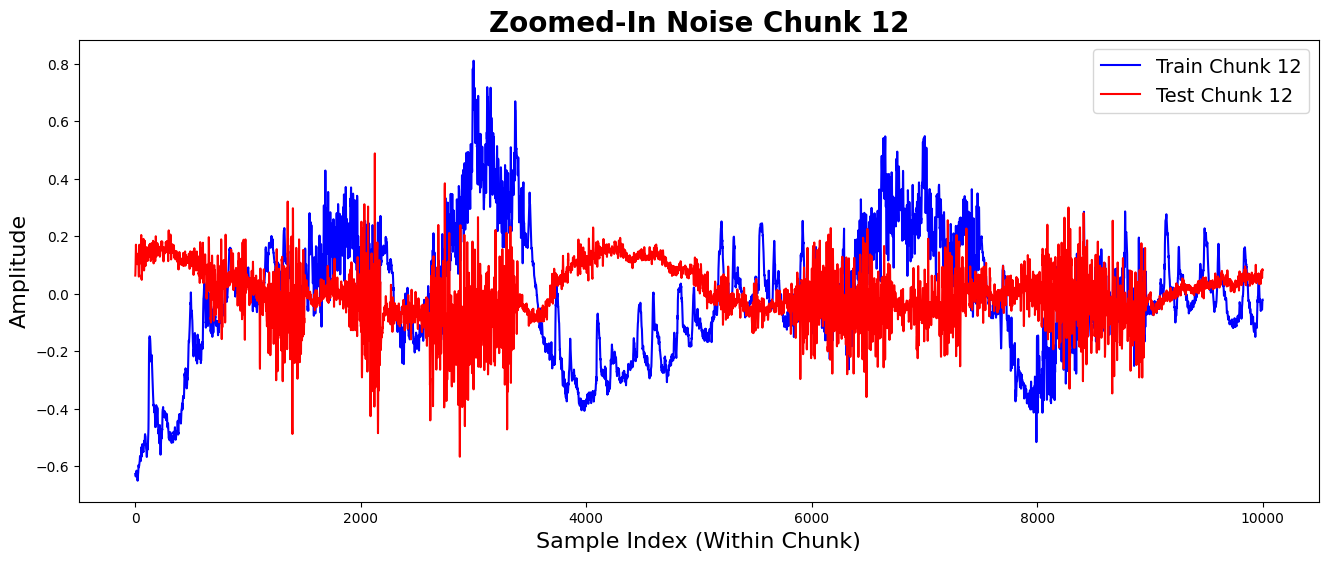

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load Train and Test Noise
train_noise_path = 'data/CombinedNoise_Train.pkl'
test_noise_path = 'data/CombinedNoise_Test.pkl'

with open(train_noise_path, 'rb') as f:
    train_noise = pickle.load(f)  # Shape: (650000, 1)

with open(test_noise_path, 'rb') as f:
    test_noise = pickle.load(f)  # Shape: (650000, 1)

# # Load SNR Log (Assumes snr_info was saved separately)
# snr_log_path = 'data/SNR_Log.pkl'  # Ensure you save snr_info separately
# with open(snr_log_path, 'rb') as f:
#     snr_info = pickle.load(f)  # List of dictionaries containing SNR data

chunk_size = 10000
num_chunks = train_noise.shape[0] // chunk_size
x_full = np.arange(train_noise.shape[0])

# 🚀 **1️⃣ Plot Full Train & Test Noise**
plt.figure(figsize=(24, 8))
plt.plot(x_full, train_noise, label="Train Noise", color="blue", alpha=0.7)
plt.plot(x_full, test_noise, label="Test Noise", color="red", alpha=0.7)

# Highlight alternating chunks
for i in range(num_chunks):
    if i % 2 == 0:
        plt.axvspan(i * chunk_size, (i + 1) * chunk_size, color="pink", alpha=0.2)

plt.title("Full Train & Test Noise Distribution", fontsize=20, fontweight="bold")
plt.xlabel("Sample Index", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(fontsize=14)
plt.show()

# 🚀 **2️⃣ Zoomed-In View of a Specific Chunk**
zoom_chunk_idx = 12  # Change this to zoom into different chunks
start_idx = zoom_chunk_idx * chunk_size
end_idx = start_idx + chunk_size
x_zoom = np.arange(chunk_size)

plt.figure(figsize=(16, 6))
plt.plot(x_zoom, train_noise[start_idx:end_idx], label=f"Train Chunk {zoom_chunk_idx}", color="blue")
plt.plot(x_zoom, test_noise[start_idx:end_idx], label=f"Test Chunk {zoom_chunk_idx}", color="red")

plt.title(f"Zoomed-In Noise Chunk {zoom_chunk_idx}", fontsize=20, fontweight="bold")
plt.xlabel("Sample Index (Within Chunk)", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(fontsize=14)
plt.show()



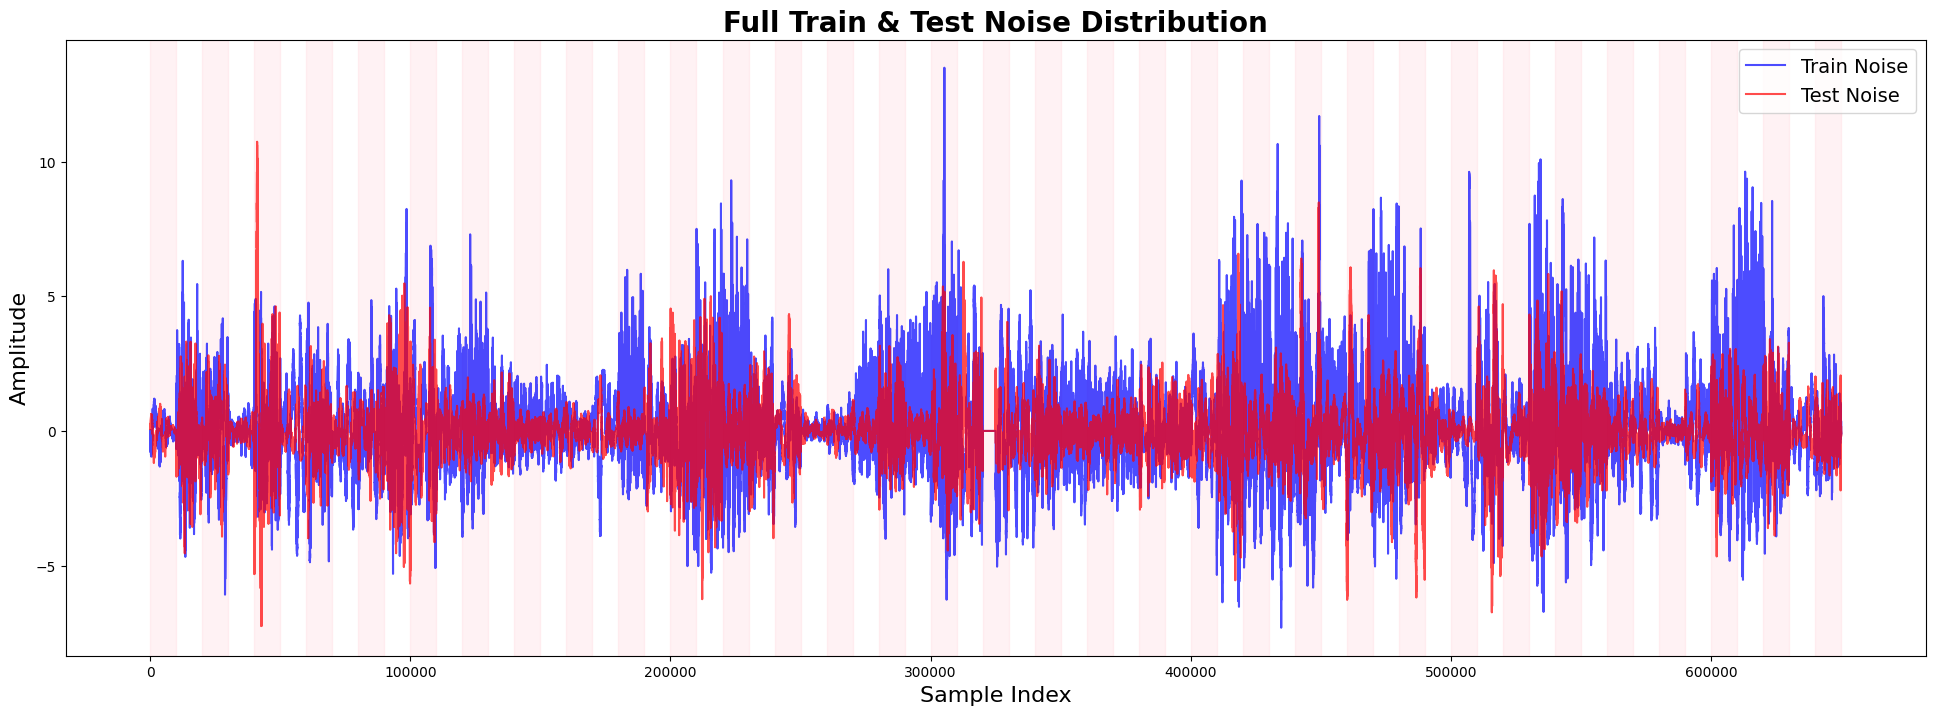

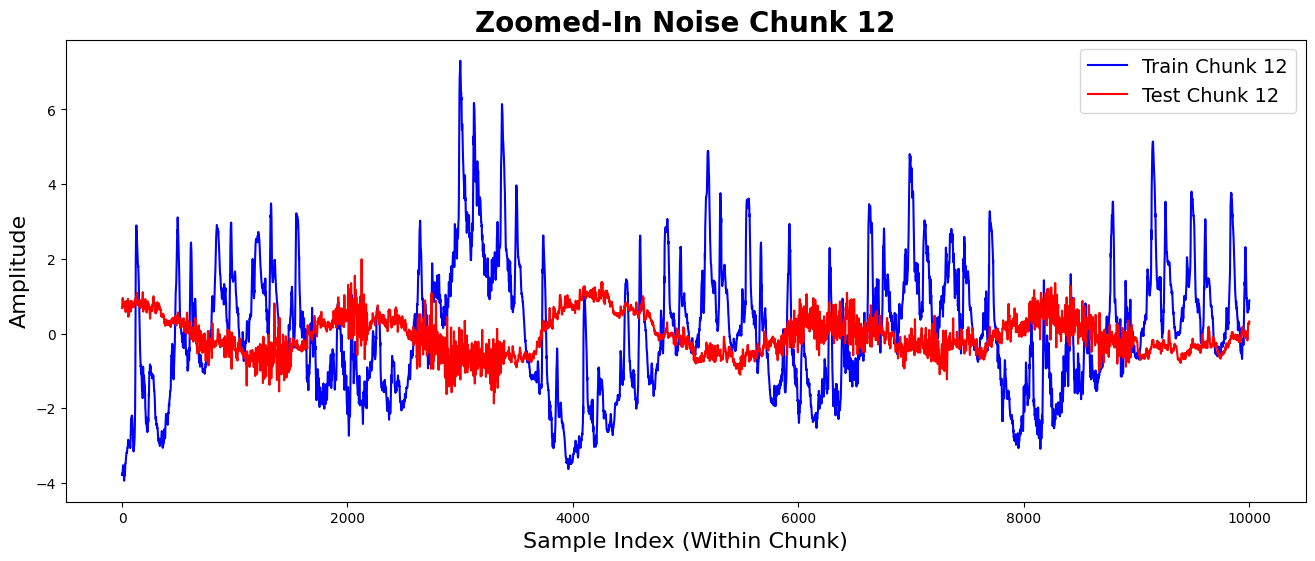

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load Train and Test Noise
train_noise_path = 'data2/CombinedNoise_Train.pkl'
test_noise_path = 'data2/CombinedNoise_Test.pkl'

with open(train_noise_path, 'rb') as f:
    train_noise = pickle.load(f)  # Shape: (650000, 1)

with open(test_noise_path, 'rb') as f:
    test_noise = pickle.load(f)  # Shape: (650000, 1)


chunk_size = 10000
num_chunks = train_noise.shape[0] // chunk_size
x_full = np.arange(train_noise.shape[0])

# 🚀 **1️⃣ Plot Full Train & Test Noise**
plt.figure(figsize=(24, 8))
plt.plot(x_full, train_noise, label="Train Noise", color="blue", alpha=0.7)
plt.plot(x_full, test_noise, label="Test Noise", color="red", alpha=0.7)

# Highlight alternating chunks
for i in range(num_chunks):
    if i % 2 == 0:
        plt.axvspan(i * chunk_size, (i + 1) * chunk_size, color="pink", alpha=0.2)

plt.title("Full Train & Test Noise Distribution", fontsize=20, fontweight="bold")
plt.xlabel("Sample Index", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(fontsize=14)
plt.show()

# 🚀 **2️⃣ Zoomed-In View of a Specific Chunk**
zoom_chunk_idx = 12  # Change this to zoom into different chunks
start_idx = zoom_chunk_idx * chunk_size
end_idx = start_idx + chunk_size
x_zoom = np.arange(chunk_size)

plt.figure(figsize=(16, 6))
plt.plot(x_zoom, train_noise[start_idx:end_idx], label=f"Train Chunk {zoom_chunk_idx}", color="blue")
plt.plot(x_zoom, test_noise[start_idx:end_idx], label=f"Test Chunk {zoom_chunk_idx}", color="red")

plt.title(f"Zoomed-In Noise Chunk {zoom_chunk_idx}", fontsize=20, fontweight="bold")
plt.xlabel("Sample Index (Within Chunk)", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(fontsize=14)
plt.show()

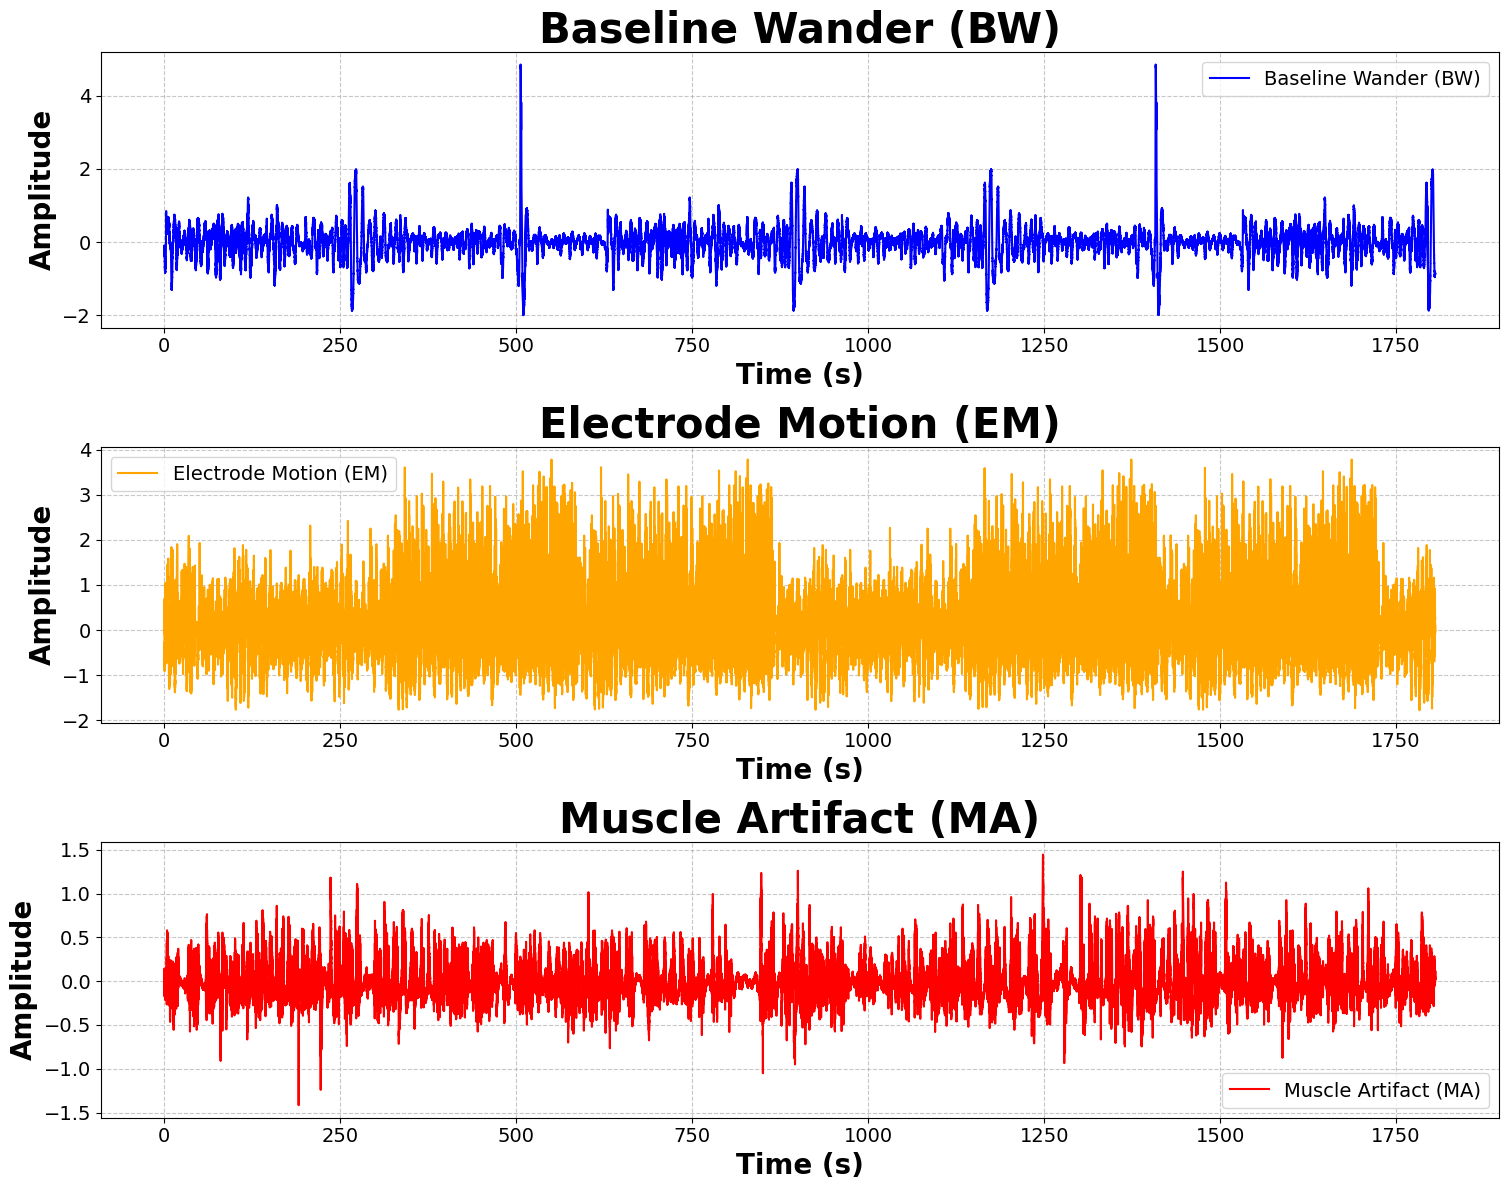

In [ ]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

def visualize_nstdb_noise_full(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Visualizes the full duration of each noise type from the MIT-BIH Noise Stress Test Database (NSTDB):
    Baseline Wander (BW), Electrode Motion (EM), and Muscle Artifact (MA).
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Define sampling frequency and time vector
    fs = 360  # NSTDB sampling frequency is 360 Hz
    duration_bw = len(bw_signals) / fs
    duration_em = len(em_signals) / fs
    duration_ma = len(ma_signals) / fs

    time_bw = np.linspace(0, duration_bw, len(bw_signals))
    time_em = np.linspace(0, duration_em, len(em_signals))
    time_ma = np.linspace(0, duration_ma, len(ma_signals))

    # # Apply a stylish matplotlib theme
    # plt.style.use('seaborn-darkgrid')

    # Plot each noise signal
    plt.figure(figsize=(15, 12))
    
    # Baseline Wander
    plt.subplot(3, 1, 1)
    plt.plot(time_bw, bw_signals[:, 0], label='Baseline Wander (BW)', color='blue', linewidth=1.5)
    plt.title(f'Baseline Wander (BW)', fontsize=30, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=20, fontweight='bold')
    plt.ylabel('Amplitude', fontsize=20, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    # Electrode Motion
    plt.subplot(3, 1, 2)
    plt.plot(time_em, em_signals[:, 0], label='Electrode Motion (EM)', color='orange', linewidth=1.5)
    plt.title(f'Electrode Motion (EM)', fontsize=30, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=20, fontweight='bold')
    plt.ylabel('Amplitude', fontsize=20, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    # Muscle Artifact
    plt.subplot(3, 1, 3)
    plt.plot(time_ma, ma_signals[:, 0], label='Muscle Artifact (MA)', color='red', linewidth=1.5)
    plt.title(f'Muscle Artifact (MA)', fontsize=30, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=20, fontweight='bold')
    plt.ylabel('Amplitude', fontsize=20, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_nstdb_noise_full()

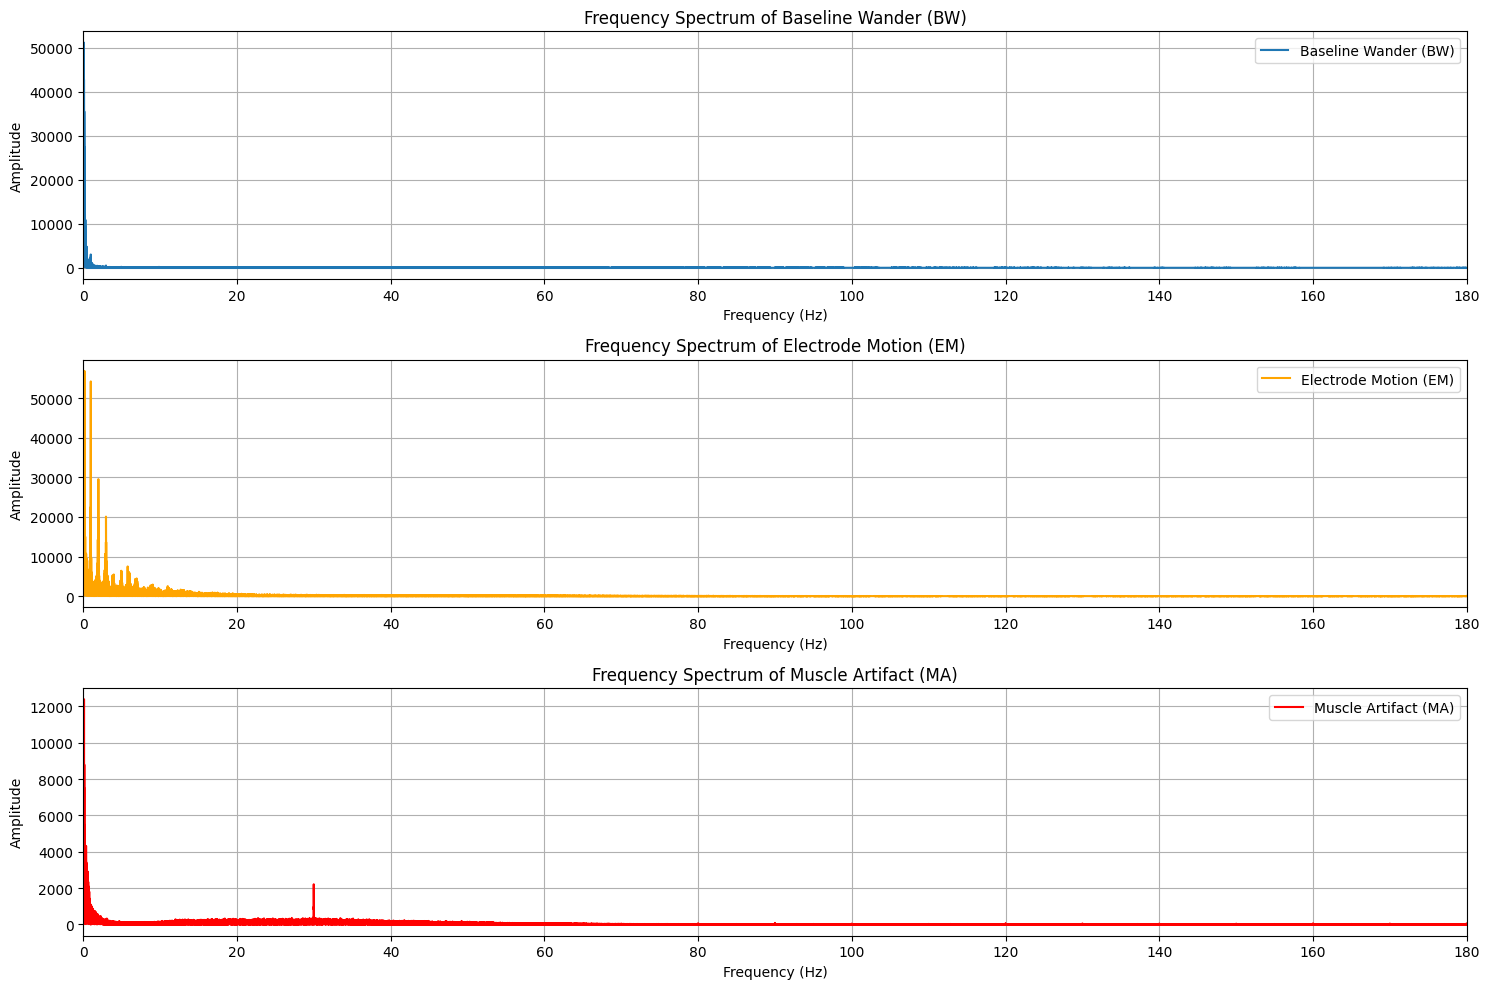

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

def plot_nstdb_frequency_spectrum(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Computes and visualizes the frequency spectrum of each noise type from 
    the MIT-BIH Noise Stress Test Database (NSTDB): 
    - Baseline Wander (BW)
    - Electrode Motion (EM)
    - Muscle Artifact (MA)

    Uses FFT to analyze frequency components.
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

    # Define sampling frequency
    fs = 360  # NSTDB sampling frequency is 360 Hz

    # Select first channel and flatten the signal
    bw_signal = bw_signals[:, 0]
    em_signal = em_signals[:, 0]
    ma_signal = ma_signals[:, 0]

    # Compute FFT
    def compute_fft(signal, fs):
        N = len(signal)  # Number of samples
        fft_vals = np.fft.fft(signal)  # FFT computation
        fft_freqs = np.fft.fftfreq(N, d=1/fs)  # Frequency bins
        return fft_freqs[:N // 2], np.abs(fft_vals[:N // 2])  # Return positive frequencies

    freq_bw, fft_bw = compute_fft(bw_signal, fs)
    freq_em, fft_em = compute_fft(em_signal, fs)
    freq_ma, fft_ma = compute_fft(ma_signal, fs)

    # Plot Frequency Spectrum
    plt.figure(figsize=(15, 10))

    # Baseline Wander
    plt.subplot(3, 1, 1)
    plt.plot(freq_bw, fft_bw, label='Baseline Wander (BW)')
    plt.title('Frequency Spectrum of Baseline Wander (BW)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 180)  # Focus on 0-100 Hz range
    plt.grid(True)
    plt.legend()

    # Electrode Motion
    plt.subplot(3, 1, 2)
    plt.plot(freq_em, fft_em, label='Electrode Motion (EM)', color='orange')
    plt.title('Frequency Spectrum of Electrode Motion (EM)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 180)
    plt.grid(True)
    plt.legend()

    # Muscle Artifact
    plt.subplot(3, 1, 3)
    plt.plot(freq_ma, fft_ma, label='Muscle Artifact (MA)', color='red')
    plt.title('Frequency Spectrum of Muscle Artifact (MA)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 180)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_nstdb_frequency_spectrum()


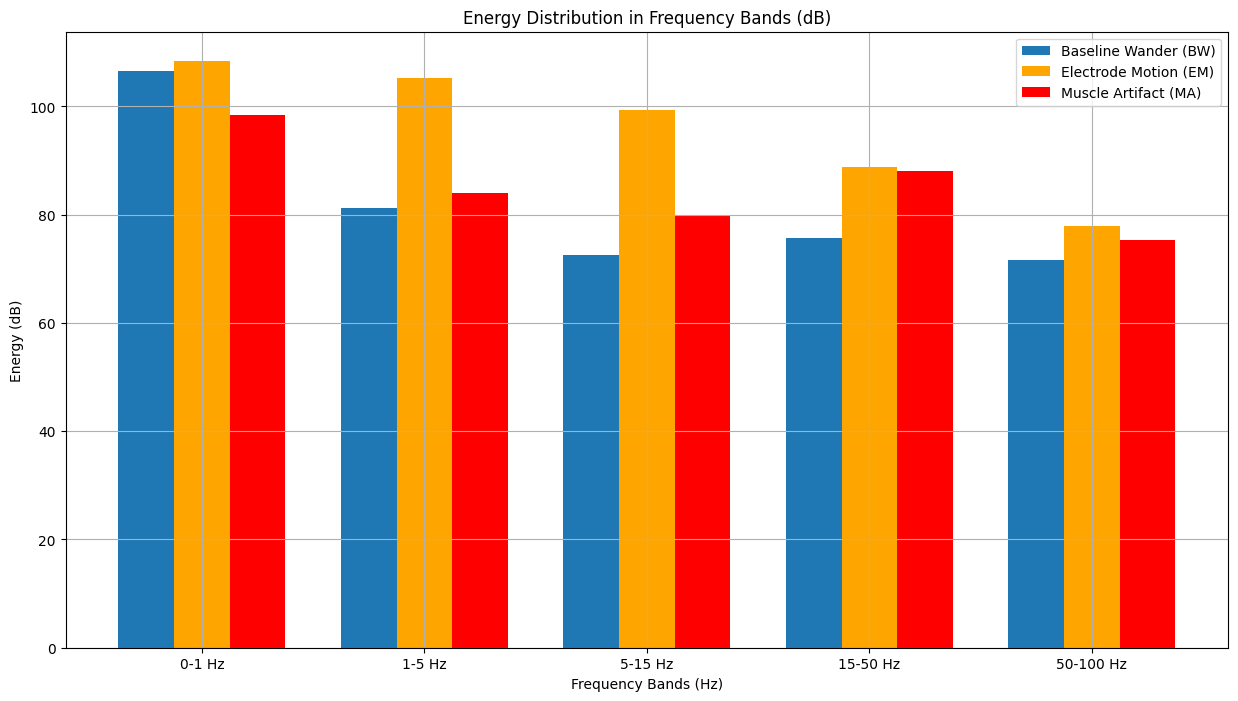

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

def compute_band_energy(signal, fs, bands):
    """
    Compute the energy in specific frequency bands and convert to dB.
    
    Parameters:
    - signal: 1D array of the signal.
    - fs: Sampling frequency (Hz).
    - bands: List of tuples specifying frequency bands [(fmin1, fmax1), (fmin2, fmax2), ...].
    
    Returns:
    - band_energies: List of energies in dB for each frequency band.
    """
    N = len(signal)
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(N, d=1/fs)
    
    band_energies = []
    for fmin, fmax in bands:
        band_mask = (fft_freqs >= fmin) & (fft_freqs <= fmax)
        band_energy = np.sum(np.abs(fft_vals[band_mask])**2)  # Compute energy in the band
        band_energy_db = 10 * np.log10(band_energy + 1e-10)  # Convert to dB
        band_energies.append(band_energy_db)
    
    return band_energies

def visualize_nstdb_noise_energy(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Visualizes the energy in different frequency bands (in dB) for each noise type 
    from the MIT-BIH Noise Stress Test Database (NSTDB): 
    Baseline Wander (BW), Electrode Motion (EM), and Muscle Artifact (MA).
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Define sampling frequency
    fs = 360  # NSTDB sampling frequency is 360 Hz
    
    # Select first channel
    bw_signal = bw_signals[:, 0]
    em_signal = em_signals[:, 0]
    ma_signal = ma_signals[:, 0]

    # Frequency bands (in Hz)
    bands = [(0, 1), (1, 5), (5, 15), (15, 50), (50, 100)]  # You can modify these bands

    # Compute energy in each band
    bw_energies = compute_band_energy(bw_signal, fs, bands)
    em_energies = compute_band_energy(em_signal, fs, bands)
    ma_energies = compute_band_energy(ma_signal, fs, bands)
    
    # Plot energy for each noise type
    band_labels = [f'{fmin}-{fmax} Hz' for fmin, fmax in bands]

    plt.figure(figsize=(15, 8))
    
    x = np.arange(len(bands))
    width = 0.25  # Bar width

    # Baseline Wander
    plt.bar(x - width, bw_energies, width, label='Baseline Wander (BW)')
    
    # Electrode Motion
    plt.bar(x, em_energies, width, label='Electrode Motion (EM)', color='orange')
    
    # Muscle Artifact
    plt.bar(x + width, ma_energies, width, label='Muscle Artifact (MA)', color='red')
    
    # Plot settings
    plt.xticks(x, band_labels)
    plt.xlabel('Frequency Bands (Hz)')
    plt.ylabel('Energy (dB)')
    plt.title('Energy Distribution in Frequency Bands (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
visualize_nstdb_noise_energy()


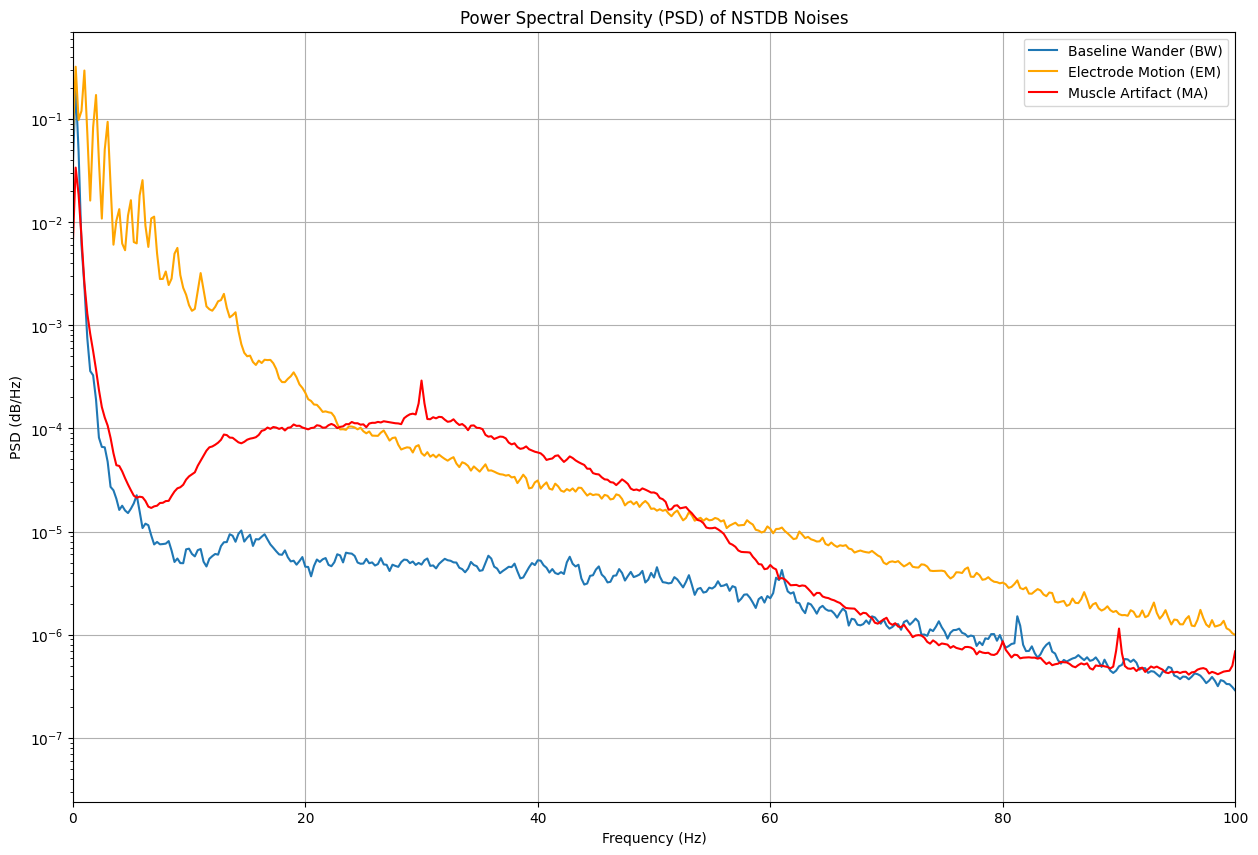

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_nstdb_psd(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Computes and visualizes the Power Spectral Density (PSD) for each noise type 
    from the MIT-BIH Noise Stress Test Database (NSTDB).
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Define sampling frequency
    fs = 360  # Sampling frequency (Hz)

    # Welch's method to compute PSD
    def compute_psd(signal, fs):
        freqs, psd = welch(signal, fs, nperseg=fs*4)  # Use 4-second segments for PSD
        return freqs, psd

    # Compute PSD for each noise signal
    freqs_bw, psd_bw = compute_psd(bw_signals[:, 0], fs)
    freqs_em, psd_em = compute_psd(em_signals[:, 0], fs)
    freqs_ma, psd_ma = compute_psd(ma_signals[:, 0], fs)

    # Plot PSD for each noise
    plt.figure(figsize=(15, 10))

    plt.semilogy(freqs_bw, psd_bw, label='Baseline Wander (BW)')
    plt.semilogy(freqs_em, psd_em, label='Electrode Motion (EM)', color='orange')
    plt.semilogy(freqs_ma, psd_ma, label='Muscle Artifact (MA)', color='red')
    
    plt.title('Power Spectral Density (PSD) of NSTDB Noises')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB/Hz)')
    plt.xlim(0, 100)  # Focus on 0–100 Hz range
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
plot_nstdb_psd()


static

In [ ]:
# static_noise = pickle.load(open('data/StaticNoise.pkl', 'rb'))
# # Convert the list to a numpy array and get its shape
# static_noise = np.array(static_noise)
# static_noise_shape = static_noise.shape

# static_noise_shape

In [ ]:
import wfdb
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal import resample
def visualize_and_highlight_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', 
                                  chunk_size=10000, save_path='fig4/'):
    """
    Visualizes full BW, EM, MA noise signals with one highlighted chunk.
    Also extracts and plots the highlighted chunk separately.
    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    chunk_size: Number of samples per chunk.
    save_path: Path to save the figures.
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

    # Resample signals to 360 Hz
    def resample_signal(signal, target_fs=360, original_fs=128):
        return resample(signal, int(len(signal) * (target_fs / original_fs)))
    bw_noise = resample_signal(bw_signals[:, 0])
    em_noise = resample_signal(em_signals[:, 0])
    ma_noise = resample_signal(ma_signals[:, 0])

    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as f:
        combined_noise = pickle.load(f)
    combined_resampled = resample(combined_noise[0, :, 0], len(bw_noise))

    # Define x-axis as total sample length
    total_samples = bw_signals.shape[0]  # Ensuring the correct length is used
    num_chunks = total_samples // chunk_size
    x_full = np.arange(total_samples)  # X-axis for full signals

    # Select one chunk to highlight
    highlight_idx = 12
    highlight_start = highlight_idx * chunk_size
    highlight_end = highlight_start + chunk_size
    x_chunk = np.arange(chunk_size)  # X-axis for extracted chunk

    # Function to plot and save with a highlighted region
    def plot_with_highlight(signal, title, color, filename):
        plt.figure(figsize=(24, 8))
        plt.plot(x_full, signal[:total_samples], color=color)  # Using correct x-axis length
        
        # Highlight the selected chunk
        plt.axvspan(highlight_start, highlight_end, color='deeppink', alpha=0.6, label="Highlighted Chunk")
        
        # Add vertical dotted lines at the start of each chunk
        for i in range(num_chunks):
            plt.axvline(x=i * chunk_size, color='black', linestyle='dotted', alpha=0.7)
        
        plt.title(title, fontsize=80, fontweight='bold')
        plt.xlabel("Sample Length (N)", fontsize=35)  # X-axis as sample length
        plt.ylabel("Amplitude", fontsize=35)
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.legend(fontsize=18, loc="upper left")
        plt.tight_layout()
        plt.savefig(f"{save_path}{filename}.png")
        plt.close()

    # Plot each noise signal with a highlighted chunk
    plot_with_highlight(bw_noise, "Baseline Wander (BW) Noise", 'blue', "bw_noise_highlighted")
    plot_with_highlight(em_noise, "Electrode Motion (EM) Noise", 'green', "em_noise_highlighted")
    plot_with_highlight(ma_noise, "Muscle Artifact (MA) Noise", 'red', "ma_noise_highlighted")
    plot_with_highlight(combined_resampled, "Combined Noise", 'purple', "combined_noise_highlighted")

    # Function to plot and save the extracted highlighted chunk
    def plot_chunk(signal, title, color, filename):
        plt.figure(figsize=(12, 4))
        plt.plot(x_chunk, signal, color=color)
        plt.title(title, fontsize=40, fontweight='bold')
        plt.xlabel("Sample Length (N)", fontsize=35)  # X-axis as sample length
        plt.ylabel("Amplitude", fontsize=35)
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.tight_layout()
        plt.savefig(f"{save_path}{filename}.png")
        plt.close()

    # Extract and plot the highlighted chunk separately
    plot_chunk(bw_noise[highlight_start:highlight_end], "Extracted BW Chunk", 'blue', "bw_chunk")
    plot_chunk(em_noise[highlight_start:highlight_end], "Extracted EM Chunk", 'green', "em_chunk")
    plot_chunk(ma_noise[highlight_start:highlight_end], "Extracted MA Chunk", 'red', "ma_chunk")
    plot_chunk(combined_resampled[highlight_start:highlight_end], "Extracted Combined Noise Chunk", 'purple', "combined_chunk")

    print(f"Plots saved successfully in {save_path}")

# Run the function
visualize_and_highlight_noise(chunk_size=10000, save_path='fig4/')

Plots saved successfully in fig4/


# qtdb FOR FIGURE

In [ ]:
import numpy as np
from scipy.fft import fft
import glob
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle


def make_fourier(inputs, n, fs):
    """
    주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
    
    Parameters:
    inputs: 입력 신호 (원본 신호, 2D 배열 - (배치 크기, 샘플 수))
    n: FFT 샘플 수
    fs: 샘플링 주파수 (예: 360 Hz)
    
    Returns:
    주파수 도메인에서 얻은 신호 (FFT), time-domain과 동일한 크기
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # FFT 수행 후 정규화
        Y = np.abs(Y[range(int(n / 2))])
        # Magnitude 값을 두 배로 늘려 time-domain과 동일한 shape으로 맞춤 (512)
        Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size
        signal_list.append(Y_full)

    return np.asarray(signal_list)

def Data_Preparation_with_Fourier(samples, fs=360):
    print('Getting the Data ready ...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)

    # Load QT Database
    with open('data/QTDatabase.pkl', 'rb') as input:
        qtdb = pickle.load(input)
    # Load MIT Database

        
    print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")
    # Load combined noise
    with open('data/CombinedNoise_Train.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    with open('data/CombinedNoise_Test.pkl', 'rb') as input:
        static_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")
    total_length = combined_noise.shape[0]  # 650000 samples
    half_length = total_length // 2
    train_noise_1 = combined_noise
    # Test Noise:
    test_noise_1 = static_noise
    #####################################
    # Data split
    #####################################
    test_set = ['sel123', 'sel233', 'sel302', 'sel307', 'sel820', 'sel853', 
                'sel16420', 'sel16795', 'sele0106', 'sele0121', 'sel32', 'sel49', 
                'sel14046', 'sel15814']

    beats_train = []
    beats_test = []
    fourier_train_x = []
    fourier_test_x = []
    fourier_train_y = []
    fourier_test_y = []
    valid_train_indices = []  # To keep track of valid indices in training data
    valid_test_indices = []   # To keep track of valid indices in test data
    # 노이즈 인덱스 저장 리스트
    noise_indices_train = []
    noise_indices_test = []
    sn_train = []
    sn_test = []
    
    skip_beats = 0
    qtdb_keys = list(qtdb.keys())

    print(f"[INFO] Processing QTDatabase, {len(qtdb.keys())} signals to process.")
    # MIT-BIH Arrhythmia Database 레코드 식별
    # mitbih_records = ['sel100', 'sel102', 'sel103', 'sel104', 'sel114', 'sel116', 'sel117', 'sel123', 'sel213', 'sel221', 'sel223', 'sel230', 'sel231', 'sel232', 'sel233']
    # mitbih_beats = []  # MIT-BIH 레코드에서 추출된 비트를 저장할 리스트
    for signal_name in qtdb_keys:
        for b_idx, b in enumerate(qtdb[signal_name]):
            b_np = np.zeros(samples)
            b_sq = np.array(b)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):
                skip_beats += 1
                continue

            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)
            # if signal_name in mitbih_records:
            #     mitbih_beats.append(b_np)  # MIT-BIH 레코드에 해당하는 비트를 따로 저장
            if signal_name in test_set:
                beats_test.append(b_np)
                fourier_test_y.append(fourier_transformed_y[0])  # Append the single batch
                valid_test_indices.append(len(beats_test) - 1)  # Track valid test beat index
            else:
                beats_train.append(b_np)
                fourier_train_y.append(fourier_transformed_y[0])  # Append the single batch
                valid_train_indices.append(len(beats_train) - 1)  # Track valid train beat index

        print(f"[DEBUG] Processed signal {signal_name}, total beats in train: {len(beats_train)}, total beats in test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")
    # Random scaling factor for train and test
    rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
    noise_index = 0
    # To ensure equal selection of channels
    # Adding noise to train
    for beat_idx, beat in enumerate(beats_train):
        noise_source = train_noise_1  # Upper half of channel 1
        noise_segment = noise_source[noise_index:noise_index + samples]
        signal_noise = beat + noise_segment
        sn_train.append(signal_noise)
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)  # X에 대한 Fourier 변환
        fourier_train_x.append(fourier_transformed_x[0])  # Append the single batch
        # noise_indices_train.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        # 노이즈 크기 650000 넘어가면 초기화
        if noise_index > (len(noise_source) - samples):
            noise_index = 0
    # Adding noise to test
    noise_index = 0
    rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
    np.save('rnd_test.npy', rnd_test)
    print('rnd_test shape: ' + str(rnd_test.shape))
        
    for beat_idx, beat in enumerate(beats_test):
        # if np.random.rand() < channel_ratio:
        noise_source = test_noise_1  # Lower half of channel 1
        noise_segment = noise_source[noise_index:noise_index + samples]
        signal_noise = beat + noise_segment
        sn_test.append(signal_noise)
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)  # X에 대한 Fourier 변환
        fourier_test_x.append(fourier_transformed_x[0])  # Append the single batch
        # noise_indices_test.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        # if noise_index > (len(noise) - samples):
        #     noise_index = 0
        if noise_index > (len(noise_source) - samples):
            noise_index = 0


    X_train = np.array(sn_train)[valid_train_indices]  # Match noisy and original beats
    X_test = np.array(sn_test)[valid_test_indices]

    y_train = np.array(beats_train)[valid_train_indices]  # Match noisy and original beats
    y_test = np.array(beats_test)[valid_test_indices]

    # Fourier 정보도 포함된 주파수 도메인 데이터셋 생성
    F_train_x = np.array(fourier_train_x)[valid_train_indices]
    F_test_x = np.array(fourier_test_x)[valid_test_indices]
    F_train_y = np.array(fourier_train_y)[valid_train_indices]
    F_test_y = np.array(fourier_test_y)[valid_test_indices]

    # Shape을 time-domain과 동일하게 확장
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    F_train_x = np.expand_dims(F_train_x, axis=2)
    F_train_y = np.expand_dims(F_train_y, axis=2)
    
    F_test_x = np.expand_dims(F_test_x, axis=2)
    F_test_y = np.expand_dims(F_test_y, axis=2)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]
    
    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
    print('Dataset ready to use.')

    return Dataset, valid_train_indices, valid_test_indices

In [ ]:
# Unpack the dataset
Dataset, valid_train_indices, valid_test_indices = Data_Preparation_with_Fourier(samples=512, fs=360)
X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset

# Print dataset shapes for confirmation
print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")

Getting the Data ready ...
[INFO] Loaded QTDatabase with 105 signals
[INFO] Loaded CombinedNoise with 650000 channels
[INFO] Processing QTDatabase, 105 signals to process.
[DEBUG] Processed signal sele0122, total beats in train: 1412, total beats in test: 0
[DEBUG] Processed signal sele0107, total beats in train: 2220, total beats in test: 0
[DEBUG] Processed signal sel16272, total beats in train: 3058, total beats in test: 0
[DEBUG] Processed signal sele0604, total beats in train: 4082, total beats in test: 0
[DEBUG] Processed signal sel104, total beats in train: 4264, total beats in test: 0
[DEBUG] Processed signal sel232, total beats in train: 4883, total beats in test: 0
[DEBUG] Processed signal sel16539, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sel33, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sele0606, total beats in train: 7112, total beats in test: 0
[DEBUG] Processed signal sel32, total beats in train: 7112, t

In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']

CLEAN VS NOISY

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def ecg_view_separate(ecg_segments, ecg_blw_segments, model_name,
                      signal_name=None, save_dir='view_comparison', num_segments=5):
    ensure_directory(save_dir)  

    # Concatenate segments for plotting
    ecg_concat = np.concatenate(ecg_segments[:num_segments]) 
    ecg_blw_concat = np.concatenate(ecg_blw_segments[:num_segments])

    # Custom Y-Limits for CLEAN signal
    clean_y_min = ecg_concat.min()
    clean_y_max = ecg_concat.max()

    # Plot NOISY
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(ecg_blw_concat, color='red', label='Noisy Signal', linewidth=2)
    ax.grid(True, linestyle='--', alpha=0.5, color='gray')
    # ax.legend(loc='upper right', fontsize=20, frameon=True, framealpha=0.8, edgecolor='black')
    ax.set_xlabel('Samples (N)', fontsize=30, labelpad=15, fontweight='bold')
    ax.set_ylabel('Amplitude (a.u.)', fontsize=30, labelpad=15, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title("Noisy ECG Signal", fontsize=35, pad=20, fontweight='bold')
    filename = f"NOISY_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {filepath}")

    # Plot CLEAN
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(ecg_concat, color='red', label='Clean Signal', linewidth=2)
    ax.grid(True, linestyle='--', alpha=0.5, color='gray')
    # ax.legend(loc='upper right', fontsize=20, frameon=True, framealpha=0.8, edgecolor='black')
    ax.set_xlabel('Samples (N)', fontsize=30, labelpad=15, fontweight='bold')
    ax.set_ylabel('Amplitude (a.u.)', fontsize=30, labelpad=15, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylim([clean_y_min, clean_y_max])  # Adjust Y-axis to fit the CLEAN signal tightly
    ax.set_title("Clean ECG Signal", fontsize=35, pad=20, fontweight='bold')
    filename = f"CLEAN_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {filepath}")

# Example configuration for plotting
signal_name = 'Example_Signal'
segments_to_plot = 12
signals_index = [1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039]  # Indices of segments to plot

# Load model results (e.g., Transformer_COMBDAE)
with open("1220/test_results_Transformer_COMBDAE.pkl", 'rb') as input_file:
    X_test, y_test, y_pred = pickle.load(input_file)

# Prepare segments for plotting
ecgbl_signals2plot = [X_test[i] for i in signals_index]  # Noisy segments
ecg_signals2plot = [y_test[i] for i in signals_index]    # Original segments

# Generate separate plots for NOISY and CLEAN
ecg_view_separate(ecg_segments=ecg_signals2plot,
                  ecg_blw_segments=ecgbl_signals2plot,
                  model_name='ECG_Comparison',
                  signal_name='Example_Signal',
                  save_dir='fig1',
                  num_segments=segments_to_plot)


Saved: fig1/NOISY_Example_Signal_ECG_Comparison_Segments_12.png
Saved: fig1/CLEAN_Example_Signal_ECG_Comparison_Segments_12.png


In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


def ecg_view_comparison(ecg_segments, ecg_blw_segments, ecg_dl_segments, model_name,
                        noise_indices=None, signal_name=None, save_dir='view_comparison', num_segments=5):
    ensure_directory(save_dir)  # Ensure the save directory exists

    # Concatenate segments for plotting
    ecg_concat = np.concatenate(ecg_segments[:num_segments])
    ecg_blw_concat = np.concatenate(ecg_blw_segments[:num_segments])
    ecg_dl_concat = np.concatenate(ecg_dl_segments[:num_segments])

    # Plot comparison
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(ecg_concat, 'b-', label='Original ECG (Ground Truth)', lw=1.5)  # 검은색 선
    ax.plot(ecg_dl_concat, 'r-', label=f'{model_name} Filtered ECG', lw=3)  # 빨간색 선
    
    # Grid, labels, and legend
    ax.grid(True, linestyle='--', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Samples (N)', fontsize=42)
    ax.set_ylabel('Amplitude (au)', fontsize=42)
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.set_title(f"Signal Comparison for {model_name}", fontsize=45, fontweight='bold')
    ax.legend(loc='upper right', fontsize=35)
    
    # # 축 범위 제한
    # ax.set_xlim([0, len(ecg_concat) // 2])
    # ax.set_ylim([-2, 2])

    # Save the figure
    filename = f"Comparison_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close figure to free memory
    print(f"Saved: {filepath}")


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE', 'Transformer_COMBDAE']

model_results = {}
for model_name in dl_experiments:
    if model_name == 'Transformer_COMBDAE':
        file_path = f"important/test_results_{model_name}.pkl"
    file_path = f"0220/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1220/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1220/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Example configuration for plotting
signal_name = 'Example_Signal'
segments_to_plot = 8
signals_index = [1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040]  # Indices of segments to plot
noise_indices = [i for i in signals_index]  # Example noise indices

# Loop through each model and generate plots
for model_name, (X_test, y_test, y_pred) in model_results.items():
    # Prepare segments for plotting
    ecgbl_signals2plot = [X_test[i] for i in signals_index]  # Noisy segments
    ecg_signals2plot = [y_test[i] for i in signals_index]  # Original segments
    dl_signals2plot = [y_pred[i] for i in signals_index]  # Model-filtered segments

    # Generate comparison plot for the model
    ecg_view_comparison(ecg_segments=ecg_signals2plot,
                        ecg_blw_segments=ecgbl_signals2plot,
                        ecg_dl_segments=dl_signals2plot,
                        model_name=model_name,
                        noise_indices=noise_indices,
                        signal_name=signal_name,
                        save_dir='fig15',
                        num_segments=segments_to_plot)


Saved: fig15/Comparison_Example_Signal_DRNN_Segments_8.png
Saved: fig15/Comparison_Example_Signal_FCN-DAE_Segments_8.png
Saved: fig15/Comparison_Example_Signal_DeepFilter_Segments_8.png
Saved: fig15/Comparison_Example_Signal_AttentionSkipDAE_Segments_8.png
Saved: fig15/Comparison_Example_Signal_Transformer_DAE_Segments_8.png
Saved: fig15/Comparison_Example_Signal_Transformer_COMBDAE_Segments_8.png
Saved: fig15/Comparison_Example_Signal_FIR_Filter_Segments_8.png
Saved: fig15/Comparison_Example_Signal_IIR_Filter_Segments_8.png


In [ ]:
# np.array_equal(test_Transformer_COMBDAE[2], test_FCN_DAE[2])
# 

False

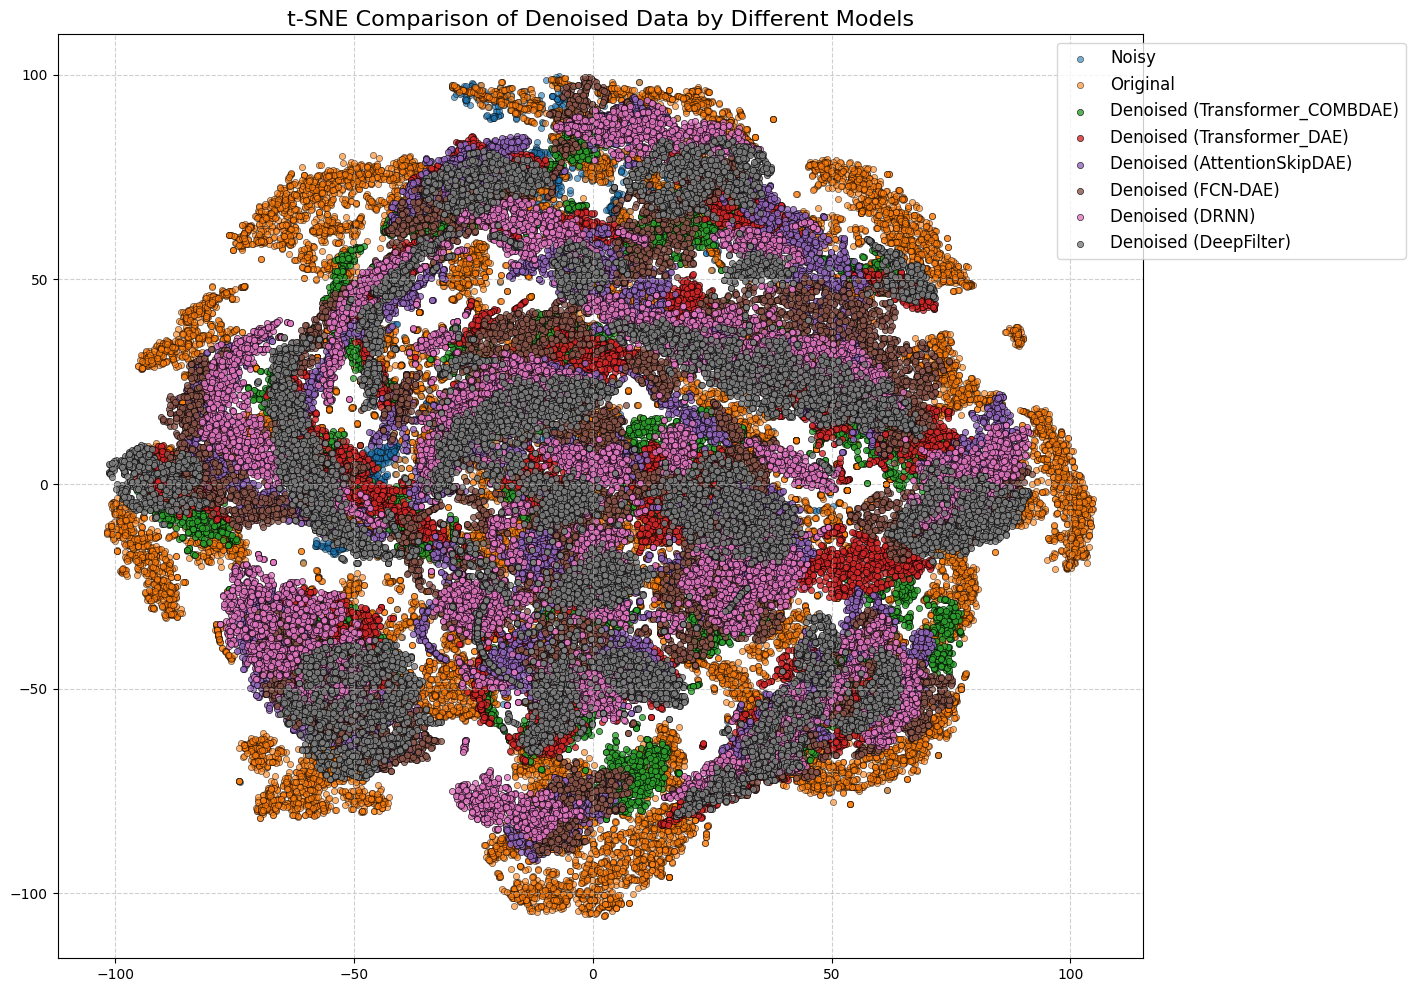

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn color palette 설정 (더 뚜렷한 색상 사용)
sns.set_palette("bright")  # "bright" 팔레트는 색상 대비가 강함
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# 모델 결과 로드
models = {
    "Transformer_COMBDAE": test_Transformer_COMBDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "FCN-DAE": test_FCN_DAE,
    "DRNN": test_DRNN,
    "DeepFilter": test_DeepFilter
}

# t-SNE 적용 및 시각화 함수
def plot_tsne_comparison(models):
    X_test, y_test, _ = list(models.values())[0]  # 기준 original/noisy 데이터
    combined_data = np.concatenate((X_test.reshape(X_test.shape[0], -1), y_test.reshape(y_test.shape[0], -1)))
    
    # t-SNE 변환 (original + noisy 데이터)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_data = tsne.fit_transform(combined_data)
    # n_samples = len(X_test)
    n_samples = 2000
    
    # 시각화 설정
    plt.figure(figsize=(14, 12))
    plt.scatter(reduced_data[:n_samples, 0], reduced_data[:n_samples, 1], alpha=0.6, label='Noisy', c=colors[0], s=20, edgecolor='k', linewidth=0.5)
    plt.scatter(reduced_data[n_samples:, 0], reduced_data[n_samples:, 1], alpha=0.6, label='Original', c=colors[1], s=20, edgecolor='k', linewidth=0.5)
    
    # 모델별 denoised 결과 추가 시각화
    for i, (name, data) in enumerate(models.items()):
        _, _, y_pred = data
        y_pred_flattened = y_pred.reshape(y_pred.shape[0], -1)
        y_pred_reduced = tsne.fit_transform(y_pred_flattened)
        
        plt.scatter(y_pred_reduced[:, 0], y_pred_reduced[:, 1], alpha=0.8, label=f'Denoised ({name})', s=20, c=colors[i+2], edgecolor='k', linewidth=0.5)

    plt.title("t-SNE Comparison of Denoised Data by Different Models", fontsize=16)
    plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.25, 1))  # 범례 위치 조정
    plt.grid(True, linestyle='--', alpha=0.6)  # 그리드 추가
    plt.show()

# t-SNE 시각화 실행
plot_tsne_comparison(models)

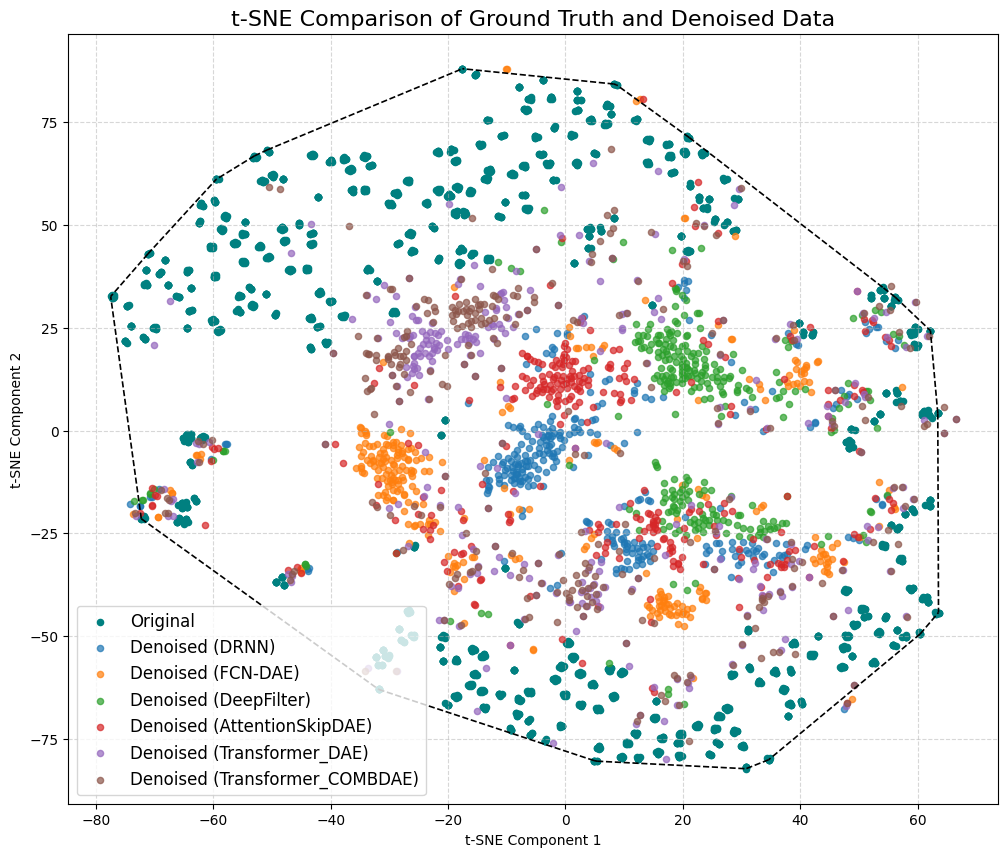

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 모델 결과 로드 (예: Transformer_DAE, Transformer_COMBDAE)
models = {
    "DRNN": test_DRNN,
    "FCN-DAE": test_FCN_DAE,
    "DeepFilter": test_DeepFilter,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "Transformer_COMBDAE": test_Transformer_COMBDAE
}

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull

# t-SNE 시각화 함수 (개선된 버전)
def plot_tsne_comparison_with_hull(models, n_samples=300):
    """
    Visualize the t-SNE comparison of ground truth and denoised data from different models.
    Ground truth is highlighted with a convex hull.
    """
    combined_data = []
    labels = []

    for i, (name, data) in enumerate(models.items()):
        X_test, y_pred = data[1], data[2]
        combined_data.append(X_test[:n_samples].reshape(n_samples, -1))
        combined_data.append(y_pred[:n_samples].reshape(n_samples, -1))
        labels.extend(["Original"] * n_samples)
        labels.extend([f"Denoised ({name})"] * n_samples)
    
    combined_data = np.vstack(combined_data)
    
    # t-SNE 적용
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_data = tsne.fit_transform(combined_data)
    
    # 시각화
    plt.figure(figsize=(12, 10))
    colors = {
        "Original": "teal",                  
        "Denoised (DRNN)": "#1f77b4",        
        "Denoised (FCN-DAE)": "#ff7f0e",     
        "Denoised (DeepFilter)": "#2ca02c",  
        "Denoised (AttentionSkipDAE)": "#d62728",
        "Denoised (Transformer_DAE)": "#9467bd",
        "Denoised (Transformer_COMBDAE)": "#8c564b"
    }


    # Ground Truth 시각화 (Convex Hull 추가)
    original_indices = [i for i, lbl in enumerate(labels) if lbl == "Original"]
    original_points = reduced_data[original_indices]
    plt.scatter(original_points[:, 0], original_points[:, 1], c=colors["Original"], s=20, label="Original")
    
    hull = ConvexHull(original_points)
    for simplex in hull.simplices:
        plt.plot(original_points[simplex, 0], original_points[simplex, 1], "k--", lw=1.2)
    
    # Denoised 데이터 시각화
    for name in models.keys():
        denoised_indices = [i for i, lbl in enumerate(labels) if lbl == f"Denoised ({name})"]
        plt.scatter(reduced_data[denoised_indices, 0], reduced_data[denoised_indices, 1], 
                    c=colors[f"Denoised ({name})"], alpha=0.7, s=20, label=f"Denoised ({name})")
    
    plt.title("t-SNE Comparison of Ground Truth and Denoised Data", fontsize=16)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(fontsize=12, loc="best")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# 실행
plot_tsne_comparison_with_hull(models)


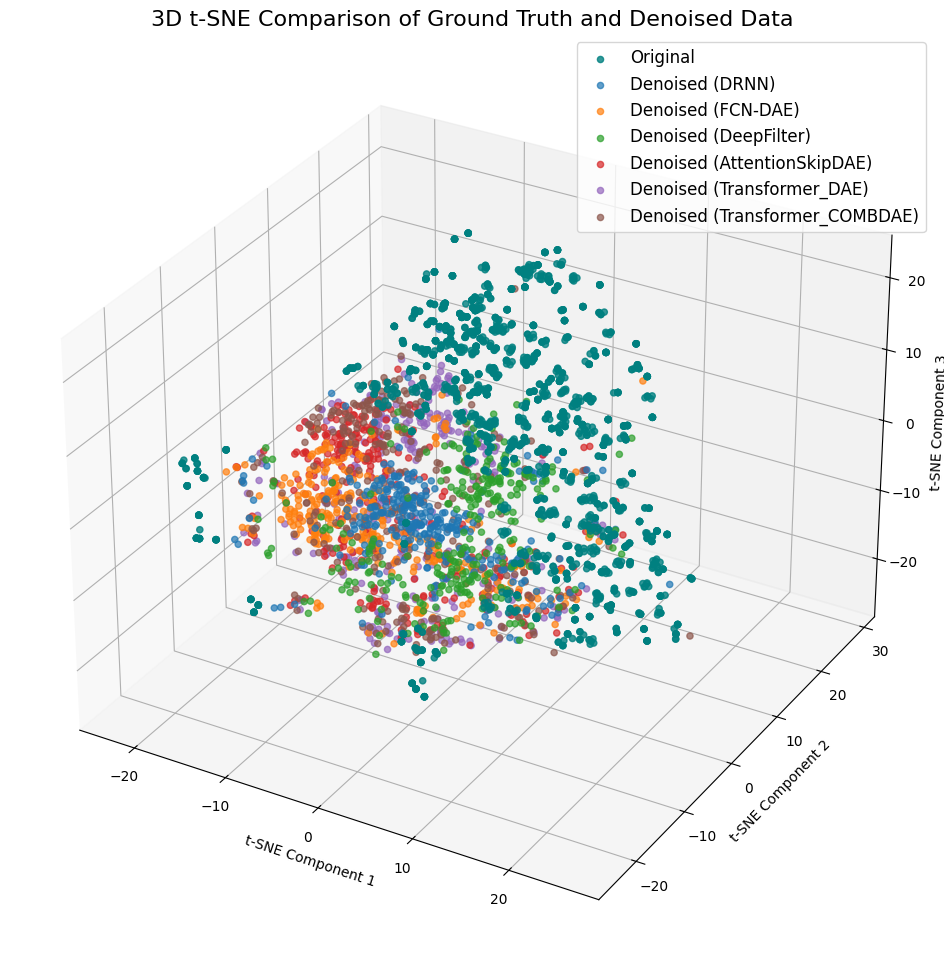

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
from sklearn.manifold import TSNE

def plot_tsne_3d_comparison(models, n_samples=300):
    """
    3D t-SNE comparison of ground truth and denoised data from different models.
    """
    combined_data = []
    labels = []

    for i, (name, data) in enumerate(models.items()):
        X_test, y_pred = data[1], data[2]
        combined_data.append(X_test[:n_samples].reshape(n_samples, -1))
        combined_data.append(y_pred[:n_samples].reshape(n_samples, -1))
        labels.extend(["Original"] * n_samples)
        labels.extend([f"Denoised ({name})"] * n_samples)
    
    combined_data = np.vstack(combined_data)
    
    # Apply t-SNE in 3D
    tsne = TSNE(n_components=3, perplexity=30, random_state=42)
    reduced_data = tsne.fit_transform(combined_data)
    
    # Create a 3D plot
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')
    colors = {
        "Original": "teal",
        "Denoised (DRNN)": "#1f77b4",
        "Denoised (FCN-DAE)": "#ff7f0e",
        "Denoised (DeepFilter)": "#2ca02c",
        "Denoised (AttentionSkipDAE)": "#d62728",
        "Denoised (Transformer_DAE)": "#9467bd",
        "Denoised (Transformer_COMBDAE)": "#8c564b"
    }

    # Plot the original data
    original_indices = [i for i, lbl in enumerate(labels) if lbl == "Original"]
    ax.scatter(reduced_data[original_indices, 0], reduced_data[original_indices, 1], reduced_data[original_indices, 2], 
               c=colors["Original"], label="Original", alpha=0.8, s=20)
    
    # Plot the denoised data for each model
    for name in models.keys():
        denoised_indices = [i for i, lbl in enumerate(labels) if lbl == f"Denoised ({name})"]
        ax.scatter(reduced_data[denoised_indices, 0], reduced_data[denoised_indices, 1], reduced_data[denoised_indices, 2], 
                   c=colors[f"Denoised ({name})"], label=f"Denoised ({name})", alpha=0.7, s=20)
    
    # Customize plot appearance
    ax.set_title("3D t-SNE Comparison of Ground Truth and Denoised Data", fontsize=16)
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.set_zlabel("t-SNE Component 3")
    ax.legend(fontsize=12, loc="best")
    plt.show()

# 실행
plot_tsne_3d_comparison(models)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from vg_beat_detectors import FastNVG  # Import the FastNVG detector

def plot_concatenated_r_peaks(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig7", max_samples=8):
    """
    Concatenate samples and plot R-peak detection for ground truth and denoised signals.

    :param y_test: Ground truth signals.
    :param y_pred: Denoised signals.
    :param model_name: Name of the model.
    :param sampling_rate: Sampling rate of the signals.
    :param save_dir: Directory to save the plots.
    :param max_samples: Maximum number of samples to concatenate.
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Concatenate a limited number of samples
    y_test_concat = np.concatenate([y.flatten() for y in y_test[1032:1032+max_samples]])
    y_pred_concat = np.concatenate([y.flatten() for y in y_pred[1032:1032+max_samples]])
    
    # Initialize the FastNVG detector
    detector = FastNVG(sampling_frequency=sampling_rate)
    gt_peaks = detector.find_peaks(y_test_concat)
    denoised_peaks = detector.find_peaks(y_pred_concat)

    # Plot the concatenated signals
    plt.figure(figsize=(24, 16))

    # Add red grid lines
    y_min, y_max = min(y_test_concat.min(), y_pred_concat.min()), max(y_test_concat.max(), y_pred_concat.max())
    signal_length = len(y_test_concat)
    
    for x in np.arange(0, signal_length, sampling_rate * 0.2):  # Vertical bold lines every 0.2s
        plt.axvline(x=x, color='red', linestyle='-', alpha=0.7, linewidth=0.8)
    for x in np.arange(0, signal_length, sampling_rate * 0.04):  # Vertical thin lines every 0.04s
        plt.axvline(x=x, color='red', linestyle='-', alpha=0.3, linewidth=0.5)
    # for y in np.arange(y_min, y_max, 0.5):  # Horizontal bold lines every 0.5mV
    #     plt.axhline(y=y, color='red', linestyle='-', alpha=0.7, linewidth=0.8)
    for y in np.arange(y_min, y_max, 0.1):  # Horizontal thin lines every 0.1mV
        plt.axhline(y=y, color='red', linestyle='-', alpha=0.3, linewidth=0.5)

    # Plot Ground Truth signal
    plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=2)
    plt.scatter(gt_peaks, y_test_concat[gt_peaks], color="blue", s=100, label="R-Peaks (Ground Truth)", zorder=5)  # 크기 증가 및 색상 변경

    # Plot Denoised signal
    plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=2)
    plt.scatter(denoised_peaks, y_pred_concat[denoised_peaks], color="red", s=100, label="R-Peaks (Denoised)", zorder=5)

    # Draw dashed lines for R-peak differences and annotate Δ values
    for gt, den in zip(gt_peaks, denoised_peaks):
        plt.axvline(x=gt, color="blue", linestyle="--", alpha=0.5)
        plt.axvline(x=den, color="red", linestyle="--", alpha=0.5)
        delta_time = abs(gt - den) / sampling_rate
        plt.text((gt + den) / 2, max(y_test_concat.max(), y_pred_concat.max()) * 0.8,
                 f"Δ = {delta_time:.2f}s", ha="center", va="bottom", fontsize=10, color="purple")

    # Add labels, legend, and grid
    plt.title(f"Concatenated R-Peak Detection - {model_name}", fontsize=24, fontweight="bold")
    plt.xlabel("Samples (N)", fontsize=20)
    plt.ylabel("Amplitude (au)", fontsize=20)
    plt.legend(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Set x-axis limits to start at 0 and end at the signal length
    plt.xlim(0, signal_length)

    # Save the plot
    save_path = os.path.join(save_dir, f"{model_name}_R_Peaks_Comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved concatenated R-peak plot for {model_name}: {save_path}")

# Example usage
for model_name, test_model in model_results.items():
    y_test, y_pred = test_model[1], test_model[2]

    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)
    # metrics, debug_logs, debug_plots = calculate_rr_accuracy_with_mape(y_test, y_pred)

    # print(f"Model: {model_name}\nMetrics: {metrics}\n")
    plot_concatenated_r_peaks(y_test, y_pred, model_name)


NameError: name 'model_results' is not defined

### r peak

GT에 R-peak가 없거나 Denoised 신호에만 R-peak가 존재하는 경우를 처리하는 논리를 추가

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from vg_beat_detectors import FastNVG


def calculate_peak_detection_accuracy(y_test, y_pred, sampling_rate=360, tolerance=0.05):
    """
    Calculate Peak Detection Accuracy assuming Ground Truth R-peaks always exist.
    :param y_test: Ground truth ECG signals.
    :param y_pred: Denoised ECG signals.
    :param sampling_rate: Sampling rate of the signals.
    :param tolerance: Time tolerance for matching peaks (in seconds).
    :return: Metrics (Accuracy, Precision, Recall, F1-score).
    """
    detector = FastNVG(sampling_frequency=sampling_rate)
    tp, fp, fn = 0, 0, 0

    for ground_truth, denoised in zip(y_test, y_pred):
        ground_truth = ground_truth.flatten()
        denoised = denoised.flatten()

        # Detect R-peaks
        gt_peaks = detector.find_peaks(ground_truth)
        denoised_peaks = detector.find_peaks(denoised)

        gt_times = np.array(gt_peaks) / sampling_rate
        denoised_times = np.array(denoised_peaks) / sampling_rate

        # If both GT and denoised peaks exist
        if len(gt_times) > 0 and len(denoised_times) > 0:
            matched_gt = set()
            for den_time in denoised_times:
                # Check if any GT falls within tolerance
                matches = np.abs(gt_times - den_time) <= tolerance
                if any(matches):
                    tp += 1  # Matched peaks are True Positives
                    matched_gt.add(np.where(matches)[0][0])  # Store matched GT index
                else:
                    fp += 1  # Unmatched denoised peak is a False Positive

            # GT peaks not matched by any denoised peaks are False Negatives
            fn += len(gt_times) - len(matched_gt)
        else:
            # If only one of them has R-peaks
            fn += len(gt_times)
            fp += len(denoised_times)

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
    }


# def plot_r_peak_detection(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig8", max_samples=8):
#     """
#     Plot R-peak detection results including TP, FP, FN.
#     :param y_test: Ground truth ECG signals.
#     :param y_pred: Denoised ECG signals.
#     :param model_name: Name of the model.
#     :param sampling_rate: Sampling rate of the signals.
#     :param save_dir: Directory to save the plot.
#     :param max_samples: Number of samples to concatenate for visualization.
#     """
#     os.makedirs(save_dir, exist_ok=True)

#     # Concatenate a limited number of samples
#     y_test_concat = np.concatenate([y.flatten() for y in y_test[:max_samples]])
#     y_pred_concat = np.concatenate([y.flatten() for y in y_pred[:max_samples]])

#     # Detect R-peaks
#     detector = FastNVG(sampling_frequency=sampling_rate)
#     gt_peaks = detector.find_peaks(y_test_concat)
#     denoised_peaks = detector.find_peaks(y_pred_concat)

#     # Convert to time
#     gt_times = np.array(gt_peaks) / sampling_rate
#     denoised_times = np.array(denoised_peaks) / sampling_rate

#     # Match peaks within tolerance
#     tolerance = 0.05
#     tp_indices, fp_indices, fn_indices = [], [], []

#     matched_gt = set()
#     for den_idx, den_time in enumerate(denoised_times):
#         matches = np.abs(gt_times - den_time) <= tolerance
#         if any(matches):
#             tp_indices.append(den_idx)
#             matched_gt.add(np.where(matches)[0][0])
#         else:
#             fp_indices.append(den_idx)

#     fn_indices = [idx for idx in range(len(gt_times)) if idx not in matched_gt]

#     # Plot the signals and detected peaks
#     plt.figure(figsize=(24, 12))  # 그림 크기 확대
#     plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=3)  # Ground Truth 두께 확대
#     plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=3)  # Denoised 두께 확대

#     # Plot TP, FP, FN
#     plt.scatter(
#         gt_peaks[list(matched_gt)],
#         y_test_concat[gt_peaks[list(matched_gt)]],
#         color="green",
#         label="True Positives (TP)",
#         s=200,  # TP 크기 확대
#         marker="o",
#         zorder=5,
#     )
#     plt.scatter(
#         [denoised_peaks[idx] for idx in fp_indices],
#         y_pred_concat[[denoised_peaks[idx] for idx in fp_indices]],
#         color="black",
#         label="False Positives (FP)",
#         s=200,  # FP 크기 확대
#         marker="x",
#         zorder=5,
#     )
#     plt.scatter(
#         [gt_peaks[idx] for idx in fn_indices],
#         y_test_concat[[gt_peaks[idx] for idx in fn_indices]],
#         color="purple",
#         label="False Negatives (FN)",
#         s=200,  # FN 크기 확대
#         marker="^",
#         zorder=5,
#     )

#     # Add titles and labels
#     plt.title(f"R-Peak Detection - {model_name}", fontsize=40, pad=30, fontweight='bold')  # 제목 폰트 크기 확대
#     plt.xlabel("Samples (N)", fontsize=30, labelpad=20)  # x축 라벨 크기 확대
#     plt.ylabel("Amplitude (au)", fontsize=30, labelpad=20)  # y축 라벨 크기 확대
#     plt.tick_params(axis="both", which="major", labelsize=20)  # 축 눈금 크기 확대
#     plt.legend(fontsize=25, loc="lower left")  # 범례 크기 확대 및 위치 조정
#     plt.grid(True, linestyle="--", alpha=0.7)

#     # Save the plot
#     save_path = os.path.join(save_dir, f"{model_name}_R_Peak_Detection.png")
#     plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 여백 조정
#     plt.close()
#     print(f"Saved R-peak detection plot for {model_name}: {save_path}")
def plot_r_peak_detection(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig8", max_samples=8):
    """
    Plot R-peak detection results including TP, FP, FN with enhanced visualization.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Concatenate a limited number of samples
    y_test_concat = np.concatenate([y.flatten() for y in y_test[:max_samples]])
    y_pred_concat = np.concatenate([y.flatten() for y in y_pred[:max_samples]])

    # Detect R-peaks
    detector = FastNVG(sampling_frequency=sampling_rate)
    gt_peaks = detector.find_peaks(y_test_concat)
    denoised_peaks = detector.find_peaks(y_pred_concat)

    # Convert to time
    gt_times = np.array(gt_peaks) / sampling_rate
    denoised_times = np.array(denoised_peaks) / sampling_rate

    # Match peaks within tolerance
    tolerance = 0.05
    tp_indices, fp_indices, fn_indices = [], [], []

    matched_gt = set()
    for den_idx, den_time in enumerate(denoised_times):
        matches = np.abs(gt_times - den_time) <= tolerance
        if any(matches):
            tp_indices.append(den_idx)
            matched_gt.add(np.where(matches)[0][0])
        else:
            fp_indices.append(den_idx)

    fn_indices = [idx for idx in range(len(gt_times)) if idx not in matched_gt]

    # Plot the signals and detected peaks
    plt.figure(figsize=(30, 15))  # 그림 크기 확대
    plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=4)  # Ground Truth 두께 확대
    plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=4)  # Denoised 두께 확대

    # Plot TP, FP, FN
    plt.scatter(
        gt_peaks[list(matched_gt)],
        y_test_concat[gt_peaks[list(matched_gt)]],
        color="green",
        label="True Positives (TP)",
        s=300,  # TP 크기 확대
        marker="o",
        zorder=5,
        edgecolors="black",  # 테두리 추가
        linewidths=2
    )
    plt.scatter(
        [denoised_peaks[idx] for idx in fp_indices],
        y_pred_concat[[denoised_peaks[idx] for idx in fp_indices]],
        color="black",
        label="False Positives (FP)",
        s=300,  # FP 크기 확대
        marker="x",
        zorder=5,
        linewidths=3  # FP 선 굵기 확대
    )
    plt.scatter(
        [gt_peaks[idx] for idx in fn_indices],
        y_test_concat[[gt_peaks[idx] for idx in fn_indices]],
        color="purple",
        label="False Negatives (FN)",
        s=300,  # FN 크기 확대
        marker="^",
        zorder=5,
        edgecolors="black",  # 테두리 추가
        linewidths=2
    )

    # Add titles and labels
    plt.title(f"R-Peak Detection - {model_name}", fontsize=50, pad=30, fontweight='bold')  # 제목 폰트 크기 확대
    plt.xlabel("Samples (N)", fontsize=40, labelpad=20)  # x축 라벨 크기 확대
    plt.ylabel("Amplitude (au)", fontsize=40, labelpad=20)  # y축 라벨 크기 확대
    plt.tick_params(axis="both", which="major", labelsize=30)  # 축 눈금 크기 확대
    plt.legend(fontsize=18, loc="upper left", frameon=True, shadow=True, fancybox=True)  # 범례 크기 및 스타일 조정
    plt.grid(True, linestyle="--", alpha=0.7)

    # Save the plot
    save_path = os.path.join(save_dir, f"{model_name}_R_Peak_Detection.png")
    plt.savefig(save_path, bbox_inches="tight")  # 해상도 향상 및 여백 조정
    plt.close()
    print(f"Saved R-peak detection plot for {model_name}: {save_path}")



# Loop through each model and calculate metrics
for model_name, test_model in model_results.items():
    y_test, y_pred = test_model[1], test_model[2]

    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)

    # Calculate metrics
    metrics = calculate_peak_detection_accuracy(y_test, y_pred)
    print(f"Model: {model_name}\nMetrics: {metrics}\n")

    # Plot TP, FP, FN
    plot_r_peak_detection(y_test, y_pred, model_name)


NameError: name 'model_results' is not defined

# EXPERIMENT

기본 성능평가가

In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['CNN_DAE', 'DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0221_FIXED/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_CNN_DAE = pickle.load(input)
with open('0221_FIXED/test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0221_FIXED/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0221_FIXED/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0221_FIXED/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0221_FIXED/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0221_FIXED/test_results_'  + dl_experiments[6] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE

# CNN_DAE
[X_test, y_test, y_pred] = test_CNN_DAE
RMSE_values_DL_CNN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_CNN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_CNN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_CNN_DAE = SNR(y_test, y_pred)

# DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
RMSE_values_FIR = RMSE(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
RMSE_values_IIR = RMSE(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)

####### Results Visualization #######
RMSE_all = [RMSE_values_FIR,
            RMSE_values_IIR,
            RMSE_values_DL_CNN_DAE,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_CNN_DAE,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_CNN_DAE,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_CNN_DAE,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.321 (0.262) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 0.301 (0.251) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|       CNN_DAE       | 0.091 (0.051) | 52.160 (29.385) | 0.873 (0.141) | 7.563 (3.564)  |
|         DRNN        | 0.080 (0.045) | 46.195 (29.824) | 0.895 (0.139) | 8.693 (3.985)  |
|       FCN-DAE       | 0.077 (0.041) | 50.270 (36.779) | 0.891 (0.149) | 8.968 (4.662)  |
|      DeepFilter     | 0.065 (0.033) | 41.965 (31.314) | 0.917 (0.121) | 10.243 (4.531) |
|   AttentionSkipDAE  | 0.070 (0.046) | 37.824 (23.404) | 0.920 (0.124) | 10.295 (4.721) |
|   Transformer_DAE   | 0.057 (0.035) | 31.361 (20.647) | 0.940 

In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0223/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0223/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0223/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0223/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0223/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0223/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE

# DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
RMSE_values_FIR = RMSE(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
RMSE_values_IIR = RMSE(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)

####### Results Visualization #######
RMSE_all = [RMSE_values_FIR,
            RMSE_values_IIR,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.321 (0.262) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 0.301 (0.251) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        | 0.087 (0.050) | 49.842 (32.180) | 0.878 (0.147) | 8.098 (4.113)  |
|       FCN-DAE       | 0.082 (0.042) | 55.611 (37.532) | 0.891 (0.143) | 8.348 (3.991)  |
|      DeepFilter     | 0.070 (0.033) | 45.524 (33.639) | 0.908 (0.119) | 9.560 (4.245)  |
|   AttentionSkipDAE  | 0.075 (0.045) | 41.358 (23.830) | 0.912 (0.127) | 9.460 (4.419)  |
|   Transformer_DAE   | 0.061 (0.037) | 32.642 (20.610) | 0.934 (0.107) | 11.231 (4.859) |
| Transformer_COMBDAE | 0.057 (0.032) | 30.842 (18.867) | 0.938 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import welch
import pickle
import os

# === FFT & PSD 계산 함수 === #
def compute_fft(signal, fs=360):
    """전체 샘플의 평균 FFT 계산"""
    N = signal.shape[1]  # 샘플 길이 (512)
    freq = np.fft.fftfreq(N, d=1/fs)[:N//2]  # 양수 주파수만
    fft_magnitude = np.abs(fft(signal, axis=1))[:, :N//2]  # 각 샘플에 대해 FFT 수행 후 절댓값
    mean_fft = np.mean(fft_magnitude, axis=0)  # 전체 샘플 평균
    return freq, mean_fft

def compute_psd(signal, fs=360):
    """전체 샘플의 평균 PSD 계산"""
    psd_list = []
    freq, _ = welch(signal[0], fs=fs, nperseg=256)  # 주파수 축 설정
    for i in range(signal.shape[0]):
        _, psd = welch(signal[i], fs=fs, nperseg=256)
        psd_list.append(psd)
    mean_psd = np.mean(np.array(psd_list), axis=0)  # 전체 샘플 평균
    return freq, mean_psd

# === 모델 및 SNR 폴더 설정 === #
save_dir = "fig16"
snr_folders = ["0221_FIXED", "0221_snr0db", "0221_snr3db", "0221_snr6db"]
dl_models = ["DRNN", "FCN-DAE", "DeepFilter", "AttentionSkipDAE", "Transformer_DAE", "Transformer_COMBDAE"]

# === 모델별 주파수 분석 === #
for dl_model in dl_models:
    fig, axes = plt.subplots(len(snr_folders), 2, figsize=(12, 18))  # FFT & PSD 비교 (2개 컬럼)
    
    for i, snr_folder in enumerate(snr_folders):
        try:
            # === 데이터 로드 === #
            with open(f"{snr_folder}/test_results_{dl_model}.pkl", "rb") as f:
                X_test, y_test, y_pred = pickle.load(f)

            X_test = np.squeeze(X_test)  # (13316, 512)
            y_test = np.squeeze(y_test)
            y_pred = np.squeeze(y_pred)

            # === 전체 샘플 평균 FFT 계산 === #
            freq, fft_y_test = compute_fft(y_test)
            _, fft_X_test = compute_fft(X_test)
            _, fft_y_pred = compute_fft(y_pred)

            # === 전체 샘플 평균 PSD 계산 === #
            freq_psd, psd_y_test = compute_psd(y_test)
            _, psd_X_test = compute_psd(X_test)
            _, psd_y_pred = compute_psd(y_pred)

            # === FFT 비교 플롯 === #
            axes[i, 0].plot(freq, fft_y_test, label="Original", color="red")
            axes[i, 0].plot(freq, fft_X_test, label="Noisy", color="blue", alpha=0.6)
            axes[i, 0].plot(freq, fft_y_pred, label="Reconstructed", color="green")
            axes[i, 0].set_title(f"{dl_model} - {snr_folder} FFT (Mean)", fontsize=14)
            axes[i, 0].set_xlabel("Frequency (Hz)")
            axes[i, 0].set_ylabel("Amplitude")
            axes[i, 0].legend()

            # === PSD 비교 플롯 === #
            axes[i, 1].semilogy(freq_psd, psd_y_test, label="Original", color="red")
            axes[i, 1].semilogy(freq_psd, psd_X_test, label="Noisy", color="blue", alpha=0.6)
            axes[i, 1].semilogy(freq_psd, psd_y_pred, label="Reconstructed", color="green")
            axes[i, 1].set_title(f"{dl_model} - {snr_folder} PSD (Mean)", fontsize=14)
            axes[i, 1].set_xlabel("Frequency (Hz)")
            axes[i, 1].set_ylabel("Power Spectral Density (dB/Hz)")
            axes[i, 1].legend()

        except FileNotFoundError:
            print(f"[WARNING] {snr_folder}/test_results_{dl_model}.pkl not found. Skipping...")

    plt.tight_layout()
    save_path = os.path.join(save_dir, f"{dl_model}_frequency_analysis_mean.png")
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"[INFO] Frequency analysis saved: {save_path}")


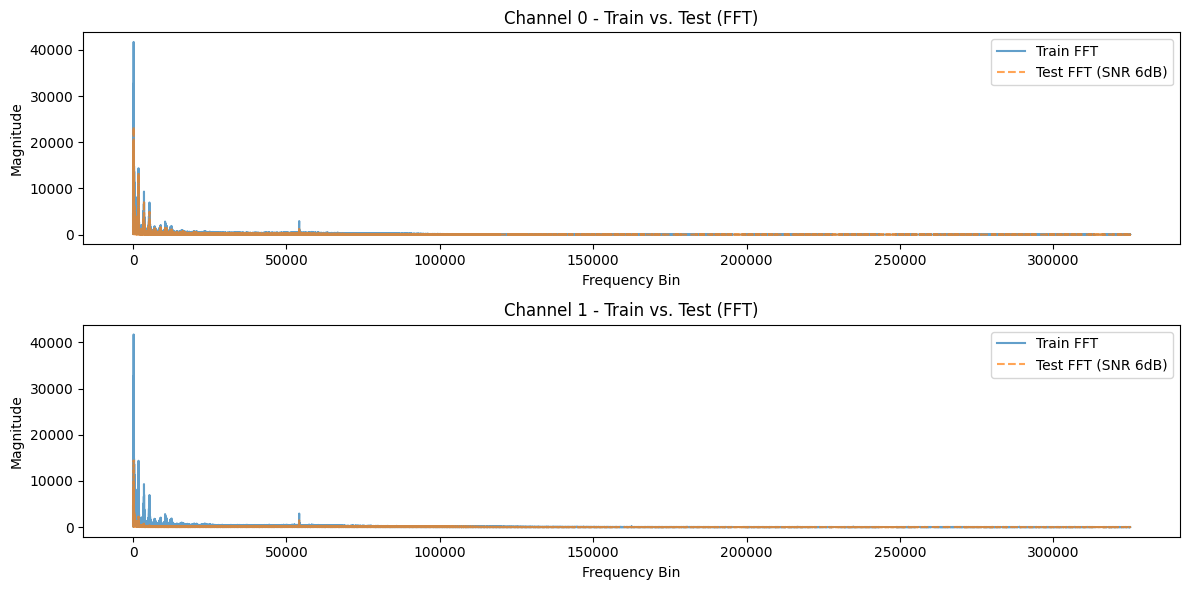

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.fft import fft

# Train 데이터 불러오기
with open('data/CombinedNoise_Train.pkl', 'rb') as f:
    train_noise = pickle.load(f)

# Test 데이터 불러오기 (SNR 0, 6, 12 중 하나 선택)
with open('data/Mixed_Noise_SNR_6.pkl', 'rb') as f:
    test_noise = pickle.load(f).squeeze(-1)  # Shape: (2, 650000)

# FFT 계산
train_fft = np.abs(fft(train_noise, axis=0))
test_fft = np.abs(fft(test_noise, axis=1))

# FFT 결과의 절반만 사용
train_fft_half = train_fft[:len(train_fft)//2]
test_fft_half = test_fft[:, :test_fft.shape[1]//2]

# 주파수 도메인 비교 시각화
plt.figure(figsize=(12, 6))
for ch in range(2):
    plt.subplot(2, 1, ch + 1)
    plt.plot(train_fft_half, label="Train FFT", alpha=0.7)
    plt.plot(test_fft_half[ch], label="Test FFT (SNR 6dB)", alpha=0.7, linestyle='dashed')
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.title(f"Channel {ch} - Train vs. Test (FFT)")
    plt.legend()

plt.tight_layout()
plt.show()

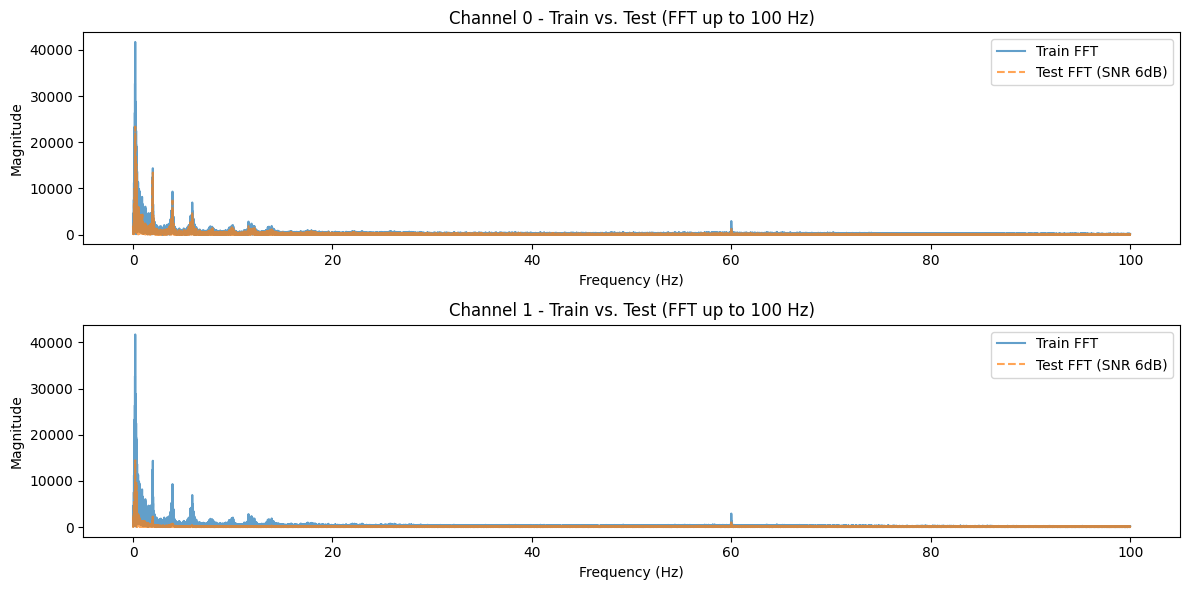

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.fft import fft

# 샘플링 주파수 (예시: 1000 Hz)
fs = 360  # 이 값을 실제 샘플링 주파수로 변경하세요.

# Train 데이터 불러오기
with open('data/CombinedNoise_Train.pkl', 'rb') as f:
    train_noise = pickle.load(f)

# Test 데이터 불러오기 (SNR 0, 6, 12 중 하나 선택)
with open('data/Mixed_Noise_SNR_6.pkl', 'rb') as f:
    test_noise = pickle.load(f).squeeze(-1)  # Shape: (2, 650000)

# FFT 계산
train_fft = np.abs(fft(train_noise, axis=0))
test_fft = np.abs(fft(test_noise, axis=1))

# FFT 결과의 절반만 사용
train_fft_half = train_fft[:len(train_fft)//2]
test_fft_half = test_fft[:, :test_fft.shape[1]//2]

# 주파수 축 생성
N_train = len(train_fft_half)
N_test = test_fft_half.shape[1]
freq_train = np.linspace(0, fs, N_train)  # Train 데이터 주파수 축
freq_test = np.linspace(0, fs, N_test)    # Test 데이터 주파수 축

# 100 Hz에 해당하는 빈 찾기
max_bin_train = int(100 / (fs / N_train))  # Train 데이터에서 100 Hz에 해당하는 빈
max_bin_test = int(100 / (fs / N_test))    # Test 데이터에서 100 Hz에 해당하는 빈

# 주파수 도메인 비교 시각화 (100 Hz까지)
plt.figure(figsize=(12, 6))
for ch in range(2):
    plt.subplot(2, 1, ch + 1)
    plt.plot(freq_train[:max_bin_train], train_fft_half[:max_bin_train], label="Train FFT", alpha=0.7)
    plt.plot(freq_test[:max_bin_test], test_fft_half[ch, :max_bin_test], label="Test FFT (SNR 6dB)", alpha=0.7, linestyle='dashed')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(f"Channel {ch} - Train vs. Test (FFT up to 100 Hz)")
    plt.legend()

plt.tight_layout()
plt.show()

/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: U

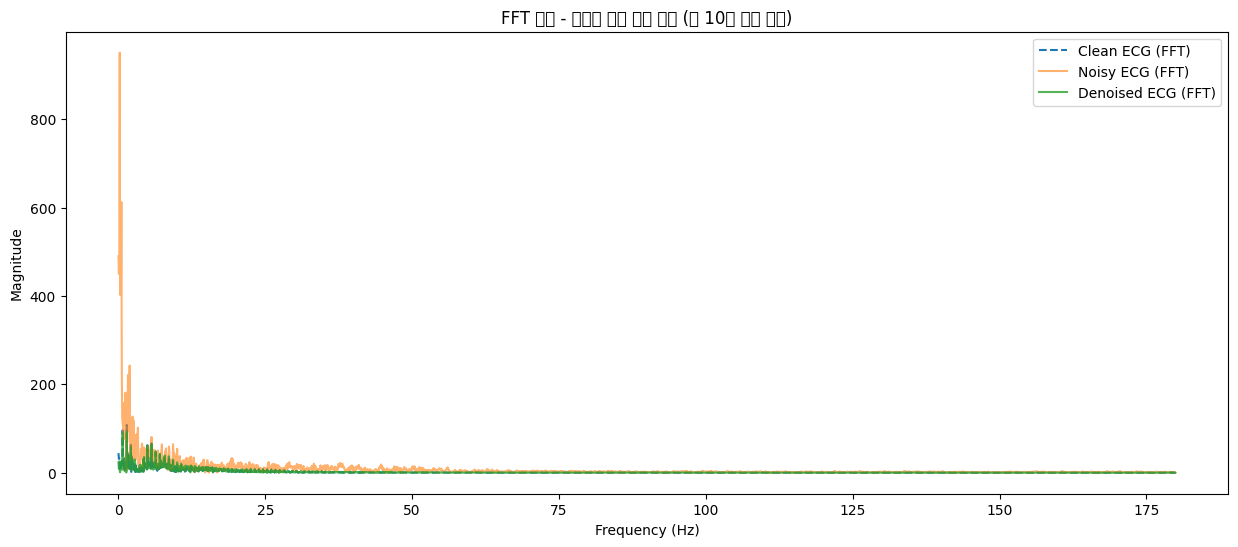

In [ ]:
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

# 여러 개 샘플을 연결하여 긴 신호 생성
num_samples = 10  # 붙일 샘플 개수
total_noisy = np.concatenate([X_test[i].squeeze() for i in range(num_samples)], axis=0)
total_clean = np.concatenate([y_test[i].squeeze() for i in range(num_samples)], axis=0)
total_denoised = np.concatenate([y_pred[i].squeeze() for i in range(num_samples)], axis=0)

# FFT 변환
noisy_fft = np.abs(fft(total_noisy))
clean_fft = np.abs(fft(total_clean))
denoised_fft = np.abs(fft(total_denoised))

# 주파수 축 생성
freq_bins = np.fft.fftfreq(len(clean_fft), d=1/360)  # 360Hz 샘플링 기준

# 주파수 도메인 비교
plt.figure(figsize=(15, 6))
plt.plot(freq_bins[:len(freq_bins)//2], clean_fft[:len(freq_bins)//2], label="Clean ECG (FFT)", linestyle="dashed")
plt.plot(freq_bins[:len(freq_bins)//2], noisy_fft[:len(freq_bins)//2], label="Noisy ECG (FFT)", alpha=0.6)
plt.plot(freq_bins[:len(freq_bins)//2], denoised_fft[:len(freq_bins)//2], label="Denoised ECG (FFT)", alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title(f"FFT 비교 - 노이즈 제거 전후 변화 (총 {num_samples}개 샘플 합산)")
plt.legend()
plt.show()


In [ ]:
# === QTDataset에서 'sel123' 찾기 === #
with open('data/QTDatabase.pkl', 'rb') as input:
    qtdb = pickle.load(input)

# 첫 번째 차원의 크기
print(len(sel123_data))  # 2

# 두 번째 차원의 크기 (첫 번째 요소의 길이)
print(len(sel123_data[0])) 

643
512


In [ ]:
y_test.shape

(13316, 512, 1)

In [ ]:
# #비교 방식 수정
# → np.isin() 대신에 각 y_test[idx]와 sel123_data의 샘플 간 L2 norm 거리를 계산하여 일정 거리 이하인 샘플을 sel123_indices로 선택하면 됨.
sel123_data = qtdb["sel123"]  # 'sel123' 데이터 가져오기
sel123_data = np.array([s[:512] if len(s) >= 512 else np.pad(s, (0, 512 - len(s)), 'constant') for s in sel123_data])  # 길이 맞추기

print(f"[INFO] 'sel123' 데이터 크기: {sel123_data.shape}")  # (643, 512)

[INFO] 'sel123' 데이터 크기: (643, 512)


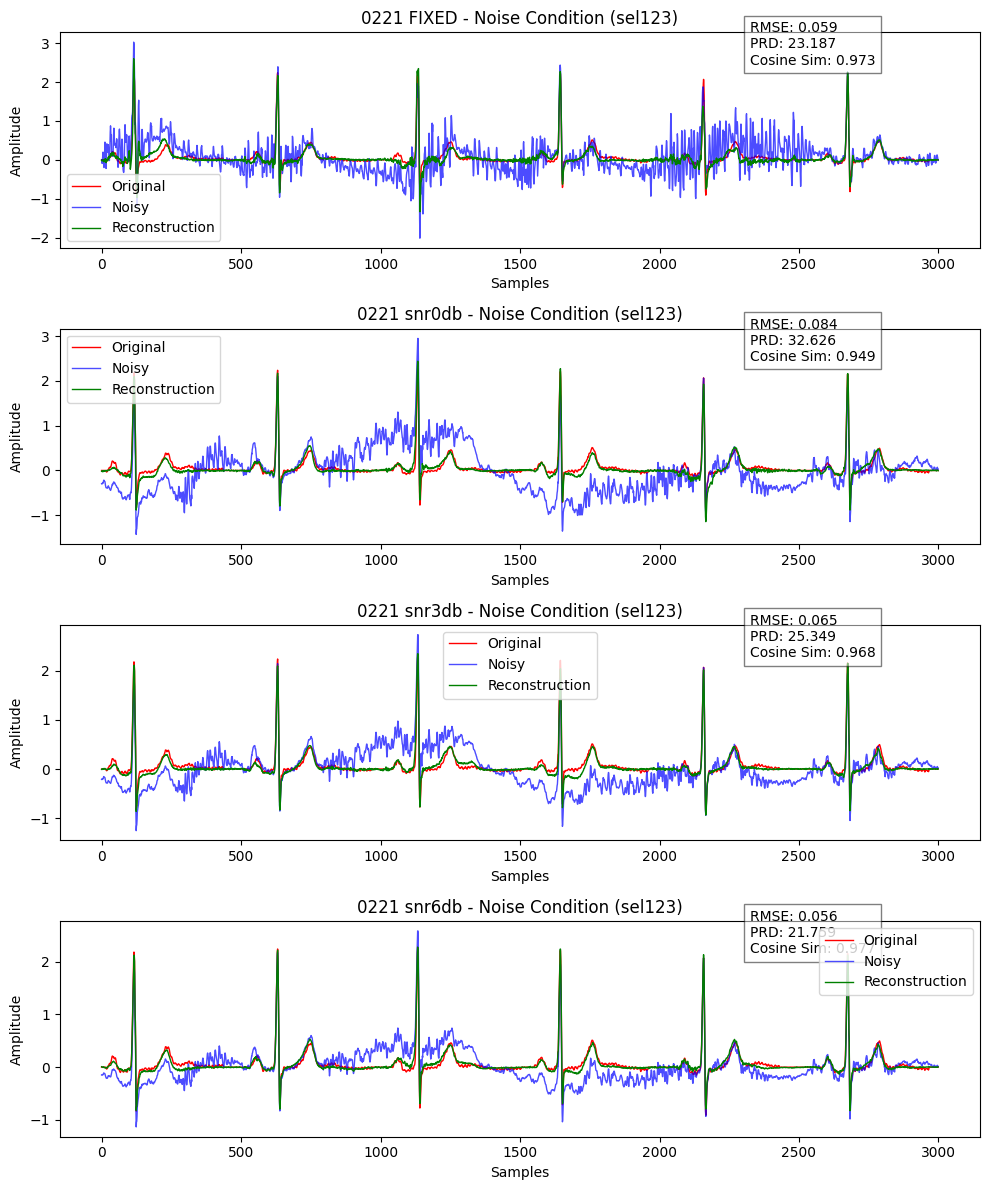

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error

# === SNR별 폴더 및 모델 정의 === #
snr_folders = ["0221_FIXED", "0221_snr0db","0221_snr3db", "0221_snr6db"]  # 다양한 SNR 폴더
dl_model = "Transformer_COMBDAE"  # 사용할 모델

# === 평가 지표 계산 함수 === #
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def PRD(y_true, y_pred):
    return 100 * np.sqrt(np.sum((y_true - y_pred) ** 2) / np.sum(y_true ** 2))

def Cosine_Similarity(y_true, y_pred):
    return 1 - cosine(y_true.flatten(), y_pred.flatten())

# === Reconstruction Metrics 저장용 리스트 === #
snr_results = []

# === 시각화 설정 === #
fig, axes = plt.subplots(len(snr_folders), 1, figsize=(10, 12))

# axes가 단일 객체인지 확인
if len(snr_folders) == 1:
    axes = [axes]  # axes를 리스트로 감싸서 처리

for i, snr_folder in enumerate(snr_folders):
    # === 모델 테스트 데이터 로드 === #
    with open(f"{snr_folder}/test_results_{dl_model}.pkl", "rb") as f:
        X_test, y_test, y_pred = pickle.load(f)

    y_test = np.squeeze(y_test)  # (N, 512) 형태로 변환
    X_test = np.squeeze(X_test)
    y_pred = np.squeeze(y_pred)

    # 'sel123'에 해당하는 데이터만 추출 (연결)
    sel123_range = slice(3213, 3833)  # sel123에 해당하는 인덱스 범위
    long_X_test = np.concatenate(X_test[sel123_range], axis=0)
    long_y_test = np.concatenate(y_test[sel123_range], axis=0)
    long_y_pred = np.concatenate(y_pred[sel123_range], axis=0)

    # === Reconstruction Metrics 계산 === #
    rmse_value = RMSE(long_y_test, long_y_pred)
    prd_value = PRD(long_y_test, long_y_pred)
    cos_sim_value = Cosine_Similarity(long_y_test, long_y_pred)

    # 결과 저장 (SNR별 성능 비교용)
    snr_results.append([snr_folder.replace("0221_", ""), rmse_value, prd_value, cos_sim_value])

    # === 일부 구간만 시각화 (너무 길면 보기 어려우므로 일부 샘플 선택) === #
    vis_start = 0
    vis_end = 3000  # 3000개의 샘플만 보기

    ax = axes[i]
    ax.plot(long_y_test[vis_start:vis_end], label="Original", color="red", linewidth=1)
    ax.plot(long_X_test[vis_start:vis_end], label="Noisy", color="blue", linewidth=1, alpha=0.7)
    ax.plot(long_y_pred[vis_start:vis_end], label="Reconstruction", color="green", linewidth=1)

    ax.set_xlabel("Samples")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"{snr_folder.replace('_', ' ')} - Noise Condition (sel123)")
    ax.legend()

    # Reconstruction Metrics 추가
    ax.text(0.75, 0.85, f"RMSE: {rmse_value:.3f}\nPRD: {prd_value:.3f}\nCosine Sim: {cos_sim_value:.3f}", 
            transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# === 테이블 형태로 출력 === #
import pandas as pd
df_results = pd.DataFrame(snr_results, columns=["SNR", "RMSE", "PRD", "Cosine Similarity"])
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Reconstruction by SNR", dataframe=df_results)


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error

# === SNR별 폴더 및 모델 정의 === #
snr_folders = ["0221_FIXED", "0221_snr0db", "0221_snr3db", "0221_snr6db"]
snr_labels = ["Mixed", "0 dB", "3 dB", "6 dB"]  # Fixed → Mixed
dl_models = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE', 'Transformer_COMBDAE']

# === 평가 지표 계산 함수 === #
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def PRD(y_true, y_pred):
    return 100 * np.sqrt(np.sum((y_true - y_pred) ** 2) / np.sum(y_true ** 2))

def Cosine_Similarity(y_true, y_pred):
    return 1 - cosine(y_true.flatten(), y_pred.flatten())

# === Reconstruction Metrics 저장용 리스트 === #
all_results = []

# === Figure 저장 폴더 생성 === #
fig_save_path = "fig10"
os.makedirs(fig_save_path, exist_ok=True)

for j, dl_model in enumerate(dl_models):
    for i, (snr_folder, snr_label) in enumerate(zip(snr_folders, snr_labels)):
        # === 모델 테스트 데이터 로드 === #
        try:
            with open(f"{snr_folder}/test_results_{dl_model}.pkl", "rb") as f:
                X_test, y_test, y_pred = pickle.load(f)
        except FileNotFoundError:
            print(f"[ERROR] {snr_folder}/test_results_{dl_model}.pkl not found.")
            continue

        y_test = np.squeeze(y_test)  # (N, 512) 형태로 변환
        X_test = np.squeeze(X_test)
        y_pred = np.squeeze(y_pred)

        # 'sel123'에 해당하는 데이터만 추출 (연결)
        sel123_range = slice(3213, 3833)
        long_X_test = np.concatenate(X_test[sel123_range], axis=0)
        long_y_test = np.concatenate(y_test[sel123_range], axis=0)
        long_y_pred = np.concatenate(y_pred[sel123_range], axis=0)

        # === Reconstruction Metrics 계산 === #
        rmse_value = RMSE(long_y_test, long_y_pred)
        prd_value = PRD(long_y_test, long_y_pred)
        cos_sim_value = Cosine_Similarity(long_y_test, long_y_pred)

        # 결과 저장 (DataFrame 용)
        all_results.append([dl_model, snr_label, rmse_value, prd_value, cos_sim_value])

        # === 일부 구간만 시각화 === #
        vis_start = 0
        vis_end = 3000  # 3000개의 샘플만 보기
        fig, ax = plt.subplots(figsize=(8, 4))

        # Original (빨강, 두껍게)
        ax.plot(long_y_test[vis_start:vis_end], label="Original", color="#FF0000", linewidth=1.0, alpha=1.0)
        # Noisy (파랑, 연하게)
        ax.plot(long_X_test[vis_start:vis_end], label="Noisy", color="#0066FF", linewidth=0.7, alpha=0.7)
        # Denoised (녹색, 두껍게)
        ax.plot(long_y_pred[vis_start:vis_end], label="Denoised", color="#00CC00", linewidth=1.2, alpha=0.9)

        ax.set_xlabel("Samples", fontsize=12, fontweight='bold')
        ax.set_ylabel("Amplitude", fontsize=12, fontweight='bold')
        ax.set_title(f"{snr_label} Noise - {dl_model}", fontsize=14, fontweight='bold')

        # 범례 크기 조정 및 위치 조정
        ax.legend(fontsize=6, loc="lower right")

        # 배경 그리드 추가
        ax.grid(True, linestyle="--", alpha=0.6)

        # X축 값 표시 간격 조정 (500 단위)
        ax.set_xticks(np.linspace(0, vis_end, num=7))
        ax.set_xticklabels([f"{int(x)}" for x in np.linspace(0, vis_end, num=7)], fontsize=10)

        # 그래프 저장
        fig.savefig(os.path.join(fig_save_path, f"SNR_{snr_label.replace(' ', '')}_{dl_model}.png"), dpi=300)
        plt.close(fig)  # 메모리 절약을 위해 Figure 닫기

# === 테이블 형태로 저장 및 출력 === #
df_results = pd.DataFrame(all_results, columns=["Model", "SNR", "RMSE", "PRD", "Cosine Similarity"])
df_results_pivot = df_results.pivot(index="Model", columns="SNR", values=["RMSE", "PRD", "Cosine Similarity"])

# CSV 저장
df_results.to_csv(os.path.join(fig_save_path, "Reconstruction_Metrics.csv"), index=False)

# DataFrame 출력
print("\n=== Reconstruction Metrics by Model & SNR ===")
print(df_results_pivot)



=== Reconstruction Metrics by Model & SNR ===
                         RMSE                                      PRD  \
SNR                      0 dB      3 dB      6 dB     Mixed       0 dB   
Model                                                                    
AttentionSkipDAE     0.083266  0.066408  0.056241  0.069577  32.513175   
DRNN                 0.117914  0.094757  0.072798  0.075791  46.042454   
DeepFilter           0.101386  0.082620  0.070247  0.064785  39.588565   
FCN-DAE              0.088379  0.076053  0.075008  0.076088  34.509625   
Transformer_COMBDAE  0.083554  0.064918  0.055724  0.059382  32.625740   
Transformer_DAE      0.087483  0.067092  0.057214  0.061212  34.159849   

                                                     Cosine Similarity  \
SNR                       3 dB       6 dB      Mixed              0 dB   
Model                                                                    
AttentionSkipDAE     25.930799  21.960563  27.168207          0.

In [ ]:
len(sel123_indices)
y_test[3212:3832]

SNR 0DB

In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0221_snr0db/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0221_snr0db/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0221_snr0db/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0221_snr0db/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0221_snr0db/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0221_snr0db/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE

# DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
RMSE_values_FIR = RMSE(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
RMSE_values_IIR = RMSE(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)

####### Results Visualization #######
RMSE_all = [RMSE_values_FIR,
            RMSE_values_IIR,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.321 (0.262) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 0.301 (0.251) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        | 0.089 (0.040) | 51.386 (30.570) | 0.870 (0.156) | 7.403 (3.758)  |
|       FCN-DAE       | 0.106 (0.050) | 73.038 (60.406) | 0.792 (0.235) | 5.877 (4.340)  |
|      DeepFilter     | 0.101 (0.038) | 64.371 (41.051) | 0.812 (0.204) | 6.102 (3.950)  |
|   AttentionSkipDAE  | 0.080 (0.038) | 45.244 (25.484) | 0.893 (0.137) | 8.379 (4.144)  |
|   Transformer_DAE   | 0.081 (0.042) | 43.191 (25.293) | 0.890 (0.146) | 8.358 (4.681)  |
| Transformer_COMBDAE | 0.074 (0.039) | 38.518 (22.073) | 0.904 

In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0221_snr3db/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0221_snr3db/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0221_snr3db/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0221_snr3db/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0221_snr3db/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0221_snr3db/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE

# DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
RMSE_values_FIR = RMSE(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
RMSE_values_IIR = RMSE(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)

####### Results Visualization #######
RMSE_all = [RMSE_values_FIR,
            RMSE_values_IIR,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.321 (0.262) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 0.301 (0.251) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        | 0.081 (0.036) | 48.955 (30.560) | 0.895 (0.120) | 8.179 (3.309)  |
|       FCN-DAE       | 0.089 (0.038) | 56.962 (39.931) | 0.851 (0.194) | 7.391 (4.278)  |
|      DeepFilter     | 0.085 (0.031) | 54.680 (38.077) | 0.866 (0.161) | 7.628 (3.835)  |
|   AttentionSkipDAE  | 0.064 (0.029) | 37.585 (22.874) | 0.930 (0.098) | 10.275 (3.890) |
|   Transformer_DAE   | 0.062 (0.030) | 33.987 (20.528) | 0.931 (0.101) | 10.666 (4.506) |
| Transformer_COMBDAE | 0.059 (0.029) | 32.111 (18.694) | 0.937 

SNR 6DB

In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0221/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0221/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0221/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0221/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0221/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0221/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE

# DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
RMSE_values_FIR = RMSE(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
RMSE_values_IIR = RMSE(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)

####### Results Visualization #######
RMSE_all = [RMSE_values_FIR,
            RMSE_values_IIR,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.321 (0.262) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 0.301 (0.251) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        | 0.077 (0.037) | 46.192 (28.749) | 0.907 (0.104) | 8.769 (3.326)  |
|       FCN-DAE       | 0.075 (0.033) | 50.903 (40.926) | 0.886 (0.162) | 8.867 (4.420)  |
|      DeepFilter     | 0.072 (0.027) | 47.595 (35.246) | 0.899 (0.129) | 9.065 (4.003)  |
|   AttentionSkipDAE  | 0.057 (0.028) | 32.892 (19.496) | 0.948 (0.066) | 11.373 (3.790) |
|   Transformer_DAE   | 0.050 (0.023) | 27.794 (16.519) | 0.954 (0.067) | 12.369 (4.322) |
| Transformer_COMBDAE | 0.049 (0.023) | 27.166 (15.992) | 0.956 

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import welch
# 모델 결과 로드
models = {
    "Transformer_COMBDAE": test_Transformer_COMBDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "FCN-DAE": test_FCN_DAE,
    "DRNN": test_DRNN,
    "DeepFilter": test_DeepFilter
}
def plot_psd_cutoff(y_test, y_noisy, y_pred, model_name, fs=360, cutoff=175, save_dir="psd_plots2"):
    """
    Plot the Power Spectral Density (PSD) with a cutoff at 175 Hz.
    """
    plt.figure(figsize=(10, 6))

    # Calculate PSD using Welch's method
    freqs, psd_original = welch(y_test.flatten(), fs=fs, nperseg=2048, window='hann')
    _, psd_noisy = welch(y_noisy.flatten(), fs=fs, nperseg=2048, window='hann')
    _, psd_denoised = welch(y_pred.flatten(), fs=fs, nperseg=2048, window='hann')

    # Apply frequency cutoff (175 Hz)
    mask = freqs <= cutoff
    freqs = freqs[mask]
    psd_original = psd_original[mask]
    psd_noisy = psd_noisy[mask]
    psd_denoised = psd_denoised[mask]

    # Plot PSD curves
    plt.semilogy(freqs, psd_original, label="Original", color="teal", linewidth=1)
    plt.semilogy(freqs, psd_noisy, label="Noisy", color="red", linestyle="--", alpha=0.7)
    plt.semilogy(freqs, psd_denoised, label=f"Denoised ({model_name})", color="blue", linewidth=2)

    # Highlight critical frequency ranges
    plt.axvspan(0, 0.5, color='orange', alpha=0.2, label="Below 0.5Hz (Low-Frequency Noise)")
    plt.axvspan(50, cutoff, color='gray', alpha=0.2, label="Above 50Hz (High-Frequency Noise)")

    # Customize the plot
    plt.title(f"Power Spectral Density Comparison - {model_name}", fontsize=16)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (dB/Hz)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)

    # Save the plot
    plt.savefig(f"{save_dir}/{model_name}.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved PSD plot for {model_name}")

# Example usage
for model_name, test_model in models.items():
    y_test, y_pred = test_model[1], test_model[2]
    y_noisy = test_model[0]
    plot_psd_cutoff(y_test[:], y_noisy[:], y_pred[:], model_name)


Saved PSD plot for Transformer_COMBDAE
Saved PSD plot for Transformer_DAE
Saved PSD plot for AttentionSkipDAE
Saved PSD plot for FCN-DAE
Saved PSD plot for DRNN
Saved PSD plot for DeepFilter


Saved segment comparison plot for Transformer_COMBDAE
Saved segment comparison plot for Transformer_DAE
Saved segment comparison plot for AttentionSkipDAE
Saved segment comparison plot for FCN-DAE
Saved segment comparison plot for DRNN
Saved segment comparison plot for DeepFilter


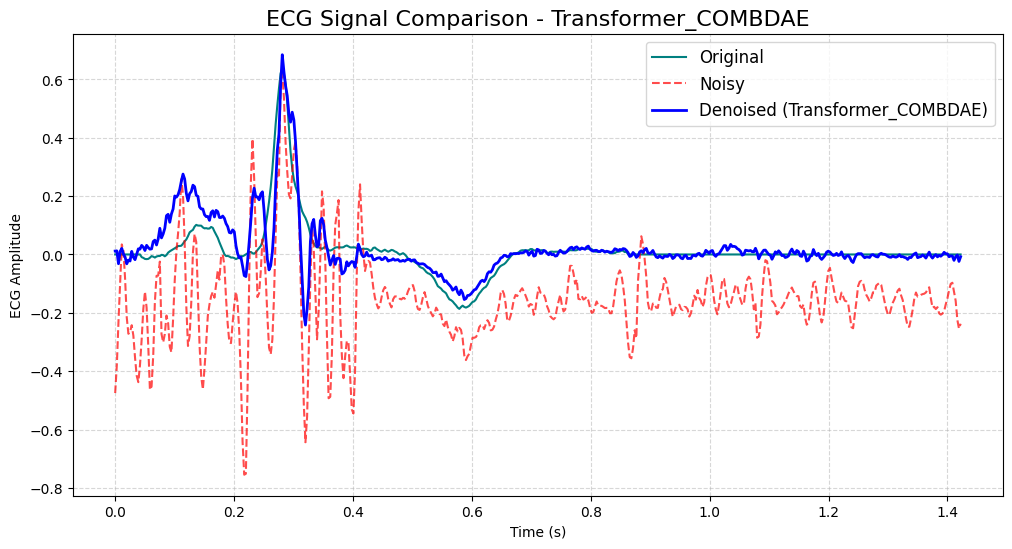

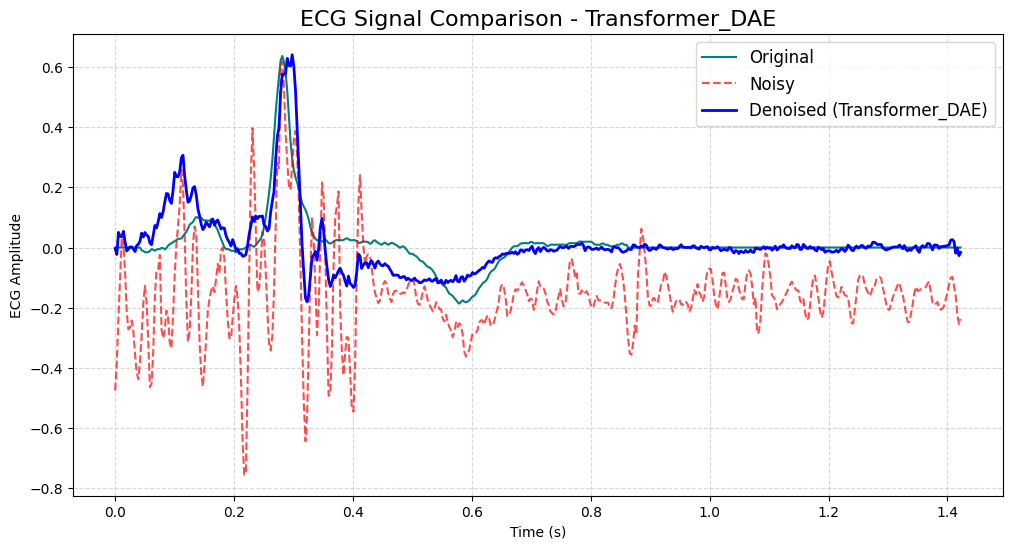

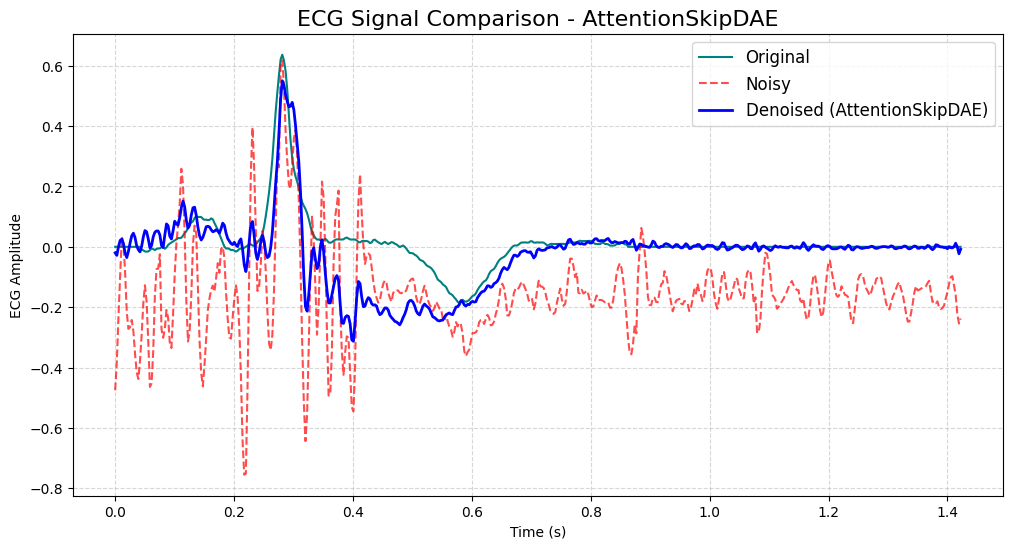

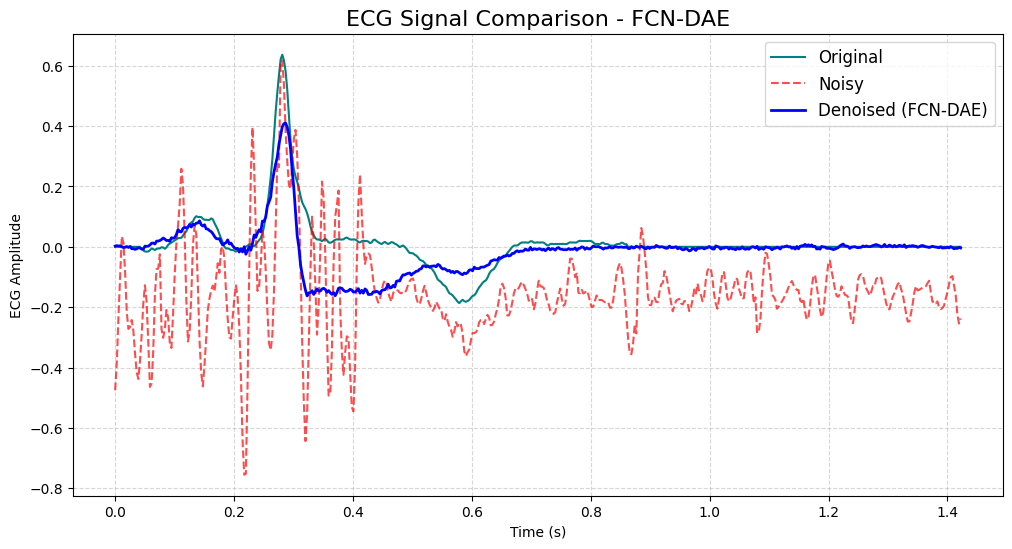

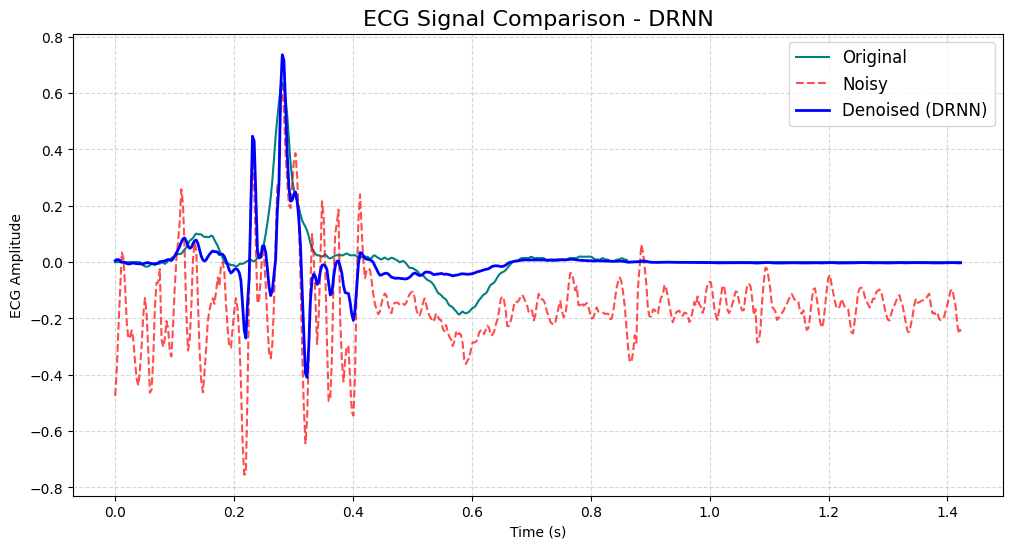

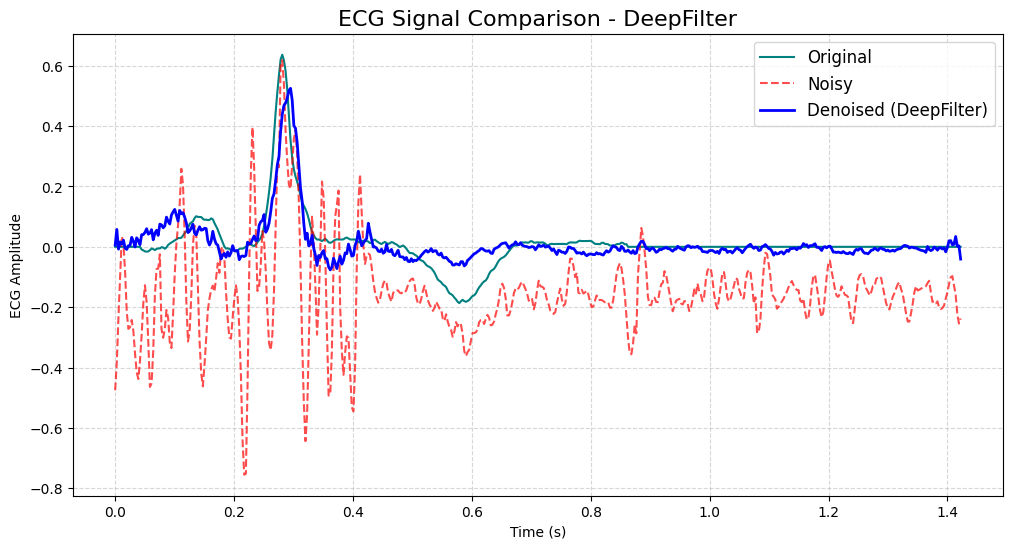

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 모델 결과 로드
models = {
    "Transformer_COMBDAE": test_Transformer_COMBDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "FCN-DAE": test_FCN_DAE,
    "DRNN": test_DRNN,
    "DeepFilter": test_DeepFilter
}

def plot_segment_comparison(y_test, y_noisy, y_pred, model_name):
    """
    특정 샘플에 대해 원본, 노이즈 포함, 복원된 신호를 비교하는 플롯을 생성.
    
    Parameters:
    - y_test: 원본 신호 (shape: samples, 512, 1)
    - y_noisy: 노이즈가 포함된 신호 (shape: samples, 512, 1)
    - y_pred: 복원된 신호 (모델 출력, shape: samples, 512, 1)
    - model_name: 모델 이름
    """
    # 차원 축소 (마지막 차원 제거)
    y_test = y_test.squeeze(axis=-1)  # (samples, 512)
    y_noisy = y_noisy.squeeze(axis=-1)
    y_pred = y_pred.squeeze(axis=-1)

    # 특정 샘플 선택 (예: 첫 번째 샘플)
    y_test = y_test[100]  # (512,)
    y_noisy = y_noisy[100]  # (512,)
    y_pred = y_pred[100]  # (512,)

    # 시간 축 생성 (512개의 샘플을 정규화된 시간으로 변환)
    time_axis = np.linspace(0, len(y_test) / 360, len(y_test))  # 샘플링 주파수 360Hz 기준

    plt.figure(figsize=(12, 6))

    # 신호 플로팅
    plt.plot(time_axis, y_test, label="Original", color="teal", linewidth=1.5)
    plt.plot(time_axis, y_noisy, label="Noisy", color="red", linestyle="--", alpha=0.7)
    plt.plot(time_axis, y_pred, label=f"Denoised ({model_name})", color="blue", linewidth=2)

    # 그래프 설정
    plt.title(f"ECG Signal Comparison - {model_name}", fontsize=16)
    plt.xlabel("Time (s)")
    plt.ylabel("ECG Amplitude")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(fontsize=12)
    
    # 저장
    # plt.savefig(f"comparison_plots/{model_name}.png", dpi=300, bbox_inches='tight')
    # plt.close()
    print(f"Saved segment comparison plot for {model_name}")

# 모델별 플롯 생성
for model_name, test_model in models.items():
    y_test, y_pred = test_model[1], test_model[2]
    y_noisy = test_model[0]
    plot_segment_comparison(y_test, y_noisy, y_pred, model_name)


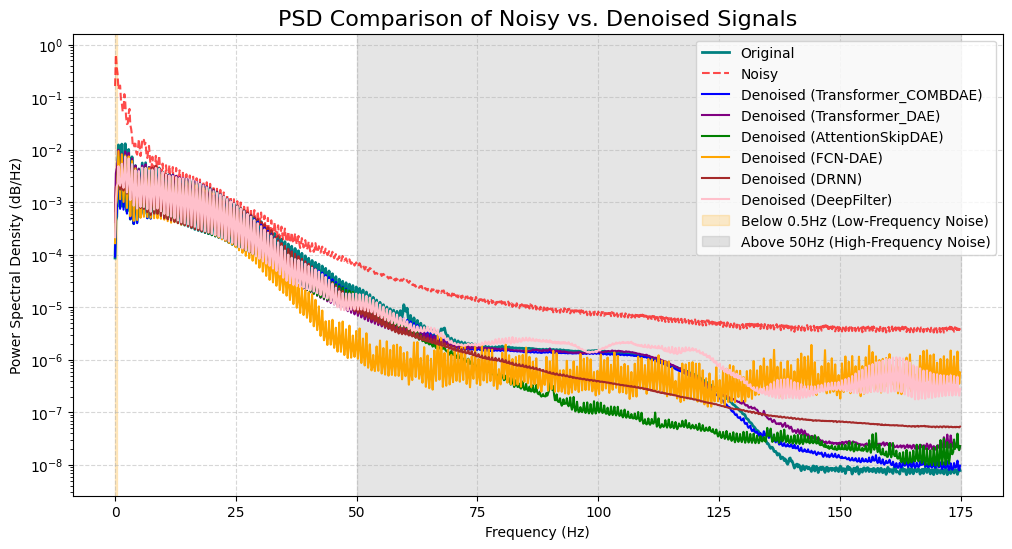

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# 모델 결과 로드
models = {
    "Transformer_COMBDAE": test_Transformer_COMBDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "FCN-DAE": test_FCN_DAE,
    "DRNN": test_DRNN,
    "DeepFilter": test_DeepFilter
}

def compute_psd(signal, fs=360, nperseg=2048):
    """Welch 방법을 사용하여 PSD를 계산"""
    freqs, psd = welch(signal.flatten(), fs=fs, nperseg=nperseg, window='hann')
    return freqs, psd

def plot_psd_comparison(y_test, y_noisy, model_preds, model_names, fs=360, cutoff=175):
    """
    NOISY 신호와 각 모델의 PSD를 비교하는 그래프 생성.
    """
    plt.figure(figsize=(12, 6))

    # 원본 및 NOISY 신호의 PSD 계산
    freqs, psd_original = compute_psd(y_test, fs)
    _, psd_noisy = compute_psd(y_noisy, fs)

    # 주파수 제한 (cutoff)
    mask = freqs <= cutoff
    freqs = freqs[mask]
    psd_original = psd_original[mask]
    psd_noisy = psd_noisy[mask]

    # PSD 플롯
    plt.semilogy(freqs, psd_original, label="Original", color="teal", linewidth=2)
    plt.semilogy(freqs, psd_noisy, label="Noisy", color="red", linestyle="--", alpha=0.7)

    # 모델별 PSD 추가
    colors = ['blue', 'purple', 'green', 'orange', 'brown', 'pink']
    for idx, (model_name, y_pred) in enumerate(zip(model_names, model_preds)):
        _, psd_model = compute_psd(y_pred, fs)
        psd_model = psd_model[mask]
        plt.semilogy(freqs, psd_model, label=f"Denoised ({model_name})", color=colors[idx], linewidth=1.5)

    # 노이즈 영향이 큰 영역 강조 (저주파, 고주파)
    plt.axvspan(0, 0.5, color='orange', alpha=0.2, label="Below 0.5Hz (Low-Frequency Noise)")
    plt.axvspan(50, cutoff, color='gray', alpha=0.2, label="Above 50Hz (High-Frequency Noise)")

    # 플롯 스타일 설정
    plt.title("PSD Comparison of Noisy vs. Denoised Signals", fontsize=16)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (dB/Hz)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=10)

    # 그래프 저장
    plt.savefig("psd_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

# 모델별 PSD 분석 실행
model_preds = []
model_names = []

for model_name, test_model in models.items():
    y_test, y_pred = test_model[1], test_model[2]
    y_noisy = test_model[0]

    model_preds.append(y_pred)
    model_names.append(model_name)

# NOISY와 모든 모델의 PSD 비교 시각화
plot_psd_comparison(y_test[:], y_noisy[:], model_preds, model_names)


# 진짜 시각화


combdae로 구간별 비교

In [ ]:
print("Noise Indices for each range:")
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]
    print(f"Range {noise_start}-{noise_end}: Indices = {noise_indices}")


Noise Indices for each range:
Range 0.2-0.6: Indices = [    0     1     4 ... 13308 13312 13315]
Range 0.6-1.0: Indices = [   11    12    17 ... 13299 13301 13313]
Range 1.0-1.5: Indices = [    2     9    15 ... 13304 13307 13310]
Range 1.5-2.0: Indices = [    3     6     8 ... 13309 13311 13314]


총 105개의 ECG 신호가 저장됨
샘플 신호 목록: ['sele0122', 'sele0107', 'sel16272', 'sele0604', 'sel104']
선택된 신호(sele0122)에서 1412개의 비트(heartbeat) 존재
비트 길이 (최소: 188, 최대: 257, 평균: 229.57)


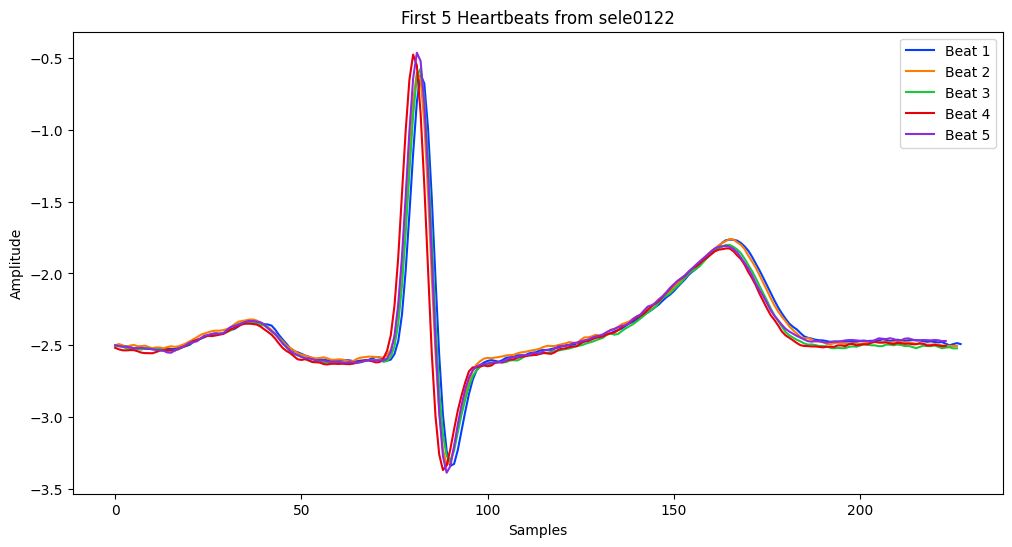

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# 저장된 pkl 파일 로드
file_path = "/home/dhc99/ecg_denoise/data/QTDatabase.pkl"

with open(file_path, "rb") as file:
    QTDatabase = pickle.load(file)

# 데이터 확인
print(f"총 {len(QTDatabase)}개의 ECG 신호가 저장됨")
print(f"샘플 신호 목록: {list(QTDatabase.keys())[:5]}")  # 처음 5개 신호 이름 출력

# 특정 신호 선택 (첫 번째 신호)
first_key = list(QTDatabase.keys())[0]
beats = QTDatabase[first_key]

print(f"선택된 신호({first_key})에서 {len(beats)}개의 비트(heartbeat) 존재")

# 몇 개의 비트 길이 확인
beat_lengths = [len(b) for b in beats]
print(f"비트 길이 (최소: {min(beat_lengths)}, 최대: {max(beat_lengths)}, 평균: {np.mean(beat_lengths):.2f})")


# 첫 번째 신호의 처음 5개 비트를 시각화
plt.figure(figsize=(12, 6))
for i in range(min(5, len(beats))):
    plt.plot(beats[i], label=f"Beat {i+1}")

plt.title(f"First 5 Heartbeats from {first_key}")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


선택된 신호(sel104)의 전체 샘플 길이: 56136


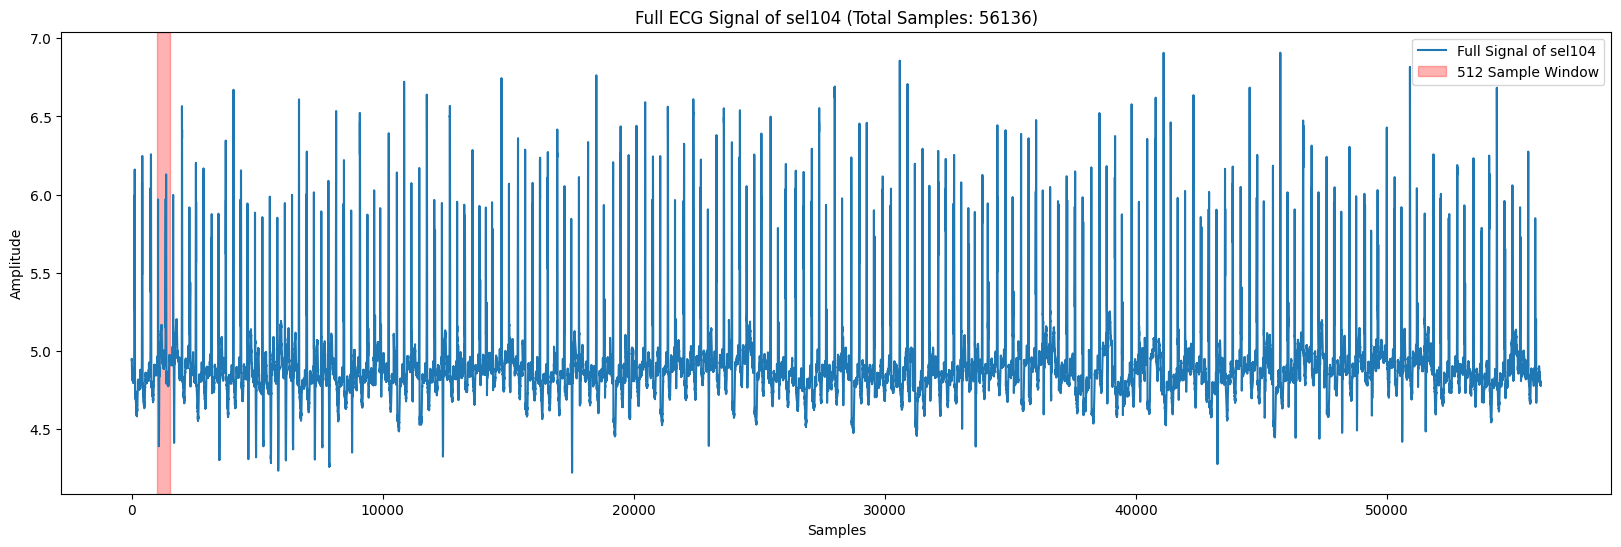

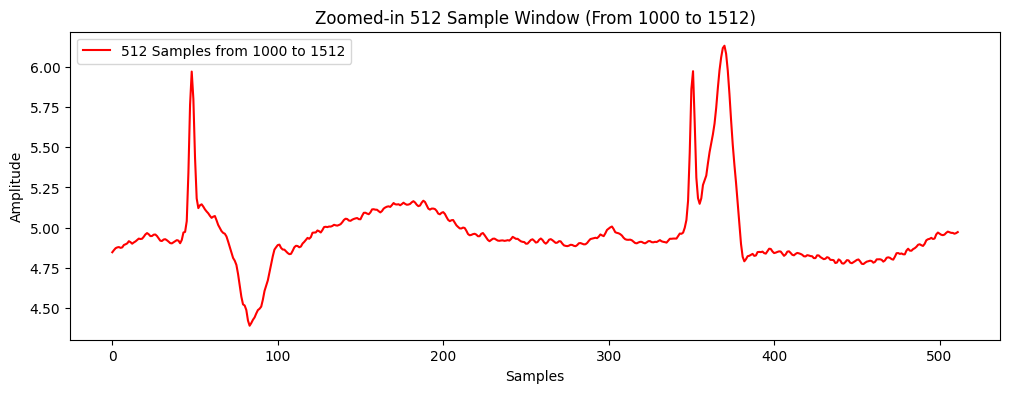

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# 저장된 pkl 파일 로드
file_path = "/home/dhc99/ecg_denoise/data/QTDatabase.pkl"

with open(file_path, "rb") as file:
    QTDatabase = pickle.load(file)

# sel104 신호 선택
signal_name = "sel104"
if signal_name in QTDatabase:
    beats = QTDatabase[signal_name]
    
    # 전체 샘플 길이 계산
    total_samples = sum(len(beat) for beat in beats)
    print(f"선택된 신호({signal_name})의 전체 샘플 길이: {total_samples}")

    # 모든 비트를 하나의 연속된 신호로 연결
    full_signal = np.concatenate(beats)

    # 전체 신호 시각화
    plt.figure(figsize=(20, 6))
    plt.plot(full_signal, label=f"Full Signal of {signal_name}")
    
    # 512 샘플 구간 선택 (예: 1000부터 1512까지)
    start_sample = 1000  # 시작 샘플 (원하는 위치로 변경 가능)
    end_sample = start_sample + 512  # 512 샘플 길이
    plt.axvspan(start_sample, end_sample, color='red', alpha=0.3, label="512 Sample Window")  # 박스로 표시
    plt.title(f"Full ECG Signal of {signal_name} (Total Samples: {total_samples})")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    # 512 샘플 구간 확대하여 시각화
    plt.figure(figsize=(12, 4))
    plt.plot(full_signal[start_sample:end_sample], label=f"512 Samples from {start_sample} to {end_sample}", color='red')
    plt.title(f"Zoomed-in 512 Sample Window (From {start_sample} to {end_sample})")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()
else:
    print(f"{signal_name} 신호가 데이터베이스에 존재하지 않습니다.")

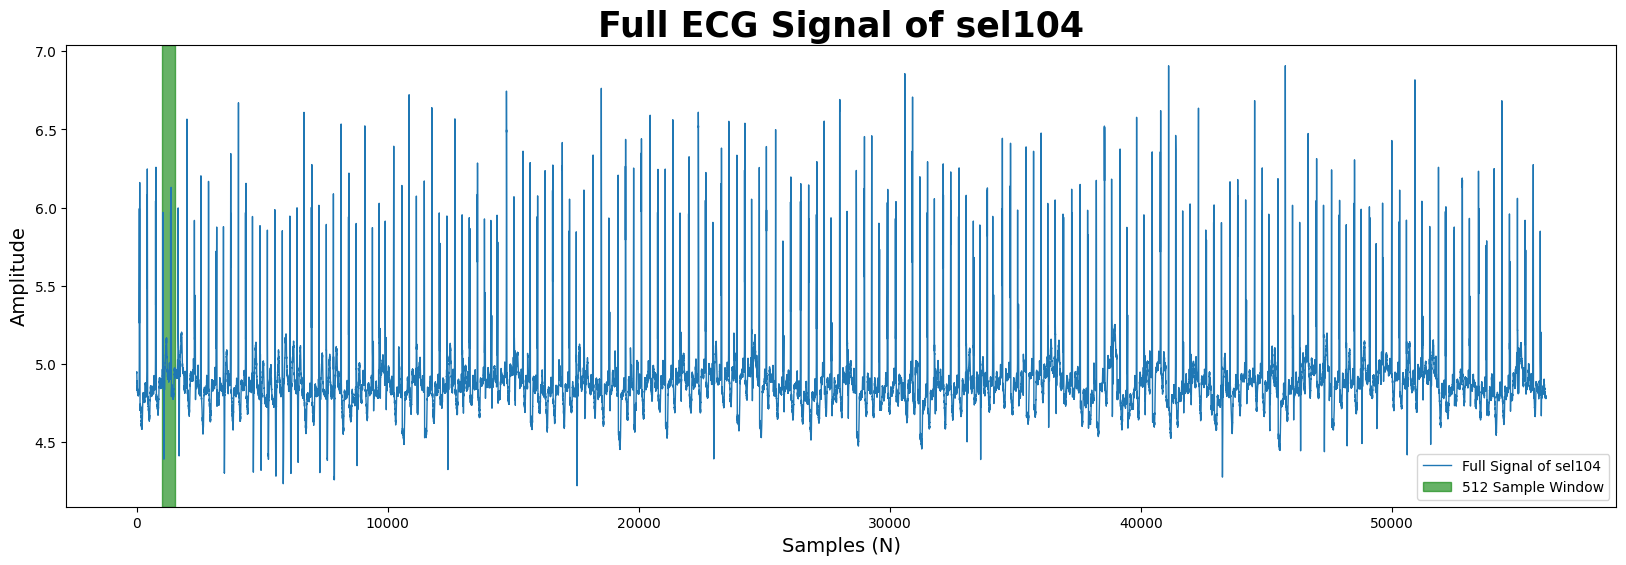

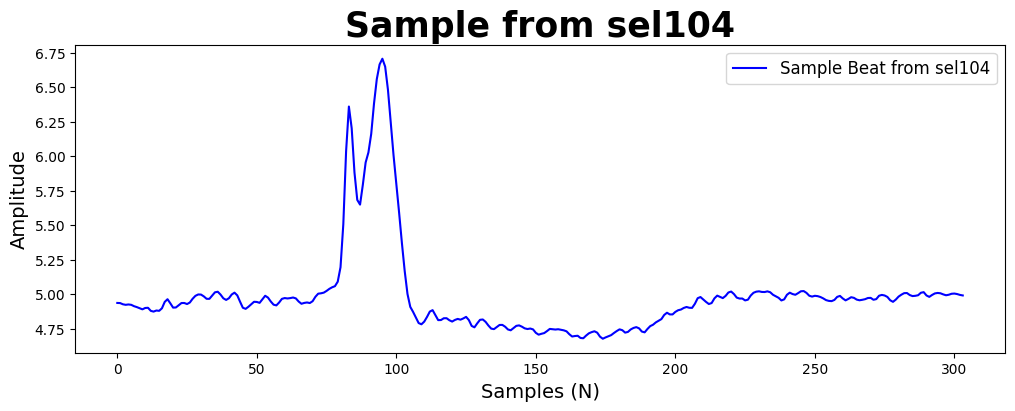

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# 저장된 pkl 파일 로드 (경로 수정 필요)
file_path = "data/QTDatabase.pkl"  # 파일이 존재하는 올바른 경로로 수정

try:
    with open(file_path, "rb") as file:
        QTDatabase = pickle.load(file)
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {file_path}")
    QTDatabase = None

if QTDatabase:
    # sel104 신호 선택
    signal_name = "sel104"
    if signal_name in QTDatabase:
        beats = QTDatabase[signal_name]

        # 모든 비트를 하나의 연속된 신호로 연결
        full_signal = np.concatenate(beats)
        total_samples = len(full_signal)

        # 특정 샘플 범위 선택 (512 샘플)
        start_sample = 1000  # 시작 샘플
        end_sample = start_sample + 512  # 512 샘플 길이

        # 전체 신호 시각화 (512 샘플 부분 더 진한 분홍색 강조)
        plt.figure(figsize=(20, 6))
        plt.plot(full_signal, label=f"Full Signal of {signal_name}", linewidth=1)
        plt.axvspan(start_sample, end_sample, color='green', alpha=0.6, label="512 Sample Window")
        plt.title(f"Full ECG Signal of {signal_name}", fontsize=25, fontweight='bold')
        plt.xlabel("Samples (N)", fontsize=14)
        plt.ylabel("Amplitude", fontsize=14)
        plt.legend(fontsize=10, loc="lower right")
        plt.show()

        # QTDatabase에서 하나의 비트 샘플 선택
        sample_beat = beats[100]  # 첫 번째 비트 선택

        # 개별 비트 시각화
        plt.figure(figsize=(12, 4))
        plt.plot(sample_beat, color='blue', label=f"Sample Beat from {signal_name}")
        plt.title(f"Sample from {signal_name}", fontsize=25, fontweight='bold')
        plt.xlabel("Samples (N)", fontsize=14)
        plt.ylabel("Amplitude", fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

    else:
        print(f"{signal_name} 신호가 데이터베이스에 존재하지 않습니다.")
